In [16]:
# !pip install -U keras-tuner
# !pip install tensorflow_datasets

In [13]:
!nvidia-smi

Wed May 20 18:52:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 441.22       Driver Version: 441.22       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   40C    P8     3W /  N/A |    495MiB /  6144MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import os
import datetime
import tensorflow_datasets as tfds
from kerastuner.engine.hyperparameters import HyperParameters

%load_ext tensorboard

In [18]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
print(tf.__version__) # Keras-Tuner works only on Tensorflow V2.0

2.1.0


In [21]:
datasets, info = tfds.load(name='fashion_mnist', 
                           with_info=True, 
                           as_supervised=True, 
                           try_gcs=True, 
                           split=['train', 'test'])

Shuffling and writing examples to C:\Users\suraj\tensorflow_datasets\fashion_mnist\3.0.1.incomplete4ODG96\fashion_mnist-train.tfrecord


Shuffling and writing examples to C:\Users\suraj\tensorflow_datasets\fashion_mnist\3.0.1.incomplete4ODG96\fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to C:\Users\suraj\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [62]:
print(info)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [27]:
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
10
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [28]:
fm_train, fm_test = datasets[0], datasets[1]
fm_val = fm_test.take(3000)
fm_test = fm_test.skip(3000)

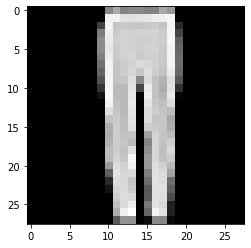

Label: 1
Category: Trouser


In [30]:
import matplotlib.pyplot as plt
import numpy as np
for fm_sample in fm_train.take(5):
    image, label = fm_sample[0], fm_sample[1]

plt.figure()
plt.imshow(image.numpy()[:, :, 0].astype(np.float32), 
           cmap = plt.get_cmap('gray'))
plt.show()
print('Label: %d' % label.numpy())
print("Category: %s" % info.features["label"].names[label.numpy()])

In [6]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [7]:
# Scaling Down the Images (Pixels convert to 0 to 1)

In [31]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0

  return image, label

In [32]:
def get_dataset(batch_size=64):
  train_dataset_scaled = fm_train.map(scale).shuffle(60000).batch(batch_size)
  test_dataset_scaled = fm_test.map(scale).batch(batch_size)
  val_dataset_scaled = fm_val.map(scale).batch(batch_size)
  return train_dataset_scaled, test_dataset_scaled, val_dataset_scaled

In [43]:
# (Search Space) Define different HP to search the Neural Architecture Search
hp = HyperParameters()
hp.Choice('learning_rate', [1e-1, 1e-3])
hp.Int('conv_blocks', 3, 4, default=3)
hp.Int('hidden_size', 128, 256, step=64, default=128)

128

In [34]:
def build_model(hp):
    inputs = tf.keras.Input(shape=(28, 28, 1)) # Image size in Fashion Mnist dataset
    x = inputs
    for i in range(hp.get('conv_blocks')):
        filters = hp.Int('filters_' + str(i), 32, 256, step=64)
        for _ in range(2):
            x = tf.keras.layers.Convolution2D(
              filters, kernel_size=(3, 3), padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
        if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
            x = tf.keras.layers.MaxPool2D()(x)
        else:
            x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = tf.keras.layers.Dense( hp.get('hidden_size'),activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(hp.get('learning_rate')),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])
    return model

In [45]:
import kerastuner as kt

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    hyperparameters=hp,
    max_epochs=5,
    hyperband_iterations=2)
  

In [46]:
tuner.search_space_summary()

[Search space summary]
 |-Default search space size: 9
 > learning_rate (Choice)
 |-default: 0.1
 |-ordered: True
 |-values: [0.1, 0.001]
 > conv_blocks (Int)
 |-default: 3
 |-max_value: 4
 |-min_value: 3
 |-sampling: None
 |-step: 1
 > hidden_size (Int)
 |-default: 128
 |-max_value: 256
 |-min_value: 128
 |-sampling: None
 |-step: 64
 > filters_0 (Int)
 |-default: None
 |-max_value: 256
 |-min_value: 32
 |-sampling: None
 |-step: 64
 > pooling_0 (Choice)
 |-default: avg
 |-ordered: False
 |-values: ['avg', 'max']
 > filters_1 (Int)
 |-default: None
 |-max_value: 256
 |-min_value: 32
 |-sampling: None
 |-step: 64
 > pooling_1 (Choice)
 |-default: avg
 |-ordered: False
 |-values: ['avg', 'max']
 > filters_2 (Int)
 |-default: None
 |-max_value: 256
 |-min_value: 32
 |-sampling: None
 |-step: 64
 > pooling_2 (Choice)
 |-default: avg
 |-ordered: False
 |-values: ['avg', 'max']


In [47]:
train_dataset, test_dataset, val_dataset = get_dataset()
train_dataset.cache() #Cache Utilizes GPU memory
val_dataset.cache()

tuner.search(train_dataset,
             validation_data=val_dataset,
             epochs=5,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Epoch 1/2


    168/Unknown - 8s 8s/step - loss: 2.5656 - accuracy: 0.09 - 8s 4s/step - loss: 2.4020 - accuracy: 0.11 - 8s 3s/step - loss: 2.3125 - accuracy: 0.14 - 8s 2s/step - loss: 2.2648 - accuracy: 0.16 - 8s 2s/step - loss: 2.1944 - accuracy: 0.19 - 8s 1s/step - loss: 2.1443 - accuracy: 0.21 - 8s 1s/step - loss: 2.1150 - accuracy: 0.23 - 8s 982ms/step - loss: 2.0860 - accuracy: 0.244 - 8s 877ms/step - loss: 2.0492 - accuracy: 0.260 - 8s 793ms/step - loss: 2.0239 - accuracy: 0.270 - 8s 725ms/step - loss: 1.9914 - accuracy: 0.289 - 8s 668ms/step - loss: 1.9741 - accuracy: 0.296 - 8s 619ms/step - loss: 1.9443 - accuracy: 0.306 - 8s 578ms/step - loss: 1.9144 - accuracy: 0.313 - 8s 542ms/step - loss: 1.8824 - accuracy: 0.322 - 8s 511ms/step - loss: 1.8616 - accuracy: 0.330 - 8s 483ms/step - loss: 1.8409 - accuracy: 0.337 - 8s 458ms/step - loss: 1.8220 - accuracy: 0.345 - 8s 436ms/step - loss: 1.8062 - accuracy: 0.349 - 8s 416ms/step - loss: 1.7869 - accuracy: 0.356 - 8s 398ms/step - loss: 1.7635 -

    335/Unknown - 14s 85ms/step - loss: 0.9044 - accuracy: 0.672 - 14s 85ms/step - loss: 0.9025 - accuracy: 0.673 - 14s 84ms/step - loss: 0.8999 - accuracy: 0.674 - 14s 84ms/step - loss: 0.8979 - accuracy: 0.674 - 14s 84ms/step - loss: 0.8964 - accuracy: 0.675 - 15s 84ms/step - loss: 0.8943 - accuracy: 0.676 - 15s 83ms/step - loss: 0.8927 - accuracy: 0.677 - 15s 83ms/step - loss: 0.8910 - accuracy: 0.677 - 15s 83ms/step - loss: 0.8889 - accuracy: 0.678 - 15s 83ms/step - loss: 0.8878 - accuracy: 0.678 - 15s 82ms/step - loss: 0.8856 - accuracy: 0.679 - 15s 82ms/step - loss: 0.8842 - accuracy: 0.680 - 15s 82ms/step - loss: 0.8823 - accuracy: 0.680 - 15s 82ms/step - loss: 0.8799 - accuracy: 0.681 - 15s 81ms/step - loss: 0.8787 - accuracy: 0.682 - 15s 81ms/step - loss: 0.8761 - accuracy: 0.683 - 15s 81ms/step - loss: 0.8751 - accuracy: 0.683 - 15s 81ms/step - loss: 0.8734 - accuracy: 0.684 - 15s 81ms/step - loss: 0.8713 - accuracy: 0.685 - 15s 80ms/step - loss: 0.8695 - accuracy: 0.685 - 15

    502/Unknown - 21s 63ms/step - loss: 0.7055 - accuracy: 0.743 - 21s 62ms/step - loss: 0.7049 - accuracy: 0.744 - 21s 62ms/step - loss: 0.7040 - accuracy: 0.744 - 21s 62ms/step - loss: 0.7034 - accuracy: 0.744 - 21s 62ms/step - loss: 0.7030 - accuracy: 0.744 - 21s 62ms/step - loss: 0.7023 - accuracy: 0.744 - 21s 62ms/step - loss: 0.7010 - accuracy: 0.745 - 21s 62ms/step - loss: 0.7005 - accuracy: 0.745 - 21s 62ms/step - loss: 0.6995 - accuracy: 0.746 - 21s 62ms/step - loss: 0.6987 - accuracy: 0.746 - 21s 62ms/step - loss: 0.6980 - accuracy: 0.746 - 21s 62ms/step - loss: 0.6973 - accuracy: 0.747 - 21s 62ms/step - loss: 0.6964 - accuracy: 0.747 - 22s 62ms/step - loss: 0.6956 - accuracy: 0.747 - 22s 62ms/step - loss: 0.6947 - accuracy: 0.748 - 22s 62ms/step - loss: 0.6938 - accuracy: 0.748 - 22s 62ms/step - loss: 0.6930 - accuracy: 0.748 - 22s 61ms/step - loss: 0.6921 - accuracy: 0.749 - 22s 61ms/step - loss: 0.6916 - accuracy: 0.749 - 22s 61ms/step - loss: 0.6910 - accuracy: 0.749 - 22

    669/Unknown - 28s 55ms/step - loss: 0.6130 - accuracy: 0.779 - 28s 55ms/step - loss: 0.6124 - accuracy: 0.779 - 28s 55ms/step - loss: 0.6118 - accuracy: 0.779 - 28s 55ms/step - loss: 0.6114 - accuracy: 0.779 - 28s 55ms/step - loss: 0.6109 - accuracy: 0.779 - 28s 55ms/step - loss: 0.6106 - accuracy: 0.779 - 28s 55ms/step - loss: 0.6101 - accuracy: 0.780 - 28s 55ms/step - loss: 0.6095 - accuracy: 0.780 - 28s 55ms/step - loss: 0.6088 - accuracy: 0.780 - 28s 55ms/step - loss: 0.6082 - accuracy: 0.780 - 28s 55ms/step - loss: 0.6078 - accuracy: 0.780 - 28s 55ms/step - loss: 0.6076 - accuracy: 0.780 - 28s 55ms/step - loss: 0.6070 - accuracy: 0.781 - 28s 55ms/step - loss: 0.6063 - accuracy: 0.781 - 28s 55ms/step - loss: 0.6056 - accuracy: 0.781 - 28s 55ms/step - loss: 0.6051 - accuracy: 0.781 - 28s 55ms/step - loss: 0.6051 - accuracy: 0.781 - 28s 55ms/step - loss: 0.6049 - accuracy: 0.781 - 28s 55ms/step - loss: 0.6048 - accuracy: 0.781 - 29s 55ms/step - loss: 0.6045 - accuracy: 0.781 - 29

    836/Unknown - 34s 51ms/step - loss: 0.5555 - accuracy: 0.800 - 35s 51ms/step - loss: 0.5551 - accuracy: 0.800 - 35s 51ms/step - loss: 0.5547 - accuracy: 0.800 - 35s 51ms/step - loss: 0.5543 - accuracy: 0.800 - 35s 51ms/step - loss: 0.5539 - accuracy: 0.800 - 35s 51ms/step - loss: 0.5535 - accuracy: 0.800 - 35s 51ms/step - loss: 0.5533 - accuracy: 0.800 - 35s 51ms/step - loss: 0.5533 - accuracy: 0.800 - 35s 51ms/step - loss: 0.5530 - accuracy: 0.801 - 35s 51ms/step - loss: 0.5525 - accuracy: 0.801 - 35s 51ms/step - loss: 0.5522 - accuracy: 0.801 - 35s 51ms/step - loss: 0.5516 - accuracy: 0.801 - 35s 51ms/step - loss: 0.5513 - accuracy: 0.801 - 35s 51ms/step - loss: 0.5509 - accuracy: 0.801 - 35s 51ms/step - loss: 0.5505 - accuracy: 0.801 - 35s 51ms/step - loss: 0.5505 - accuracy: 0.801 - 35s 51ms/step - loss: 0.5503 - accuracy: 0.801 - 35s 51ms/step - loss: 0.5498 - accuracy: 0.802 - 35s 51ms/step - loss: 0.5496 - accuracy: 0.802 - 35s 51ms/step - loss: 0.5491 - accuracy: 0.802 - 35

938/938 [==============================]0.5109 - accuracy: 0.816 - 41s 49ms/step - loss: 0.5106 - accuracy: 0.816 - 41s 49ms/step - loss: 0.5104 - accuracy: 0.816 - 41s 49ms/step - loss: 0.5101 - accuracy: 0.816 - 41s 49ms/step - loss: 0.5101 - accuracy: 0.816 - 41s 49ms/step - loss: 0.5100 - accuracy: 0.816 - 41s 49ms/step - loss: 0.5099 - accuracy: 0.816 - 41s 49ms/step - loss: 0.5098 - accuracy: 0.816 - 42s 49ms/step - loss: 0.5095 - accuracy: 0.817 - 42s 49ms/step - loss: 0.5093 - accuracy: 0.817 - 42s 49ms/step - loss: 0.5090 - accuracy: 0.817 - 42s 49ms/step - loss: 0.5089 - accuracy: 0.817 - 42s 49ms/step - loss: 0.5086 - accuracy: 0.817 - 42s 49ms/step - loss: 0.5083 - accuracy: 0.817 - 42s 49ms/step - loss: 0.5083 - accuracy: 0.817 - 42s 49ms/step - loss: 0.5080 - accuracy: 0.817 - 42s 49ms/step - loss: 0.5079 - accuracy: 0.817 - 42s 49ms/step - loss: 0.5076 - accuracy: 0.817 - 42s 49ms/step - loss: 0.5073 - accuracy: 0.817 - 42s 49ms/step - loss: 0.5073 - accuracy: 0.817 - 42

371/938 [==========>...................] - ETA: 35:49 - loss: 0.3082 - accuracy: 0.843 - ETA: 12:21 - loss: 0.2804 - accuracy: 0.890 - ETA: 7:38 - loss: 0.2825 - accuracy: 0.896 - ETA: 5:36 - loss: 0.2750 - accuracy: 0.89 - ETA: 4:29 - loss: 0.2908 - accuracy: 0.88 - ETA: 3:46 - loss: 0.2805 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2856 - accuracy: 0.89 - ETA: 2:54 - loss: 0.3007 - accuracy: 0.88 - ETA: 2:37 - loss: 0.2948 - accuracy: 0.88 - ETA: 2:24 - loss: 0.3036 - accuracy: 0.88 - ETA: 2:13 - loss: 0.3052 - accuracy: 0.88 - ETA: 2:05 - loss: 0.3102 - accuracy: 0.87 - ETA: 1:57 - loss: 0.3114 - accuracy: 0.88 - ETA: 1:51 - loss: 0.3176 - accuracy: 0.88 - ETA: 1:45 - loss: 0.3173 - accuracy: 0.88 - ETA: 1:41 - loss: 0.3138 - accuracy: 0.88 - ETA: 1:36 - loss: 0.3140 - accuracy: 0.88 - ETA: 1:33 - loss: 0.3108 - accuracy: 0.88 - ETA: 1:29 - loss: 0.3056 - accuracy: 0.88 - ETA: 1:26 - loss: 0.3051 - accuracy: 0.88 - ETA: 1:23 - loss: 0.3066 - accuracy: 0.88 - ETA: 1:21 - loss: 0.3028 - a

745/938 [======================>.......] - ETA: 25s - loss: 0.3075 - accuracy: 0.889 - ETA: 25s - loss: 0.3079 - accuracy: 0.889 - ETA: 24s - loss: 0.3080 - accuracy: 0.889 - ETA: 24s - loss: 0.3086 - accuracy: 0.889 - ETA: 24s - loss: 0.3081 - accuracy: 0.889 - ETA: 24s - loss: 0.3079 - accuracy: 0.889 - ETA: 24s - loss: 0.3080 - accuracy: 0.889 - ETA: 24s - loss: 0.3080 - accuracy: 0.889 - ETA: 24s - loss: 0.3075 - accuracy: 0.889 - ETA: 24s - loss: 0.3073 - accuracy: 0.889 - ETA: 24s - loss: 0.3070 - accuracy: 0.889 - ETA: 23s - loss: 0.3075 - accuracy: 0.889 - ETA: 23s - loss: 0.3078 - accuracy: 0.889 - ETA: 23s - loss: 0.3075 - accuracy: 0.889 - ETA: 23s - loss: 0.3077 - accuracy: 0.889 - ETA: 23s - loss: 0.3073 - accuracy: 0.889 - ETA: 23s - loss: 0.3077 - accuracy: 0.889 - ETA: 23s - loss: 0.3075 - accuracy: 0.889 - ETA: 23s - loss: 0.3071 - accuracy: 0.889 - ETA: 23s - loss: 0.3077 - accuracy: 0.889 - ETA: 23s - loss: 0.3077 - accuracy: 0.889 - ETA: 22s - loss: 0.3078 - accurac

938/938 [==============================] - ETA: 7s - loss: 0.2981 - accuracy: 0.89 - ETA: 7s - loss: 0.2977 - accuracy: 0.89 - ETA: 7s - loss: 0.2978 - accuracy: 0.89 - ETA: 7s - loss: 0.2974 - accuracy: 0.89 - ETA: 7s - loss: 0.2973 - accuracy: 0.89 - ETA: 7s - loss: 0.2970 - accuracy: 0.89 - ETA: 7s - loss: 0.2967 - accuracy: 0.89 - ETA: 7s - loss: 0.2966 - accuracy: 0.89 - ETA: 7s - loss: 0.2964 - accuracy: 0.89 - ETA: 7s - loss: 0.2962 - accuracy: 0.89 - ETA: 7s - loss: 0.2962 - accuracy: 0.89 - ETA: 6s - loss: 0.2963 - accuracy: 0.89 - ETA: 6s - loss: 0.2962 - accuracy: 0.89 - ETA: 6s - loss: 0.2963 - accuracy: 0.89 - ETA: 6s - loss: 0.2963 - accuracy: 0.89 - ETA: 6s - loss: 0.2962 - accuracy: 0.89 - ETA: 6s - loss: 0.2960 - accuracy: 0.89 - ETA: 6s - loss: 0.2959 - accuracy: 0.89 - ETA: 6s - loss: 0.2958 - accuracy: 0.89 - ETA: 6s - loss: 0.2956 - accuracy: 0.89 - ETA: 6s - loss: 0.2954 - accuracy: 0.89 - ETA: 6s - loss: 0.2953 - accuracy: 0.89 - ETA: 6s - loss: 0.2953 - accuracy

    172/Unknown - 4s 4s/step - loss: 2.5958 - accuracy: 0.14 - 4s 2s/step - loss: 14.3285 - accuracy: 0.140 - 4s 1s/step - loss: 18.0400 - accuracy: 0.130 - 4s 1s/step - loss: 15.2642 - accuracy: 0.117 - 4s 813ms/step - loss: 13.8475 - accuracy: 0.10 - 4s 683ms/step - loss: 12.0733 - accuracy: 0.10 - 4s 590ms/step - loss: 10.7506 - accuracy: 0.11 - 4s 519ms/step - loss: 9.7676 - accuracy: 0.1191 - 4s 465ms/step - loss: 8.9721 - accuracy: 0.116 - 4s 421ms/step - loss: 8.3081 - accuracy: 0.109 - 4s 386ms/step - loss: 7.7613 - accuracy: 0.112 - 4s 356ms/step - loss: 7.3062 - accuracy: 0.113 - 4s 331ms/step - loss: 6.9255 - accuracy: 0.113 - 4s 309ms/step - loss: 6.6005 - accuracy: 0.110 - 4s 291ms/step - loss: 6.3175 - accuracy: 0.107 - 4s 274ms/step - loss: 6.0676 - accuracy: 0.106 - 4s 260ms/step - loss: 5.8482 - accuracy: 0.105 - 4s 247ms/step - loss: 5.6502 - accuracy: 0.112 - 4s 235ms/step - loss: 5.4778 - accuracy: 0.109 - 5s 225ms/step - loss: 5.3218 - accuracy: 0.108 - 5s 216ms/st

    340/Unknown - 9s 51ms/step - loss: 2.6600 - accuracy: 0.09 - 9s 51ms/step - loss: 2.6580 - accuracy: 0.09 - 9s 51ms/step - loss: 2.6560 - accuracy: 0.09 - 9s 51ms/step - loss: 2.6541 - accuracy: 0.09 - 9s 51ms/step - loss: 2.6520 - accuracy: 0.09 - 9s 51ms/step - loss: 2.6501 - accuracy: 0.09 - 9s 51ms/step - loss: 2.6483 - accuracy: 0.09 - 9s 51ms/step - loss: 2.6463 - accuracy: 0.09 - 9s 50ms/step - loss: 2.6444 - accuracy: 0.09 - 9s 50ms/step - loss: 2.6424 - accuracy: 0.09 - 9s 50ms/step - loss: 2.6406 - accuracy: 0.09 - 9s 50ms/step - loss: 2.6389 - accuracy: 0.09 - 9s 50ms/step - loss: 2.6371 - accuracy: 0.09 - 9s 50ms/step - loss: 2.6354 - accuracy: 0.09 - 9s 50ms/step - loss: 2.6337 - accuracy: 0.09 - 9s 50ms/step - loss: 2.6319 - accuracy: 0.09 - 9s 50ms/step - loss: 2.6303 - accuracy: 0.09 - 9s 49ms/step - loss: 2.6286 - accuracy: 0.09 - 9s 49ms/step - loss: 2.6270 - accuracy: 0.09 - 9s 49ms/step - loss: 2.6252 - accuracy: 0.09 - 9s 49ms/step - loss: 2.6235 - accuracy: 0.

    507/Unknown - 14s 40ms/step - loss: 2.4873 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4867 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4862 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4857 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4852 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4847 - accuracy: 0.097 - 14s 40ms/step - loss: 2.4842 - accuracy: 0.097 - 14s 40ms/step - loss: 2.4837 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4831 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4826 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4821 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4816 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4811 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4806 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4802 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4797 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4792 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4787 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4783 - accuracy: 0.098 - 14s 40ms/step - loss: 2.4779 - accuracy: 0.098 - 14

    674/Unknown - 19s 37ms/step - loss: 2.4289 - accuracy: 0.099 - 19s 37ms/step - loss: 2.4287 - accuracy: 0.098 - 19s 37ms/step - loss: 2.4284 - accuracy: 0.098 - 19s 37ms/step - loss: 2.4282 - accuracy: 0.098 - 19s 36ms/step - loss: 2.4280 - accuracy: 0.098 - 19s 36ms/step - loss: 2.4277 - accuracy: 0.098 - 19s 36ms/step - loss: 2.4275 - accuracy: 0.098 - 19s 36ms/step - loss: 2.4272 - accuracy: 0.098 - 19s 36ms/step - loss: 2.4270 - accuracy: 0.099 - 19s 36ms/step - loss: 2.4267 - accuracy: 0.099 - 19s 36ms/step - loss: 2.4265 - accuracy: 0.099 - 19s 36ms/step - loss: 2.4262 - accuracy: 0.099 - 19s 36ms/step - loss: 2.4260 - accuracy: 0.099 - 19s 36ms/step - loss: 2.4257 - accuracy: 0.099 - 19s 36ms/step - loss: 2.4255 - accuracy: 0.099 - 19s 36ms/step - loss: 2.4254 - accuracy: 0.099 - 19s 36ms/step - loss: 2.4252 - accuracy: 0.099 - 19s 36ms/step - loss: 2.4250 - accuracy: 0.099 - 19s 36ms/step - loss: 2.4248 - accuracy: 0.098 - 19s 36ms/step - loss: 2.4245 - accuracy: 0.099 - 19

    841/Unknown - 23s 35ms/step - loss: 2.4000 - accuracy: 0.099 - 23s 35ms/step - loss: 2.3999 - accuracy: 0.099 - 23s 35ms/step - loss: 2.3998 - accuracy: 0.099 - 23s 35ms/step - loss: 2.3996 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3995 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3994 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3992 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3991 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3990 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3989 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3987 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3986 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3985 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3983 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3982 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3981 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3979 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3978 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3976 - accuracy: 0.099 - 24s 35ms/step - loss: 2.3975 - accuracy: 0.099 - 24

938/938 [==============================]2.3825 - accuracy: 0.099 - 28s 34ms/step - loss: 2.3824 - accuracy: 0.099 - 28s 34ms/step - loss: 2.3823 - accuracy: 0.099 - 28s 34ms/step - loss: 2.3823 - accuracy: 0.099 - 28s 34ms/step - loss: 2.3822 - accuracy: 0.099 - 28s 34ms/step - loss: 2.3821 - accuracy: 0.099 - 28s 34ms/step - loss: 2.3820 - accuracy: 0.099 - 28s 34ms/step - loss: 2.3820 - accuracy: 0.099 - 29s 34ms/step - loss: 2.3819 - accuracy: 0.099 - 29s 34ms/step - loss: 2.3819 - accuracy: 0.099 - 29s 34ms/step - loss: 2.3818 - accuracy: 0.099 - 29s 34ms/step - loss: 2.3817 - accuracy: 0.099 - 29s 34ms/step - loss: 2.3816 - accuracy: 0.099 - 29s 34ms/step - loss: 2.3815 - accuracy: 0.099 - 29s 33ms/step - loss: 2.3814 - accuracy: 0.099 - 29s 33ms/step - loss: 2.3814 - accuracy: 0.099 - 29s 33ms/step - loss: 2.3813 - accuracy: 0.099 - 29s 33ms/step - loss: 2.3812 - accuracy: 0.099 - 29s 33ms/step - loss: 2.3811 - accuracy: 0.099 - 29s 33ms/step - loss: 2.3810 - accuracy: 0.099 - 29

373/938 [==========>...................] - ETA: 33:20 - loss: 2.3193 - accuracy: 0.125 - ETA: 11:24 - loss: 2.3089 - accuracy: 0.114 - ETA: 7:00 - loss: 2.3086 - accuracy: 0.103 - ETA: 5:07 - loss: 2.3120 - accuracy: 0.10 - ETA: 4:04 - loss: 2.3151 - accuracy: 0.09 - ETA: 3:24 - loss: 2.3117 - accuracy: 0.10 - ETA: 2:56 - loss: 2.3142 - accuracy: 0.09 - ETA: 2:35 - loss: 2.3125 - accuracy: 0.09 - ETA: 2:19 - loss: 2.3125 - accuracy: 0.09 - ETA: 2:07 - loss: 2.3114 - accuracy: 0.09 - ETA: 1:57 - loss: 2.3119 - accuracy: 0.09 - ETA: 1:48 - loss: 2.3117 - accuracy: 0.09 - ETA: 1:41 - loss: 2.3098 - accuracy: 0.09 - ETA: 1:36 - loss: 2.3102 - accuracy: 0.09 - ETA: 1:30 - loss: 2.3112 - accuracy: 0.09 - ETA: 1:26 - loss: 2.3118 - accuracy: 0.09 - ETA: 1:22 - loss: 2.3118 - accuracy: 0.09 - ETA: 1:18 - loss: 2.3107 - accuracy: 0.09 - ETA: 1:15 - loss: 2.3099 - accuracy: 0.09 - ETA: 1:12 - loss: 2.3106 - accuracy: 0.09 - ETA: 1:10 - loss: 2.3102 - accuracy: 0.09 - ETA: 1:07 - loss: 2.3098 - a

751/938 [=======================>......] - ETA: 17s - loss: 2.3102 - accuracy: 0.100 - ETA: 17s - loss: 2.3101 - accuracy: 0.101 - ETA: 17s - loss: 2.3103 - accuracy: 0.100 - ETA: 17s - loss: 2.3103 - accuracy: 0.100 - ETA: 17s - loss: 2.3103 - accuracy: 0.100 - ETA: 17s - loss: 2.3103 - accuracy: 0.100 - ETA: 17s - loss: 2.3103 - accuracy: 0.101 - ETA: 17s - loss: 2.3102 - accuracy: 0.100 - ETA: 17s - loss: 2.3102 - accuracy: 0.100 - ETA: 17s - loss: 2.3102 - accuracy: 0.100 - ETA: 17s - loss: 2.3102 - accuracy: 0.100 - ETA: 17s - loss: 2.3101 - accuracy: 0.101 - ETA: 16s - loss: 2.3101 - accuracy: 0.101 - ETA: 16s - loss: 2.3102 - accuracy: 0.101 - ETA: 16s - loss: 2.3103 - accuracy: 0.101 - ETA: 16s - loss: 2.3103 - accuracy: 0.101 - ETA: 16s - loss: 2.3103 - accuracy: 0.101 - ETA: 16s - loss: 2.3104 - accuracy: 0.101 - ETA: 16s - loss: 2.3103 - accuracy: 0.101 - ETA: 16s - loss: 2.3103 - accuracy: 0.101 - ETA: 16s - loss: 2.3103 - accuracy: 0.101 - ETA: 16s - loss: 2.3104 - accurac

938/938 [==============================] - ETA: 5s - loss: 2.3116 - accuracy: 0.10 - ETA: 5s - loss: 2.3116 - accuracy: 0.10 - ETA: 5s - loss: 2.3116 - accuracy: 0.10 - ETA: 5s - loss: 2.3116 - accuracy: 0.10 - ETA: 5s - loss: 2.3116 - accuracy: 0.10 - ETA: 5s - loss: 2.3116 - accuracy: 0.10 - ETA: 5s - loss: 2.3116 - accuracy: 0.10 - ETA: 4s - loss: 2.3116 - accuracy: 0.10 - ETA: 4s - loss: 2.3116 - accuracy: 0.10 - ETA: 4s - loss: 2.3116 - accuracy: 0.10 - ETA: 4s - loss: 2.3115 - accuracy: 0.10 - ETA: 4s - loss: 2.3115 - accuracy: 0.10 - ETA: 4s - loss: 2.3115 - accuracy: 0.10 - ETA: 4s - loss: 2.3115 - accuracy: 0.10 - ETA: 4s - loss: 2.3116 - accuracy: 0.10 - ETA: 4s - loss: 2.3116 - accuracy: 0.10 - ETA: 4s - loss: 2.3116 - accuracy: 0.10 - ETA: 4s - loss: 2.3115 - accuracy: 0.10 - ETA: 4s - loss: 2.3116 - accuracy: 0.10 - ETA: 4s - loss: 2.3116 - accuracy: 0.10 - ETA: 4s - loss: 2.3116 - accuracy: 0.10 - ETA: 4s - loss: 2.3116 - accuracy: 0.10 - ETA: 4s - loss: 2.3116 - accuracy

    173/Unknown - 3s 3s/step - loss: 3.0517 - accuracy: 0.12 - 3s 2s/step - loss: 2.7440 - accuracy: 0.17 - 3s 1s/step - loss: 2.5864 - accuracy: 0.18 - 3s 865ms/step - loss: 2.3994 - accuracy: 0.238 - 3s 696ms/step - loss: 2.2661 - accuracy: 0.268 - 4s 584ms/step - loss: 2.1803 - accuracy: 0.289 - 4s 504ms/step - loss: 2.0849 - accuracy: 0.314 - 4s 444ms/step - loss: 1.9883 - accuracy: 0.341 - 4s 397ms/step - loss: 1.9381 - accuracy: 0.352 - 4s 359ms/step - loss: 1.8646 - accuracy: 0.371 - 4s 329ms/step - loss: 1.8170 - accuracy: 0.386 - 4s 303ms/step - loss: 1.7711 - accuracy: 0.397 - 4s 282ms/step - loss: 1.7253 - accuracy: 0.401 - 4s 263ms/step - loss: 1.6874 - accuracy: 0.417 - 4s 247ms/step - loss: 1.6429 - accuracy: 0.429 - 4s 233ms/step - loss: 1.6055 - accuracy: 0.441 - 4s 221ms/step - loss: 1.5836 - accuracy: 0.448 - 4s 210ms/step - loss: 1.5546 - accuracy: 0.458 - 4s 200ms/step - loss: 1.5309 - accuracy: 0.467 - 4s 191ms/step - loss: 1.5108 - accuracy: 0.476 - 4s 183ms/step 

    344/Unknown - 7s 42ms/step - loss: 0.7759 - accuracy: 0.72 - 7s 42ms/step - loss: 0.7744 - accuracy: 0.72 - 7s 42ms/step - loss: 0.7744 - accuracy: 0.72 - 7s 42ms/step - loss: 0.7738 - accuracy: 0.72 - 7s 42ms/step - loss: 0.7724 - accuracy: 0.72 - 7s 42ms/step - loss: 0.7715 - accuracy: 0.72 - 8s 42ms/step - loss: 0.7707 - accuracy: 0.72 - 8s 42ms/step - loss: 0.7699 - accuracy: 0.72 - 8s 42ms/step - loss: 0.7683 - accuracy: 0.72 - 8s 41ms/step - loss: 0.7668 - accuracy: 0.72 - 8s 41ms/step - loss: 0.7655 - accuracy: 0.72 - 8s 41ms/step - loss: 0.7651 - accuracy: 0.72 - 8s 41ms/step - loss: 0.7637 - accuracy: 0.72 - 8s 41ms/step - loss: 0.7619 - accuracy: 0.72 - 8s 41ms/step - loss: 0.7602 - accuracy: 0.72 - 8s 41ms/step - loss: 0.7585 - accuracy: 0.72 - 8s 41ms/step - loss: 0.7573 - accuracy: 0.72 - 8s 41ms/step - loss: 0.7564 - accuracy: 0.73 - 8s 41ms/step - loss: 0.7561 - accuracy: 0.73 - 8s 40ms/step - loss: 0.7537 - accuracy: 0.73 - 8s 40ms/step - loss: 0.7525 - accuracy: 0.

    511/Unknown - 11s 33ms/step - loss: 0.6324 - accuracy: 0.774 - 11s 33ms/step - loss: 0.6318 - accuracy: 0.774 - 11s 33ms/step - loss: 0.6312 - accuracy: 0.774 - 11s 33ms/step - loss: 0.6310 - accuracy: 0.774 - 11s 33ms/step - loss: 0.6306 - accuracy: 0.774 - 11s 33ms/step - loss: 0.6298 - accuracy: 0.775 - 11s 33ms/step - loss: 0.6291 - accuracy: 0.775 - 11s 33ms/step - loss: 0.6283 - accuracy: 0.775 - 11s 33ms/step - loss: 0.6276 - accuracy: 0.776 - 12s 33ms/step - loss: 0.6270 - accuracy: 0.776 - 12s 33ms/step - loss: 0.6265 - accuracy: 0.776 - 12s 32ms/step - loss: 0.6260 - accuracy: 0.776 - 12s 32ms/step - loss: 0.6258 - accuracy: 0.776 - 12s 32ms/step - loss: 0.6249 - accuracy: 0.777 - 12s 32ms/step - loss: 0.6248 - accuracy: 0.777 - 12s 32ms/step - loss: 0.6239 - accuracy: 0.777 - 12s 32ms/step - loss: 0.6233 - accuracy: 0.777 - 12s 32ms/step - loss: 0.6231 - accuracy: 0.777 - 12s 32ms/step - loss: 0.6227 - accuracy: 0.777 - 12s 32ms/step - loss: 0.6220 - accuracy: 0.778 - 12

    678/Unknown - 15s 30ms/step - loss: 0.5585 - accuracy: 0.799 - 15s 30ms/step - loss: 0.5583 - accuracy: 0.799 - 15s 30ms/step - loss: 0.5580 - accuracy: 0.799 - 15s 30ms/step - loss: 0.5579 - accuracy: 0.799 - 15s 30ms/step - loss: 0.5574 - accuracy: 0.799 - 15s 30ms/step - loss: 0.5571 - accuracy: 0.799 - 15s 30ms/step - loss: 0.5570 - accuracy: 0.799 - 15s 30ms/step - loss: 0.5567 - accuracy: 0.799 - 15s 30ms/step - loss: 0.5565 - accuracy: 0.799 - 15s 30ms/step - loss: 0.5560 - accuracy: 0.800 - 15s 29ms/step - loss: 0.5558 - accuracy: 0.800 - 15s 29ms/step - loss: 0.5557 - accuracy: 0.800 - 15s 29ms/step - loss: 0.5554 - accuracy: 0.800 - 15s 29ms/step - loss: 0.5549 - accuracy: 0.800 - 15s 29ms/step - loss: 0.5550 - accuracy: 0.800 - 16s 29ms/step - loss: 0.5547 - accuracy: 0.800 - 16s 29ms/step - loss: 0.5544 - accuracy: 0.800 - 16s 29ms/step - loss: 0.5539 - accuracy: 0.800 - 16s 29ms/step - loss: 0.5537 - accuracy: 0.800 - 16s 29ms/step - loss: 0.5534 - accuracy: 0.801 - 16

    845/Unknown - 19s 28ms/step - loss: 0.5122 - accuracy: 0.816 - 19s 28ms/step - loss: 0.5119 - accuracy: 0.816 - 19s 28ms/step - loss: 0.5116 - accuracy: 0.816 - 19s 28ms/step - loss: 0.5116 - accuracy: 0.816 - 19s 28ms/step - loss: 0.5113 - accuracy: 0.816 - 19s 28ms/step - loss: 0.5108 - accuracy: 0.817 - 19s 28ms/step - loss: 0.5107 - accuracy: 0.817 - 19s 28ms/step - loss: 0.5105 - accuracy: 0.817 - 19s 28ms/step - loss: 0.5103 - accuracy: 0.817 - 19s 28ms/step - loss: 0.5102 - accuracy: 0.817 - 19s 28ms/step - loss: 0.5100 - accuracy: 0.817 - 19s 28ms/step - loss: 0.5097 - accuracy: 0.817 - 19s 28ms/step - loss: 0.5094 - accuracy: 0.817 - 19s 28ms/step - loss: 0.5091 - accuracy: 0.817 - 19s 28ms/step - loss: 0.5088 - accuracy: 0.818 - 19s 28ms/step - loss: 0.5086 - accuracy: 0.817 - 19s 28ms/step - loss: 0.5084 - accuracy: 0.818 - 19s 28ms/step - loss: 0.5084 - accuracy: 0.818 - 19s 28ms/step - loss: 0.5080 - accuracy: 0.818 - 19s 28ms/step - loss: 0.5076 - accuracy: 0.818 - 19

938/938 [==============================]0.4803 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4799 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4798 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4796 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4795 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4792 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4790 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4788 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4785 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4783 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4780 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4778 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4776 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4774 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4773 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4770 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4769 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4767 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4768 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4766 - accuracy: 0.828 - 23

556/938 [================>.............] - ETA: 32:39 - loss: 0.1831 - accuracy: 0.937 - ETA: 8:24 - loss: 0.3052 - accuracy: 0.898 - ETA: 4:56 - loss: 0.3068 - accuracy: 0.89 - ETA: 3:32 - loss: 0.3014 - accuracy: 0.90 - ETA: 2:48 - loss: 0.2934 - accuracy: 0.90 - ETA: 2:19 - loss: 0.2915 - accuracy: 0.90 - ETA: 2:00 - loss: 0.3056 - accuracy: 0.89 - ETA: 1:46 - loss: 0.3141 - accuracy: 0.89 - ETA: 1:35 - loss: 0.3095 - accuracy: 0.89 - ETA: 1:26 - loss: 0.3064 - accuracy: 0.89 - ETA: 1:20 - loss: 0.3032 - accuracy: 0.89 - ETA: 1:14 - loss: 0.2979 - accuracy: 0.89 - ETA: 1:09 - loss: 0.2945 - accuracy: 0.89 - ETA: 1:05 - loss: 0.2936 - accuracy: 0.89 - ETA: 1:02 - loss: 0.2890 - accuracy: 0.89 - ETA: 59s - loss: 0.2836 - accuracy: 0.9012 - ETA: 56s - loss: 0.2911 - accuracy: 0.899 - ETA: 54s - loss: 0.2968 - accuracy: 0.898 - ETA: 51s - loss: 0.2956 - accuracy: 0.898 - ETA: 49s - loss: 0.2935 - accuracy: 0.898 - ETA: 48s - loss: 0.2930 - accuracy: 0.897 - ETA: 46s - loss: 0.2951 - acc

938/938 [==============================] - ETA: 9s - loss: 0.3030 - accuracy: 0.89 - ETA: 9s - loss: 0.3028 - accuracy: 0.89 - ETA: 9s - loss: 0.3029 - accuracy: 0.89 - ETA: 9s - loss: 0.3032 - accuracy: 0.89 - ETA: 8s - loss: 0.3031 - accuracy: 0.89 - ETA: 8s - loss: 0.3030 - accuracy: 0.89 - ETA: 8s - loss: 0.3029 - accuracy: 0.89 - ETA: 8s - loss: 0.3024 - accuracy: 0.89 - ETA: 8s - loss: 0.3021 - accuracy: 0.89 - ETA: 8s - loss: 0.3025 - accuracy: 0.89 - ETA: 8s - loss: 0.3025 - accuracy: 0.89 - ETA: 8s - loss: 0.3028 - accuracy: 0.89 - ETA: 8s - loss: 0.3029 - accuracy: 0.89 - ETA: 8s - loss: 0.3025 - accuracy: 0.89 - ETA: 8s - loss: 0.3028 - accuracy: 0.89 - ETA: 8s - loss: 0.3022 - accuracy: 0.89 - ETA: 7s - loss: 0.3018 - accuracy: 0.89 - ETA: 7s - loss: 0.3013 - accuracy: 0.89 - ETA: 7s - loss: 0.3010 - accuracy: 0.89 - ETA: 7s - loss: 0.3014 - accuracy: 0.89 - ETA: 7s - loss: 0.3011 - accuracy: 0.89 - ETA: 7s - loss: 0.3010 - accuracy: 0.89 - ETA: 7s - loss: 0.3008 - accuracy

    173/Unknown - 3s 3s/step - loss: 2.2827 - accuracy: 0.07 - 3s 2s/step - loss: 4.4558 - accuracy: 0.08 - 3s 1s/step - loss: 3.9305 - accuracy: 0.08 - 3s 853ms/step - loss: 3.5646 - accuracy: 0.093 - 3s 687ms/step - loss: 3.3648 - accuracy: 0.081 - 3s 577ms/step - loss: 3.1763 - accuracy: 0.085 - 3s 498ms/step - loss: 3.0596 - accuracy: 0.082 - 4s 439ms/step - loss: 2.9707 - accuracy: 0.078 - 4s 392ms/step - loss: 2.8991 - accuracy: 0.079 - 4s 356ms/step - loss: 2.8383 - accuracy: 0.090 - 4s 325ms/step - loss: 2.7923 - accuracy: 0.089 - 4s 300ms/step - loss: 2.7513 - accuracy: 0.089 - 4s 279ms/step - loss: 2.7201 - accuracy: 0.091 - 4s 261ms/step - loss: 2.6910 - accuracy: 0.089 - 4s 245ms/step - loss: 2.6647 - accuracy: 0.088 - 4s 231ms/step - loss: 2.6420 - accuracy: 0.088 - 4s 219ms/step - loss: 2.6228 - accuracy: 0.091 - 4s 208ms/step - loss: 2.6049 - accuracy: 0.092 - 4s 198ms/step - loss: 2.5887 - accuracy: 0.093 - 4s 189ms/step - loss: 2.5735 - accuracy: 0.096 - 4s 181ms/step 

    344/Unknown - 7s 42ms/step - loss: 2.2065 - accuracy: 0.14 - 7s 42ms/step - loss: 2.2051 - accuracy: 0.14 - 7s 42ms/step - loss: 2.2027 - accuracy: 0.15 - 7s 42ms/step - loss: 2.2003 - accuracy: 0.15 - 7s 42ms/step - loss: 2.1987 - accuracy: 0.15 - 7s 42ms/step - loss: 2.1976 - accuracy: 0.15 - 7s 42ms/step - loss: 2.1968 - accuracy: 0.15 - 8s 41ms/step - loss: 2.1953 - accuracy: 0.15 - 8s 41ms/step - loss: 2.1950 - accuracy: 0.15 - 8s 41ms/step - loss: 2.1940 - accuracy: 0.15 - 8s 41ms/step - loss: 2.1938 - accuracy: 0.15 - 8s 41ms/step - loss: 2.1931 - accuracy: 0.15 - 8s 41ms/step - loss: 2.1921 - accuracy: 0.15 - 8s 41ms/step - loss: 2.1906 - accuracy: 0.15 - 8s 41ms/step - loss: 2.1888 - accuracy: 0.15 - 8s 41ms/step - loss: 2.1877 - accuracy: 0.15 - 8s 41ms/step - loss: 2.1858 - accuracy: 0.15 - 8s 40ms/step - loss: 2.1846 - accuracy: 0.15 - 8s 40ms/step - loss: 2.1835 - accuracy: 0.15 - 8s 40ms/step - loss: 2.1824 - accuracy: 0.15 - 8s 40ms/step - loss: 2.1832 - accuracy: 0.

    511/Unknown - 11s 33ms/step - loss: 2.0473 - accuracy: 0.196 - 11s 33ms/step - loss: 2.0466 - accuracy: 0.197 - 11s 33ms/step - loss: 2.0462 - accuracy: 0.197 - 11s 33ms/step - loss: 2.0458 - accuracy: 0.197 - 11s 33ms/step - loss: 2.0455 - accuracy: 0.197 - 11s 33ms/step - loss: 2.0446 - accuracy: 0.197 - 11s 33ms/step - loss: 2.0433 - accuracy: 0.198 - 11s 33ms/step - loss: 2.0428 - accuracy: 0.198 - 11s 33ms/step - loss: 2.0418 - accuracy: 0.198 - 12s 32ms/step - loss: 2.0412 - accuracy: 0.199 - 12s 32ms/step - loss: 2.0404 - accuracy: 0.199 - 12s 32ms/step - loss: 2.0396 - accuracy: 0.199 - 12s 32ms/step - loss: 2.0394 - accuracy: 0.199 - 12s 32ms/step - loss: 2.0389 - accuracy: 0.199 - 12s 32ms/step - loss: 2.0384 - accuracy: 0.199 - 12s 32ms/step - loss: 2.0371 - accuracy: 0.200 - 12s 32ms/step - loss: 2.0364 - accuracy: 0.200 - 12s 32ms/step - loss: 2.0359 - accuracy: 0.201 - 12s 32ms/step - loss: 2.0352 - accuracy: 0.201 - 12s 32ms/step - loss: 2.0347 - accuracy: 0.201 - 12

    678/Unknown - 15s 30ms/step - loss: 1.9616 - accuracy: 0.218 - 15s 30ms/step - loss: 1.9612 - accuracy: 0.218 - 15s 30ms/step - loss: 1.9608 - accuracy: 0.218 - 15s 30ms/step - loss: 1.9602 - accuracy: 0.218 - 15s 30ms/step - loss: 1.9600 - accuracy: 0.218 - 15s 30ms/step - loss: 1.9592 - accuracy: 0.218 - 15s 30ms/step - loss: 1.9585 - accuracy: 0.218 - 15s 30ms/step - loss: 1.9579 - accuracy: 0.218 - 15s 30ms/step - loss: 1.9574 - accuracy: 0.218 - 15s 30ms/step - loss: 1.9565 - accuracy: 0.219 - 16s 30ms/step - loss: 1.9560 - accuracy: 0.219 - 16s 30ms/step - loss: 1.9555 - accuracy: 0.219 - 16s 30ms/step - loss: 1.9556 - accuracy: 0.219 - 16s 30ms/step - loss: 1.9552 - accuracy: 0.219 - 16s 30ms/step - loss: 1.9545 - accuracy: 0.219 - 16s 30ms/step - loss: 1.9541 - accuracy: 0.219 - 16s 30ms/step - loss: 1.9535 - accuracy: 0.219 - 16s 30ms/step - loss: 1.9531 - accuracy: 0.219 - 16s 30ms/step - loss: 1.9527 - accuracy: 0.219 - 16s 30ms/step - loss: 1.9522 - accuracy: 0.219 - 16

    845/Unknown - 19s 28ms/step - loss: 1.8910 - accuracy: 0.232 - 19s 28ms/step - loss: 1.8906 - accuracy: 0.232 - 19s 28ms/step - loss: 1.8905 - accuracy: 0.232 - 19s 28ms/step - loss: 1.8901 - accuracy: 0.232 - 19s 28ms/step - loss: 1.8898 - accuracy: 0.232 - 19s 28ms/step - loss: 1.8898 - accuracy: 0.232 - 19s 28ms/step - loss: 1.8895 - accuracy: 0.232 - 19s 28ms/step - loss: 1.8890 - accuracy: 0.232 - 19s 28ms/step - loss: 1.8886 - accuracy: 0.232 - 19s 28ms/step - loss: 1.8884 - accuracy: 0.232 - 19s 28ms/step - loss: 1.8888 - accuracy: 0.232 - 19s 28ms/step - loss: 1.8888 - accuracy: 0.232 - 19s 28ms/step - loss: 1.8884 - accuracy: 0.232 - 20s 28ms/step - loss: 1.8881 - accuracy: 0.232 - 20s 28ms/step - loss: 1.8883 - accuracy: 0.232 - 20s 28ms/step - loss: 1.8879 - accuracy: 0.232 - 20s 28ms/step - loss: 1.8875 - accuracy: 0.232 - 20s 28ms/step - loss: 1.8874 - accuracy: 0.232 - 20s 28ms/step - loss: 1.8872 - accuracy: 0.232 - 20s 28ms/step - loss: 1.8868 - accuracy: 0.232 - 20

938/938 [==============================]1.8436 - accuracy: 0.243 - 23s 27ms/step - loss: 1.8433 - accuracy: 0.243 - 23s 27ms/step - loss: 1.8430 - accuracy: 0.243 - 23s 27ms/step - loss: 1.8427 - accuracy: 0.244 - 23s 27ms/step - loss: 1.8427 - accuracy: 0.244 - 23s 27ms/step - loss: 1.8424 - accuracy: 0.244 - 23s 27ms/step - loss: 1.8419 - accuracy: 0.244 - 23s 27ms/step - loss: 1.8417 - accuracy: 0.244 - 23s 27ms/step - loss: 1.8412 - accuracy: 0.244 - 23s 27ms/step - loss: 1.8407 - accuracy: 0.244 - 23s 27ms/step - loss: 1.8405 - accuracy: 0.244 - 23s 27ms/step - loss: 1.8404 - accuracy: 0.244 - 23s 27ms/step - loss: 1.8401 - accuracy: 0.245 - 23s 27ms/step - loss: 1.8396 - accuracy: 0.245 - 23s 27ms/step - loss: 1.8392 - accuracy: 0.245 - 23s 27ms/step - loss: 1.8391 - accuracy: 0.245 - 23s 27ms/step - loss: 1.8389 - accuracy: 0.245 - 23s 27ms/step - loss: 1.8388 - accuracy: 0.245 - 24s 27ms/step - loss: 1.8384 - accuracy: 0.245 - 24s 27ms/step - loss: 1.8384 - accuracy: 0.245 - 24

555/938 [================>.............] - ETA: 34:08 - loss: 1.7307 - accuracy: 0.281 - ETA: 8:46 - loss: 1.6622 - accuracy: 0.300 - ETA: 5:09 - loss: 1.6065 - accuracy: 0.30 - ETA: 3:42 - loss: 1.6232 - accuracy: 0.29 - ETA: 2:55 - loss: 1.6314 - accuracy: 0.29 - ETA: 2:25 - loss: 1.6470 - accuracy: 0.29 - ETA: 2:05 - loss: 1.6346 - accuracy: 0.29 - ETA: 1:50 - loss: 1.6317 - accuracy: 0.29 - ETA: 1:38 - loss: 1.6233 - accuracy: 0.29 - ETA: 1:30 - loss: 1.6287 - accuracy: 0.29 - ETA: 1:22 - loss: 1.6290 - accuracy: 0.28 - ETA: 1:16 - loss: 1.6399 - accuracy: 0.28 - ETA: 1:12 - loss: 1.6446 - accuracy: 0.28 - ETA: 1:07 - loss: 1.6475 - accuracy: 0.29 - ETA: 1:04 - loss: 1.6474 - accuracy: 0.29 - ETA: 1:00 - loss: 1.6442 - accuracy: 0.29 - ETA: 58s - loss: 1.6401 - accuracy: 0.2905 - ETA: 55s - loss: 1.6442 - accuracy: 0.288 - ETA: 53s - loss: 1.6438 - accuracy: 0.288 - ETA: 51s - loss: 1.6485 - accuracy: 0.289 - ETA: 49s - loss: 1.6521 - accuracy: 0.290 - ETA: 47s - loss: 1.6562 - acc

938/938 [==============================] - ETA: 9s - loss: 1.6176 - accuracy: 0.30 - ETA: 9s - loss: 1.6168 - accuracy: 0.30 - ETA: 9s - loss: 1.6168 - accuracy: 0.30 - ETA: 9s - loss: 1.6163 - accuracy: 0.31 - ETA: 9s - loss: 1.6165 - accuracy: 0.31 - ETA: 9s - loss: 1.6160 - accuracy: 0.31 - ETA: 8s - loss: 1.6156 - accuracy: 0.31 - ETA: 8s - loss: 1.6155 - accuracy: 0.31 - ETA: 8s - loss: 1.6147 - accuracy: 0.31 - ETA: 8s - loss: 1.6142 - accuracy: 0.31 - ETA: 8s - loss: 1.6139 - accuracy: 0.31 - ETA: 8s - loss: 1.6136 - accuracy: 0.31 - ETA: 8s - loss: 1.6137 - accuracy: 0.31 - ETA: 8s - loss: 1.6138 - accuracy: 0.31 - ETA: 8s - loss: 1.6143 - accuracy: 0.31 - ETA: 8s - loss: 1.6144 - accuracy: 0.31 - ETA: 8s - loss: 1.6145 - accuracy: 0.31 - ETA: 8s - loss: 1.6143 - accuracy: 0.31 - ETA: 8s - loss: 1.6146 - accuracy: 0.31 - ETA: 7s - loss: 1.6143 - accuracy: 0.31 - ETA: 7s - loss: 1.6138 - accuracy: 0.31 - ETA: 7s - loss: 1.6133 - accuracy: 0.31 - ETA: 7s - loss: 1.6132 - accuracy

    173/Unknown - 3s 3s/step - loss: 3.5122 - accuracy: 0.04 - 3s 2s/step - loss: 35.3385 - accuracy: 0.078 - 3s 1s/step - loss: 31.8854 - accuracy: 0.078 - 3s 770ms/step - loss: 26.2302 - accuracy: 0.07 - 3s 621ms/step - loss: 21.8327 - accuracy: 0.06 - 3s 522ms/step - loss: 18.7705 - accuracy: 0.08 - 3s 451ms/step - loss: 16.4291 - accuracy: 0.09 - 3s 398ms/step - loss: 14.6657 - accuracy: 0.08 - 3s 356ms/step - loss: 13.2945 - accuracy: 0.08 - 3s 323ms/step - loss: 12.1935 - accuracy: 0.08 - 3s 296ms/step - loss: 11.2909 - accuracy: 0.08 - 3s 274ms/step - loss: 10.5359 - accuracy: 0.09 - 3s 254ms/step - loss: 9.9069 - accuracy: 0.0913 - 3s 238ms/step - loss: 9.3597 - accuracy: 0.098 - 3s 223ms/step - loss: 8.8930 - accuracy: 0.095 - 3s 211ms/step - loss: 8.4709 - accuracy: 0.101 - 3s 200ms/step - loss: 8.1129 - accuracy: 0.102 - 3s 190ms/step - loss: 7.7898 - accuracy: 0.104 - 3s 181ms/step - loss: 7.4948 - accuracy: 0.111 - 3s 173ms/step - loss: 7.2292 - accuracy: 0.114 - 3s 166ms/

    344/Unknown - 7s 41ms/step - loss: 2.3063 - accuracy: 0.27 - 7s 41ms/step - loss: 2.3029 - accuracy: 0.27 - 7s 41ms/step - loss: 2.2993 - accuracy: 0.27 - 7s 41ms/step - loss: 2.2957 - accuracy: 0.27 - 7s 41ms/step - loss: 2.2909 - accuracy: 0.27 - 7s 41ms/step - loss: 2.2874 - accuracy: 0.27 - 7s 40ms/step - loss: 2.2827 - accuracy: 0.27 - 7s 40ms/step - loss: 2.2781 - accuracy: 0.27 - 7s 40ms/step - loss: 2.2744 - accuracy: 0.27 - 7s 40ms/step - loss: 2.2706 - accuracy: 0.27 - 7s 40ms/step - loss: 2.2674 - accuracy: 0.27 - 7s 40ms/step - loss: 2.2642 - accuracy: 0.27 - 7s 40ms/step - loss: 2.2598 - accuracy: 0.27 - 7s 40ms/step - loss: 2.2562 - accuracy: 0.27 - 7s 40ms/step - loss: 2.2528 - accuracy: 0.27 - 7s 40ms/step - loss: 2.2481 - accuracy: 0.27 - 8s 40ms/step - loss: 2.2439 - accuracy: 0.27 - 8s 39ms/step - loss: 2.2407 - accuracy: 0.27 - 8s 39ms/step - loss: 2.2371 - accuracy: 0.27 - 8s 39ms/step - loss: 2.2334 - accuracy: 0.27 - 8s 39ms/step - loss: 2.2291 - accuracy: 0.

    511/Unknown - 11s 32ms/step - loss: 1.8967 - accuracy: 0.328 - 11s 32ms/step - loss: 1.8954 - accuracy: 0.328 - 11s 32ms/step - loss: 1.8943 - accuracy: 0.329 - 11s 32ms/step - loss: 1.8931 - accuracy: 0.329 - 11s 32ms/step - loss: 1.8917 - accuracy: 0.329 - 11s 32ms/step - loss: 1.8906 - accuracy: 0.329 - 11s 32ms/step - loss: 1.8897 - accuracy: 0.329 - 11s 32ms/step - loss: 1.8887 - accuracy: 0.329 - 11s 32ms/step - loss: 1.8868 - accuracy: 0.330 - 11s 32ms/step - loss: 1.8859 - accuracy: 0.330 - 11s 32ms/step - loss: 1.8848 - accuracy: 0.330 - 11s 32ms/step - loss: 1.8838 - accuracy: 0.330 - 11s 32ms/step - loss: 1.8824 - accuracy: 0.330 - 11s 32ms/step - loss: 1.8813 - accuracy: 0.330 - 11s 32ms/step - loss: 1.8802 - accuracy: 0.330 - 12s 32ms/step - loss: 1.8788 - accuracy: 0.330 - 12s 32ms/step - loss: 1.8773 - accuracy: 0.330 - 12s 32ms/step - loss: 1.8762 - accuracy: 0.330 - 12s 32ms/step - loss: 1.8758 - accuracy: 0.330 - 12s 32ms/step - loss: 1.8744 - accuracy: 0.330 - 12

    678/Unknown - 15s 29ms/step - loss: 1.7640 - accuracy: 0.342 - 15s 29ms/step - loss: 1.7630 - accuracy: 0.342 - 15s 29ms/step - loss: 1.7627 - accuracy: 0.342 - 15s 29ms/step - loss: 1.7620 - accuracy: 0.342 - 15s 29ms/step - loss: 1.7612 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7605 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7596 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7590 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7587 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7584 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7580 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7576 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7568 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7561 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7556 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7550 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7543 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7536 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7532 - accuracy: 0.343 - 15s 29ms/step - loss: 1.7521 - accuracy: 0.343 - 16

    845/Unknown - 19s 28ms/step - loss: 1.6792 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6785 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6781 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6777 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6776 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6771 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6765 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6760 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6755 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6752 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6751 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6748 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6744 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6737 - accuracy: 0.357 - 19s 28ms/step - loss: 1.6733 - accuracy: 0.358 - 19s 28ms/step - loss: 1.6730 - accuracy: 0.358 - 19s 28ms/step - loss: 1.6727 - accuracy: 0.358 - 19s 28ms/step - loss: 1.6721 - accuracy: 0.358 - 19s 28ms/step - loss: 1.6714 - accuracy: 0.358 - 19s 28ms/step - loss: 1.6711 - accuracy: 0.358 - 19

938/938 [==============================]1.6167 - accuracy: 0.371 - 23s 27ms/step - loss: 1.6164 - accuracy: 0.371 - 23s 27ms/step - loss: 1.6162 - accuracy: 0.371 - 23s 27ms/step - loss: 1.6158 - accuracy: 0.371 - 23s 27ms/step - loss: 1.6155 - accuracy: 0.371 - 23s 27ms/step - loss: 1.6152 - accuracy: 0.371 - 23s 27ms/step - loss: 1.6149 - accuracy: 0.371 - 23s 27ms/step - loss: 1.6147 - accuracy: 0.371 - 23s 27ms/step - loss: 1.6145 - accuracy: 0.371 - 23s 27ms/step - loss: 1.6143 - accuracy: 0.371 - 23s 27ms/step - loss: 1.6138 - accuracy: 0.372 - 23s 27ms/step - loss: 1.6134 - accuracy: 0.372 - 23s 27ms/step - loss: 1.6129 - accuracy: 0.372 - 23s 27ms/step - loss: 1.6126 - accuracy: 0.372 - 23s 27ms/step - loss: 1.6125 - accuracy: 0.372 - 23s 27ms/step - loss: 1.6123 - accuracy: 0.372 - 23s 27ms/step - loss: 1.6119 - accuracy: 0.372 - 23s 27ms/step - loss: 1.6115 - accuracy: 0.372 - 23s 27ms/step - loss: 1.6110 - accuracy: 0.372 - 23s 27ms/step - loss: 1.6108 - accuracy: 0.372 - 23

555/938 [================>.............] - ETA: 40:51 - loss: 1.5290 - accuracy: 0.390 - ETA: 10:26 - loss: 1.4044 - accuracy: 0.414 - ETA: 6:05 - loss: 1.3856 - accuracy: 0.408 - ETA: 4:21 - loss: 1.3954 - accuracy: 0.41 - ETA: 3:24 - loss: 1.3830 - accuracy: 0.42 - ETA: 2:49 - loss: 1.3914 - accuracy: 0.42 - ETA: 2:24 - loss: 1.3840 - accuracy: 0.43 - ETA: 2:07 - loss: 1.3862 - accuracy: 0.42 - ETA: 1:53 - loss: 1.3802 - accuracy: 0.43 - ETA: 1:43 - loss: 1.3832 - accuracy: 0.43 - ETA: 1:34 - loss: 1.3773 - accuracy: 0.43 - ETA: 1:27 - loss: 1.3722 - accuracy: 0.43 - ETA: 1:21 - loss: 1.3694 - accuracy: 0.43 - ETA: 1:16 - loss: 1.3590 - accuracy: 0.43 - ETA: 1:12 - loss: 1.3463 - accuracy: 0.43 - ETA: 1:08 - loss: 1.3510 - accuracy: 0.43 - ETA: 1:05 - loss: 1.3541 - accuracy: 0.43 - ETA: 1:02 - loss: 1.3560 - accuracy: 0.43 - ETA: 59s - loss: 1.3616 - accuracy: 0.4392 - ETA: 57s - loss: 1.3654 - accuracy: 0.439 - ETA: 55s - loss: 1.3667 - accuracy: 0.439 - ETA: 53s - loss: 1.3656 - a

938/938 [==============================] - ETA: 9s - loss: 1.3742 - accuracy: 0.42 - ETA: 9s - loss: 1.3739 - accuracy: 0.42 - ETA: 9s - loss: 1.3741 - accuracy: 0.42 - ETA: 9s - loss: 1.3743 - accuracy: 0.42 - ETA: 9s - loss: 1.3741 - accuracy: 0.42 - ETA: 9s - loss: 1.3747 - accuracy: 0.42 - ETA: 9s - loss: 1.3747 - accuracy: 0.42 - ETA: 9s - loss: 1.3743 - accuracy: 0.42 - ETA: 9s - loss: 1.3749 - accuracy: 0.42 - ETA: 8s - loss: 1.3753 - accuracy: 0.42 - ETA: 8s - loss: 1.3756 - accuracy: 0.42 - ETA: 8s - loss: 1.3754 - accuracy: 0.42 - ETA: 8s - loss: 1.3756 - accuracy: 0.42 - ETA: 8s - loss: 1.3756 - accuracy: 0.42 - ETA: 8s - loss: 1.3759 - accuracy: 0.42 - ETA: 8s - loss: 1.3770 - accuracy: 0.42 - ETA: 8s - loss: 1.3775 - accuracy: 0.42 - ETA: 8s - loss: 1.3778 - accuracy: 0.42 - ETA: 8s - loss: 1.3776 - accuracy: 0.42 - ETA: 8s - loss: 1.3784 - accuracy: 0.42 - ETA: 8s - loss: 1.3783 - accuracy: 0.42 - ETA: 7s - loss: 1.3782 - accuracy: 0.42 - ETA: 7s - loss: 1.3780 - accuracy

    172/Unknown - 3s 3s/step - loss: 2.5248 - accuracy: 0.12 - 3s 2s/step - loss: 2.4495 - accuracy: 0.10 - 3s 1s/step - loss: 2.3561 - accuracy: 0.13 - 3s 775ms/step - loss: 2.2993 - accuracy: 0.164 - 3s 628ms/step - loss: 2.2389 - accuracy: 0.190 - 3s 530ms/step - loss: 2.2165 - accuracy: 0.197 - 3s 460ms/step - loss: 2.1893 - accuracy: 0.207 - 3s 408ms/step - loss: 2.1528 - accuracy: 0.222 - 3s 367ms/step - loss: 2.1137 - accuracy: 0.237 - 3s 334ms/step - loss: 2.0822 - accuracy: 0.250 - 3s 308ms/step - loss: 2.0487 - accuracy: 0.265 - 3s 286ms/step - loss: 2.0351 - accuracy: 0.273 - 3s 267ms/step - loss: 2.0138 - accuracy: 0.281 - 4s 251ms/step - loss: 1.9836 - accuracy: 0.303 - 4s 237ms/step - loss: 1.9666 - accuracy: 0.309 - 4s 224ms/step - loss: 1.9452 - accuracy: 0.316 - 4s 214ms/step - loss: 1.9251 - accuracy: 0.324 - 4s 204ms/step - loss: 1.9040 - accuracy: 0.337 - 4s 195ms/step - loss: 1.8807 - accuracy: 0.349 - 4s 187ms/step - loss: 1.8558 - accuracy: 0.360 - 4s 180ms/step 

    339/Unknown - 10s 57ms/step - loss: 0.9118 - accuracy: 0.674 - 10s 57ms/step - loss: 0.9097 - accuracy: 0.675 - 10s 57ms/step - loss: 0.9083 - accuracy: 0.676 - 10s 57ms/step - loss: 0.9068 - accuracy: 0.676 - 10s 57ms/step - loss: 0.9053 - accuracy: 0.677 - 10s 57ms/step - loss: 0.9035 - accuracy: 0.677 - 10s 57ms/step - loss: 0.9027 - accuracy: 0.677 - 10s 57ms/step - loss: 0.9006 - accuracy: 0.678 - 10s 57ms/step - loss: 0.8978 - accuracy: 0.679 - 10s 57ms/step - loss: 0.8951 - accuracy: 0.680 - 10s 56ms/step - loss: 0.8921 - accuracy: 0.681 - 10s 56ms/step - loss: 0.8907 - accuracy: 0.681 - 10s 56ms/step - loss: 0.8896 - accuracy: 0.682 - 10s 56ms/step - loss: 0.8876 - accuracy: 0.683 - 10s 56ms/step - loss: 0.8852 - accuracy: 0.684 - 11s 56ms/step - loss: 0.8837 - accuracy: 0.684 - 11s 56ms/step - loss: 0.8820 - accuracy: 0.685 - 11s 56ms/step - loss: 0.8803 - accuracy: 0.685 - 11s 56ms/step - loss: 0.8785 - accuracy: 0.686 - 11s 56ms/step - loss: 0.8766 - accuracy: 0.687 - 11

    506/Unknown - 17s 49ms/step - loss: 0.7150 - accuracy: 0.742 - 17s 49ms/step - loss: 0.7146 - accuracy: 0.742 - 17s 49ms/step - loss: 0.7147 - accuracy: 0.743 - 17s 49ms/step - loss: 0.7134 - accuracy: 0.743 - 17s 49ms/step - loss: 0.7129 - accuracy: 0.743 - 17s 49ms/step - loss: 0.7116 - accuracy: 0.744 - 17s 49ms/step - loss: 0.7105 - accuracy: 0.744 - 17s 49ms/step - loss: 0.7096 - accuracy: 0.745 - 17s 49ms/step - loss: 0.7086 - accuracy: 0.745 - 17s 49ms/step - loss: 0.7077 - accuracy: 0.745 - 17s 49ms/step - loss: 0.7067 - accuracy: 0.746 - 17s 49ms/step - loss: 0.7058 - accuracy: 0.746 - 17s 49ms/step - loss: 0.7047 - accuracy: 0.746 - 17s 49ms/step - loss: 0.7039 - accuracy: 0.747 - 17s 49ms/step - loss: 0.7031 - accuracy: 0.747 - 17s 49ms/step - loss: 0.7021 - accuracy: 0.747 - 17s 49ms/step - loss: 0.7012 - accuracy: 0.747 - 17s 49ms/step - loss: 0.7006 - accuracy: 0.748 - 17s 49ms/step - loss: 0.6997 - accuracy: 0.748 - 17s 49ms/step - loss: 0.6990 - accuracy: 0.748 - 17

    673/Unknown - 23s 46ms/step - loss: 0.6135 - accuracy: 0.779 - 23s 46ms/step - loss: 0.6133 - accuracy: 0.779 - 23s 46ms/step - loss: 0.6127 - accuracy: 0.779 - 23s 46ms/step - loss: 0.6124 - accuracy: 0.779 - 23s 46ms/step - loss: 0.6119 - accuracy: 0.780 - 23s 46ms/step - loss: 0.6115 - accuracy: 0.780 - 24s 46ms/step - loss: 0.6115 - accuracy: 0.780 - 24s 46ms/step - loss: 0.6110 - accuracy: 0.780 - 24s 46ms/step - loss: 0.6107 - accuracy: 0.780 - 24s 46ms/step - loss: 0.6104 - accuracy: 0.780 - 24s 46ms/step - loss: 0.6103 - accuracy: 0.780 - 24s 46ms/step - loss: 0.6101 - accuracy: 0.780 - 24s 46ms/step - loss: 0.6097 - accuracy: 0.781 - 24s 46ms/step - loss: 0.6091 - accuracy: 0.781 - 24s 46ms/step - loss: 0.6088 - accuracy: 0.781 - 24s 46ms/step - loss: 0.6082 - accuracy: 0.781 - 24s 46ms/step - loss: 0.6078 - accuracy: 0.781 - 24s 46ms/step - loss: 0.6073 - accuracy: 0.782 - 24s 46ms/step - loss: 0.6068 - accuracy: 0.782 - 24s 46ms/step - loss: 0.6062 - accuracy: 0.782 - 24

    840/Unknown - 30s 44ms/step - loss: 0.5586 - accuracy: 0.799 - 30s 44ms/step - loss: 0.5582 - accuracy: 0.799 - 30s 44ms/step - loss: 0.5580 - accuracy: 0.800 - 30s 44ms/step - loss: 0.5577 - accuracy: 0.800 - 30s 44ms/step - loss: 0.5572 - accuracy: 0.800 - 30s 44ms/step - loss: 0.5573 - accuracy: 0.800 - 30s 44ms/step - loss: 0.5568 - accuracy: 0.800 - 30s 44ms/step - loss: 0.5565 - accuracy: 0.800 - 30s 44ms/step - loss: 0.5562 - accuracy: 0.800 - 30s 44ms/step - loss: 0.5560 - accuracy: 0.800 - 30s 44ms/step - loss: 0.5556 - accuracy: 0.800 - 30s 44ms/step - loss: 0.5551 - accuracy: 0.800 - 30s 44ms/step - loss: 0.5550 - accuracy: 0.800 - 30s 44ms/step - loss: 0.5549 - accuracy: 0.801 - 31s 44ms/step - loss: 0.5547 - accuracy: 0.801 - 31s 44ms/step - loss: 0.5545 - accuracy: 0.801 - 31s 44ms/step - loss: 0.5543 - accuracy: 0.801 - 31s 44ms/step - loss: 0.5543 - accuracy: 0.801 - 31s 44ms/step - loss: 0.5543 - accuracy: 0.801 - 31s 44ms/step - loss: 0.5542 - accuracy: 0.801 - 31

938/938 [==============================]0.5167 - accuracy: 0.815 - 37s 44ms/step - loss: 0.5165 - accuracy: 0.815 - 37s 44ms/step - loss: 0.5164 - accuracy: 0.815 - 37s 44ms/step - loss: 0.5161 - accuracy: 0.815 - 37s 44ms/step - loss: 0.5158 - accuracy: 0.815 - 37s 44ms/step - loss: 0.5156 - accuracy: 0.816 - 37s 44ms/step - loss: 0.5152 - accuracy: 0.816 - 37s 44ms/step - loss: 0.5150 - accuracy: 0.816 - 37s 44ms/step - loss: 0.5147 - accuracy: 0.816 - 37s 43ms/step - loss: 0.5146 - accuracy: 0.816 - 37s 43ms/step - loss: 0.5143 - accuracy: 0.816 - 37s 43ms/step - loss: 0.5141 - accuracy: 0.816 - 37s 43ms/step - loss: 0.5140 - accuracy: 0.816 - 37s 43ms/step - loss: 0.5140 - accuracy: 0.816 - 37s 43ms/step - loss: 0.5139 - accuracy: 0.816 - 37s 43ms/step - loss: 0.5137 - accuracy: 0.816 - 37s 43ms/step - loss: 0.5134 - accuracy: 0.816 - 37s 43ms/step - loss: 0.5130 - accuracy: 0.816 - 37s 43ms/step - loss: 0.5127 - accuracy: 0.816 - 37s 43ms/step - loss: 0.5125 - accuracy: 0.817 - 37

371/938 [==========>...................] - ETA: 35:00 - loss: 0.3053 - accuracy: 0.875 - ETA: 12:04 - loss: 0.3158 - accuracy: 0.890 - ETA: 7:29 - loss: 0.3019 - accuracy: 0.903 - ETA: 5:30 - loss: 0.2913 - accuracy: 0.89 - ETA: 4:24 - loss: 0.2987 - accuracy: 0.89 - ETA: 3:42 - loss: 0.2970 - accuracy: 0.89 - ETA: 3:13 - loss: 0.3093 - accuracy: 0.88 - ETA: 2:51 - loss: 0.3054 - accuracy: 0.89 - ETA: 2:35 - loss: 0.2988 - accuracy: 0.89 - ETA: 2:22 - loss: 0.3090 - accuracy: 0.89 - ETA: 2:11 - loss: 0.3072 - accuracy: 0.88 - ETA: 2:03 - loss: 0.3265 - accuracy: 0.88 - ETA: 1:55 - loss: 0.3239 - accuracy: 0.88 - ETA: 1:49 - loss: 0.3198 - accuracy: 0.88 - ETA: 1:44 - loss: 0.3216 - accuracy: 0.88 - ETA: 1:39 - loss: 0.3264 - accuracy: 0.88 - ETA: 1:35 - loss: 0.3210 - accuracy: 0.88 - ETA: 1:31 - loss: 0.3229 - accuracy: 0.88 - ETA: 1:28 - loss: 0.3211 - accuracy: 0.88 - ETA: 1:25 - loss: 0.3227 - accuracy: 0.88 - ETA: 1:22 - loss: 0.3249 - accuracy: 0.88 - ETA: 1:20 - loss: 0.3255 - a

745/938 [======================>.......] - ETA: 24s - loss: 0.3143 - accuracy: 0.891 - ETA: 24s - loss: 0.3144 - accuracy: 0.890 - ETA: 24s - loss: 0.3144 - accuracy: 0.890 - ETA: 24s - loss: 0.3144 - accuracy: 0.890 - ETA: 24s - loss: 0.3146 - accuracy: 0.890 - ETA: 24s - loss: 0.3145 - accuracy: 0.890 - ETA: 24s - loss: 0.3147 - accuracy: 0.890 - ETA: 23s - loss: 0.3146 - accuracy: 0.890 - ETA: 23s - loss: 0.3142 - accuracy: 0.890 - ETA: 23s - loss: 0.3146 - accuracy: 0.890 - ETA: 23s - loss: 0.3143 - accuracy: 0.890 - ETA: 23s - loss: 0.3148 - accuracy: 0.890 - ETA: 23s - loss: 0.3147 - accuracy: 0.890 - ETA: 23s - loss: 0.3148 - accuracy: 0.890 - ETA: 23s - loss: 0.3145 - accuracy: 0.890 - ETA: 23s - loss: 0.3143 - accuracy: 0.890 - ETA: 23s - loss: 0.3143 - accuracy: 0.890 - ETA: 22s - loss: 0.3136 - accuracy: 0.891 - ETA: 22s - loss: 0.3138 - accuracy: 0.891 - ETA: 22s - loss: 0.3135 - accuracy: 0.891 - ETA: 22s - loss: 0.3133 - accuracy: 0.891 - ETA: 22s - loss: 0.3133 - accurac

938/938 [==============================] - ETA: 7s - loss: 0.2998 - accuracy: 0.89 - ETA: 7s - loss: 0.2995 - accuracy: 0.89 - ETA: 7s - loss: 0.2993 - accuracy: 0.89 - ETA: 7s - loss: 0.2993 - accuracy: 0.89 - ETA: 7s - loss: 0.2993 - accuracy: 0.89 - ETA: 7s - loss: 0.2992 - accuracy: 0.89 - ETA: 7s - loss: 0.2989 - accuracy: 0.89 - ETA: 7s - loss: 0.2989 - accuracy: 0.89 - ETA: 7s - loss: 0.2991 - accuracy: 0.89 - ETA: 7s - loss: 0.2991 - accuracy: 0.89 - ETA: 6s - loss: 0.2988 - accuracy: 0.89 - ETA: 6s - loss: 0.2988 - accuracy: 0.89 - ETA: 6s - loss: 0.2989 - accuracy: 0.89 - ETA: 6s - loss: 0.2989 - accuracy: 0.89 - ETA: 6s - loss: 0.2991 - accuracy: 0.89 - ETA: 6s - loss: 0.2990 - accuracy: 0.89 - ETA: 6s - loss: 0.2989 - accuracy: 0.89 - ETA: 6s - loss: 0.2986 - accuracy: 0.89 - ETA: 6s - loss: 0.2984 - accuracy: 0.89 - ETA: 6s - loss: 0.2984 - accuracy: 0.89 - ETA: 6s - loss: 0.2983 - accuracy: 0.89 - ETA: 6s - loss: 0.2981 - accuracy: 0.89 - ETA: 5s - loss: 0.2979 - accuracy

371/938 [==========>...................] - ETA: 34:24 - loss: 0.4694 - accuracy: 0.859 - ETA: 11:52 - loss: 0.3351 - accuracy: 0.880 - ETA: 7:21 - loss: 0.3243 - accuracy: 0.875 - ETA: 5:24 - loss: 0.3351 - accuracy: 0.87 - ETA: 4:19 - loss: 0.3262 - accuracy: 0.87 - ETA: 3:38 - loss: 0.3042 - accuracy: 0.89 - ETA: 3:09 - loss: 0.2953 - accuracy: 0.89 - ETA: 2:48 - loss: 0.3022 - accuracy: 0.89 - ETA: 2:32 - loss: 0.2990 - accuracy: 0.89 - ETA: 2:19 - loss: 0.2877 - accuracy: 0.89 - ETA: 2:09 - loss: 0.2776 - accuracy: 0.90 - ETA: 2:01 - loss: 0.2714 - accuracy: 0.90 - ETA: 1:53 - loss: 0.2663 - accuracy: 0.90 - ETA: 1:47 - loss: 0.2650 - accuracy: 0.90 - ETA: 1:42 - loss: 0.2644 - accuracy: 0.90 - ETA: 1:37 - loss: 0.2598 - accuracy: 0.90 - ETA: 1:33 - loss: 0.2619 - accuracy: 0.90 - ETA: 1:30 - loss: 0.2654 - accuracy: 0.90 - ETA: 1:26 - loss: 0.2642 - accuracy: 0.90 - ETA: 1:23 - loss: 0.2597 - accuracy: 0.90 - ETA: 1:21 - loss: 0.2571 - accuracy: 0.90 - ETA: 1:18 - loss: 0.2586 - a

745/938 [======================>.......] - ETA: 24s - loss: 0.2578 - accuracy: 0.906 - ETA: 24s - loss: 0.2579 - accuracy: 0.906 - ETA: 24s - loss: 0.2575 - accuracy: 0.906 - ETA: 24s - loss: 0.2578 - accuracy: 0.906 - ETA: 24s - loss: 0.2577 - accuracy: 0.906 - ETA: 23s - loss: 0.2582 - accuracy: 0.906 - ETA: 23s - loss: 0.2583 - accuracy: 0.906 - ETA: 23s - loss: 0.2587 - accuracy: 0.906 - ETA: 23s - loss: 0.2587 - accuracy: 0.906 - ETA: 23s - loss: 0.2580 - accuracy: 0.906 - ETA: 23s - loss: 0.2580 - accuracy: 0.906 - ETA: 23s - loss: 0.2577 - accuracy: 0.906 - ETA: 23s - loss: 0.2572 - accuracy: 0.907 - ETA: 23s - loss: 0.2570 - accuracy: 0.907 - ETA: 22s - loss: 0.2571 - accuracy: 0.907 - ETA: 22s - loss: 0.2569 - accuracy: 0.907 - ETA: 22s - loss: 0.2564 - accuracy: 0.907 - ETA: 22s - loss: 0.2562 - accuracy: 0.907 - ETA: 22s - loss: 0.2559 - accuracy: 0.907 - ETA: 22s - loss: 0.2563 - accuracy: 0.907 - ETA: 22s - loss: 0.2559 - accuracy: 0.907 - ETA: 22s - loss: 0.2557 - accurac

938/938 [==============================] - ETA: 7s - loss: 0.2501 - accuracy: 0.90 - ETA: 7s - loss: 0.2501 - accuracy: 0.90 - ETA: 7s - loss: 0.2502 - accuracy: 0.90 - ETA: 7s - loss: 0.2500 - accuracy: 0.91 - ETA: 7s - loss: 0.2499 - accuracy: 0.91 - ETA: 7s - loss: 0.2500 - accuracy: 0.91 - ETA: 7s - loss: 0.2499 - accuracy: 0.91 - ETA: 7s - loss: 0.2496 - accuracy: 0.91 - ETA: 7s - loss: 0.2498 - accuracy: 0.91 - ETA: 6s - loss: 0.2497 - accuracy: 0.91 - ETA: 6s - loss: 0.2496 - accuracy: 0.91 - ETA: 6s - loss: 0.2497 - accuracy: 0.91 - ETA: 6s - loss: 0.2498 - accuracy: 0.91 - ETA: 6s - loss: 0.2496 - accuracy: 0.91 - ETA: 6s - loss: 0.2498 - accuracy: 0.91 - ETA: 6s - loss: 0.2498 - accuracy: 0.91 - ETA: 6s - loss: 0.2496 - accuracy: 0.91 - ETA: 6s - loss: 0.2497 - accuracy: 0.91 - ETA: 6s - loss: 0.2497 - accuracy: 0.91 - ETA: 6s - loss: 0.2495 - accuracy: 0.91 - ETA: 6s - loss: 0.2494 - accuracy: 0.91 - ETA: 5s - loss: 0.2494 - accuracy: 0.91 - ETA: 5s - loss: 0.2491 - accuracy

    173/Unknown - 3s 3s/step - loss: 2.9317 - accuracy: 0.15 - 3s 1s/step - loss: 2.6423 - accuracy: 0.21 - 3s 994ms/step - loss: 2.4124 - accuracy: 0.234 - 3s 752ms/step - loss: 2.3141 - accuracy: 0.250 - 3s 607ms/step - loss: 2.2034 - accuracy: 0.278 - 3s 510ms/step - loss: 2.1126 - accuracy: 0.302 - 3s 440ms/step - loss: 2.0385 - accuracy: 0.328 - 3s 388ms/step - loss: 1.9527 - accuracy: 0.353 - 3s 347ms/step - loss: 1.9172 - accuracy: 0.359 - 3s 315ms/step - loss: 1.8551 - accuracy: 0.376 - 3s 288ms/step - loss: 1.8143 - accuracy: 0.390 - 3s 266ms/step - loss: 1.7739 - accuracy: 0.402 - 3s 247ms/step - loss: 1.7279 - accuracy: 0.419 - 3s 232ms/step - loss: 1.6944 - accuracy: 0.431 - 3s 218ms/step - loss: 1.6685 - accuracy: 0.436 - 3s 205ms/step - loss: 1.6338 - accuracy: 0.450 - 3s 195ms/step - loss: 1.6095 - accuracy: 0.452 - 3s 185ms/step - loss: 1.5678 - accuracy: 0.465 - 3s 176ms/step - loss: 1.5318 - accuracy: 0.477 - 3s 169ms/step - loss: 1.5056 - accuracy: 0.485 - 3s 162ms/s

    345/Unknown - 7s 40ms/step - loss: 0.7928 - accuracy: 0.71 - 7s 40ms/step - loss: 0.7924 - accuracy: 0.71 - 7s 40ms/step - loss: 0.7912 - accuracy: 0.71 - 7s 40ms/step - loss: 0.7904 - accuracy: 0.71 - 7s 40ms/step - loss: 0.7888 - accuracy: 0.71 - 7s 40ms/step - loss: 0.7871 - accuracy: 0.71 - 7s 39ms/step - loss: 0.7865 - accuracy: 0.71 - 7s 39ms/step - loss: 0.7857 - accuracy: 0.71 - 7s 39ms/step - loss: 0.7852 - accuracy: 0.71 - 7s 39ms/step - loss: 0.7832 - accuracy: 0.72 - 7s 39ms/step - loss: 0.7826 - accuracy: 0.72 - 7s 39ms/step - loss: 0.7824 - accuracy: 0.72 - 7s 39ms/step - loss: 0.7812 - accuracy: 0.72 - 7s 39ms/step - loss: 0.7798 - accuracy: 0.72 - 7s 39ms/step - loss: 0.7790 - accuracy: 0.72 - 7s 39ms/step - loss: 0.7782 - accuracy: 0.72 - 7s 39ms/step - loss: 0.7768 - accuracy: 0.72 - 7s 38ms/step - loss: 0.7750 - accuracy: 0.72 - 7s 38ms/step - loss: 0.7738 - accuracy: 0.72 - 7s 38ms/step - loss: 0.7729 - accuracy: 0.72 - 7s 38ms/step - loss: 0.7709 - accuracy: 0.

    512/Unknown - 11s 32ms/step - loss: 0.6470 - accuracy: 0.770 - 11s 32ms/step - loss: 0.6463 - accuracy: 0.770 - 11s 31ms/step - loss: 0.6456 - accuracy: 0.771 - 11s 31ms/step - loss: 0.6450 - accuracy: 0.771 - 11s 31ms/step - loss: 0.6442 - accuracy: 0.771 - 11s 31ms/step - loss: 0.6438 - accuracy: 0.771 - 11s 31ms/step - loss: 0.6430 - accuracy: 0.771 - 11s 31ms/step - loss: 0.6425 - accuracy: 0.771 - 11s 31ms/step - loss: 0.6414 - accuracy: 0.772 - 11s 31ms/step - loss: 0.6406 - accuracy: 0.772 - 11s 31ms/step - loss: 0.6399 - accuracy: 0.772 - 11s 31ms/step - loss: 0.6393 - accuracy: 0.772 - 11s 31ms/step - loss: 0.6389 - accuracy: 0.773 - 11s 31ms/step - loss: 0.6386 - accuracy: 0.773 - 11s 31ms/step - loss: 0.6376 - accuracy: 0.773 - 11s 31ms/step - loss: 0.6375 - accuracy: 0.773 - 11s 31ms/step - loss: 0.6370 - accuracy: 0.773 - 11s 31ms/step - loss: 0.6361 - accuracy: 0.773 - 11s 31ms/step - loss: 0.6355 - accuracy: 0.774 - 11s 31ms/step - loss: 0.6356 - accuracy: 0.774 - 11

    679/Unknown - 15s 29ms/step - loss: 0.5694 - accuracy: 0.797 - 15s 29ms/step - loss: 0.5688 - accuracy: 0.797 - 15s 29ms/step - loss: 0.5686 - accuracy: 0.797 - 15s 29ms/step - loss: 0.5687 - accuracy: 0.797 - 15s 29ms/step - loss: 0.5683 - accuracy: 0.797 - 15s 29ms/step - loss: 0.5681 - accuracy: 0.797 - 15s 29ms/step - loss: 0.5674 - accuracy: 0.797 - 15s 29ms/step - loss: 0.5670 - accuracy: 0.798 - 15s 29ms/step - loss: 0.5668 - accuracy: 0.798 - 15s 29ms/step - loss: 0.5663 - accuracy: 0.798 - 15s 29ms/step - loss: 0.5659 - accuracy: 0.798 - 15s 29ms/step - loss: 0.5655 - accuracy: 0.798 - 15s 29ms/step - loss: 0.5649 - accuracy: 0.798 - 15s 29ms/step - loss: 0.5644 - accuracy: 0.798 - 15s 29ms/step - loss: 0.5639 - accuracy: 0.799 - 15s 29ms/step - loss: 0.5635 - accuracy: 0.799 - 15s 29ms/step - loss: 0.5629 - accuracy: 0.799 - 15s 29ms/step - loss: 0.5626 - accuracy: 0.799 - 15s 29ms/step - loss: 0.5625 - accuracy: 0.799 - 15s 29ms/step - loss: 0.5620 - accuracy: 0.799 - 15

    846/Unknown - 19s 27ms/step - loss: 0.5200 - accuracy: 0.814 - 19s 27ms/step - loss: 0.5195 - accuracy: 0.814 - 19s 27ms/step - loss: 0.5192 - accuracy: 0.814 - 19s 27ms/step - loss: 0.5189 - accuracy: 0.814 - 19s 27ms/step - loss: 0.5186 - accuracy: 0.815 - 19s 27ms/step - loss: 0.5182 - accuracy: 0.815 - 19s 27ms/step - loss: 0.5179 - accuracy: 0.815 - 19s 27ms/step - loss: 0.5177 - accuracy: 0.815 - 19s 27ms/step - loss: 0.5173 - accuracy: 0.815 - 19s 27ms/step - loss: 0.5171 - accuracy: 0.815 - 19s 27ms/step - loss: 0.5169 - accuracy: 0.815 - 19s 27ms/step - loss: 0.5167 - accuracy: 0.815 - 19s 27ms/step - loss: 0.5164 - accuracy: 0.815 - 19s 27ms/step - loss: 0.5161 - accuracy: 0.815 - 19s 27ms/step - loss: 0.5160 - accuracy: 0.815 - 19s 27ms/step - loss: 0.5158 - accuracy: 0.815 - 19s 27ms/step - loss: 0.5156 - accuracy: 0.816 - 19s 27ms/step - loss: 0.5151 - accuracy: 0.816 - 19s 27ms/step - loss: 0.5149 - accuracy: 0.816 - 19s 27ms/step - loss: 0.5144 - accuracy: 0.816 - 19

938/938 [==============================]0.4841 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4839 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4835 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4832 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4830 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4828 - accuracy: 0.827 - 23s 27ms/step - loss: 0.4826 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4825 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4822 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4819 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4818 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4817 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4816 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4816 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4815 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4814 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4813 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4810 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4807 - accuracy: 0.828 - 23s 27ms/step - loss: 0.4807 - accuracy: 0.828 - 23

556/938 [================>.............] - ETA: 33:58 - loss: 0.3878 - accuracy: 0.843 - ETA: 8:44 - loss: 0.2858 - accuracy: 0.890 - ETA: 5:07 - loss: 0.3117 - accuracy: 0.88 - ETA: 3:40 - loss: 0.3173 - accuracy: 0.88 - ETA: 2:53 - loss: 0.3089 - accuracy: 0.89 - ETA: 2:24 - loss: 0.3194 - accuracy: 0.88 - ETA: 2:04 - loss: 0.3242 - accuracy: 0.88 - ETA: 1:49 - loss: 0.3197 - accuracy: 0.88 - ETA: 1:38 - loss: 0.3152 - accuracy: 0.88 - ETA: 1:29 - loss: 0.3072 - accuracy: 0.88 - ETA: 1:22 - loss: 0.3003 - accuracy: 0.89 - ETA: 1:16 - loss: 0.2964 - accuracy: 0.89 - ETA: 1:11 - loss: 0.2932 - accuracy: 0.89 - ETA: 1:07 - loss: 0.2835 - accuracy: 0.89 - ETA: 1:03 - loss: 0.2851 - accuracy: 0.89 - ETA: 1:00 - loss: 0.2833 - accuracy: 0.89 - ETA: 57s - loss: 0.2861 - accuracy: 0.8973 - ETA: 55s - loss: 0.2825 - accuracy: 0.898 - ETA: 53s - loss: 0.2915 - accuracy: 0.896 - ETA: 51s - loss: 0.2926 - accuracy: 0.896 - ETA: 49s - loss: 0.2944 - accuracy: 0.896 - ETA: 47s - loss: 0.2939 - acc

938/938 [==============================] - ETA: 9s - loss: 0.2932 - accuracy: 0.89 - ETA: 9s - loss: 0.2927 - accuracy: 0.89 - ETA: 9s - loss: 0.2928 - accuracy: 0.89 - ETA: 9s - loss: 0.2929 - accuracy: 0.89 - ETA: 8s - loss: 0.2929 - accuracy: 0.89 - ETA: 8s - loss: 0.2927 - accuracy: 0.89 - ETA: 8s - loss: 0.2923 - accuracy: 0.89 - ETA: 8s - loss: 0.2922 - accuracy: 0.89 - ETA: 8s - loss: 0.2929 - accuracy: 0.89 - ETA: 8s - loss: 0.2930 - accuracy: 0.89 - ETA: 8s - loss: 0.2930 - accuracy: 0.89 - ETA: 8s - loss: 0.2930 - accuracy: 0.89 - ETA: 8s - loss: 0.2934 - accuracy: 0.89 - ETA: 8s - loss: 0.2934 - accuracy: 0.89 - ETA: 8s - loss: 0.2934 - accuracy: 0.89 - ETA: 8s - loss: 0.2931 - accuracy: 0.89 - ETA: 8s - loss: 0.2927 - accuracy: 0.89 - ETA: 7s - loss: 0.2927 - accuracy: 0.89 - ETA: 7s - loss: 0.2926 - accuracy: 0.89 - ETA: 7s - loss: 0.2922 - accuracy: 0.89 - ETA: 7s - loss: 0.2917 - accuracy: 0.89 - ETA: 7s - loss: 0.2916 - accuracy: 0.89 - ETA: 7s - loss: 0.2914 - accuracy

556/938 [================>.............] - ETA: 33:27 - loss: 0.3127 - accuracy: 0.859 - ETA: 8:36 - loss: 0.2903 - accuracy: 0.871 - ETA: 5:03 - loss: 0.2410 - accuracy: 0.90 - ETA: 3:38 - loss: 0.2166 - accuracy: 0.90 - ETA: 2:51 - loss: 0.2218 - accuracy: 0.90 - ETA: 2:22 - loss: 0.2281 - accuracy: 0.90 - ETA: 2:02 - loss: 0.2435 - accuracy: 0.90 - ETA: 1:48 - loss: 0.2444 - accuracy: 0.90 - ETA: 1:37 - loss: 0.2373 - accuracy: 0.91 - ETA: 1:28 - loss: 0.2332 - accuracy: 0.91 - ETA: 1:21 - loss: 0.2390 - accuracy: 0.91 - ETA: 1:15 - loss: 0.2423 - accuracy: 0.91 - ETA: 1:10 - loss: 0.2389 - accuracy: 0.91 - ETA: 1:06 - loss: 0.2407 - accuracy: 0.91 - ETA: 1:03 - loss: 0.2423 - accuracy: 0.91 - ETA: 59s - loss: 0.2403 - accuracy: 0.9120 - ETA: 57s - loss: 0.2394 - accuracy: 0.912 - ETA: 54s - loss: 0.2389 - accuracy: 0.912 - ETA: 52s - loss: 0.2386 - accuracy: 0.912 - ETA: 50s - loss: 0.2373 - accuracy: 0.911 - ETA: 48s - loss: 0.2368 - accuracy: 0.912 - ETA: 47s - loss: 0.2347 - acc

938/938 [==============================] - ETA: 9s - loss: 0.2435 - accuracy: 0.91 - ETA: 9s - loss: 0.2434 - accuracy: 0.91 - ETA: 9s - loss: 0.2430 - accuracy: 0.91 - ETA: 9s - loss: 0.2426 - accuracy: 0.91 - ETA: 8s - loss: 0.2428 - accuracy: 0.91 - ETA: 8s - loss: 0.2430 - accuracy: 0.91 - ETA: 8s - loss: 0.2432 - accuracy: 0.91 - ETA: 8s - loss: 0.2432 - accuracy: 0.91 - ETA: 8s - loss: 0.2429 - accuracy: 0.91 - ETA: 8s - loss: 0.2430 - accuracy: 0.91 - ETA: 8s - loss: 0.2431 - accuracy: 0.91 - ETA: 8s - loss: 0.2431 - accuracy: 0.91 - ETA: 8s - loss: 0.2429 - accuracy: 0.91 - ETA: 8s - loss: 0.2427 - accuracy: 0.91 - ETA: 8s - loss: 0.2423 - accuracy: 0.91 - ETA: 8s - loss: 0.2424 - accuracy: 0.91 - ETA: 8s - loss: 0.2424 - accuracy: 0.91 - ETA: 7s - loss: 0.2426 - accuracy: 0.91 - ETA: 7s - loss: 0.2425 - accuracy: 0.91 - ETA: 7s - loss: 0.2424 - accuracy: 0.91 - ETA: 7s - loss: 0.2430 - accuracy: 0.91 - ETA: 7s - loss: 0.2431 - accuracy: 0.91 - ETA: 7s - loss: 0.2433 - accuracy

    173/Unknown - 3s 3s/step - loss: 2.3741 - accuracy: 0.07 - 3s 2s/step - loss: 22.7669 - accuracy: 0.078 - 3s 1s/step - loss: 22.8940 - accuracy: 0.078 - 3s 827ms/step - loss: 21.1455 - accuracy: 0.07 - 3s 666ms/step - loss: 18.8468 - accuracy: 0.09 - 3s 558ms/step - loss: 16.5078 - accuracy: 0.09 - 3s 481ms/step - loss: 14.5503 - accuracy: 0.10 - 3s 423ms/step - loss: 13.0569 - accuracy: 0.09 - 3s 378ms/step - loss: 11.8686 - accuracy: 0.09 - 3s 343ms/step - loss: 10.9207 - accuracy: 0.09 - 3s 313ms/step - loss: 10.1374 - accuracy: 0.09 - 3s 289ms/step - loss: 9.4859 - accuracy: 0.0964 - 3s 268ms/step - loss: 8.9337 - accuracy: 0.095 - 4s 250ms/step - loss: 8.4607 - accuracy: 0.092 - 4s 235ms/step - loss: 8.0525 - accuracy: 0.092 - 4s 221ms/step - loss: 7.6925 - accuracy: 0.092 - 4s 210ms/step - loss: 7.3749 - accuracy: 0.095 - 4s 199ms/step - loss: 7.0933 - accuracy: 0.094 - 4s 189ms/step - loss: 6.8433 - accuracy: 0.092 - 4s 181ms/step - loss: 6.6177 - accuracy: 0.089 - 4s 173ms/

    347/Unknown - 7s 38ms/step - loss: 2.8052 - accuracy: 0.10 - 7s 38ms/step - loss: 2.8024 - accuracy: 0.10 - 7s 38ms/step - loss: 2.7994 - accuracy: 0.10 - 7s 38ms/step - loss: 2.7967 - accuracy: 0.10 - 7s 37ms/step - loss: 2.7940 - accuracy: 0.10 - 7s 37ms/step - loss: 2.7913 - accuracy: 0.10 - 7s 37ms/step - loss: 2.7886 - accuracy: 0.10 - 7s 37ms/step - loss: 2.7859 - accuracy: 0.10 - 7s 37ms/step - loss: 2.7833 - accuracy: 0.10 - 7s 37ms/step - loss: 2.7807 - accuracy: 0.10 - 7s 37ms/step - loss: 2.7781 - accuracy: 0.10 - 7s 37ms/step - loss: 2.7756 - accuracy: 0.10 - 7s 37ms/step - loss: 2.7731 - accuracy: 0.10 - 7s 37ms/step - loss: 2.7705 - accuracy: 0.10 - 7s 37ms/step - loss: 2.7680 - accuracy: 0.10 - 7s 36ms/step - loss: 2.7656 - accuracy: 0.10 - 7s 36ms/step - loss: 2.7633 - accuracy: 0.10 - 7s 36ms/step - loss: 2.7609 - accuracy: 0.10 - 7s 36ms/step - loss: 2.7585 - accuracy: 0.10 - 7s 36ms/step - loss: 2.7562 - accuracy: 0.10 - 7s 36ms/step - loss: 2.7540 - accuracy: 0.

    514/Unknown - 10s 29ms/step - loss: 2.5580 - accuracy: 0.099 - 10s 29ms/step - loss: 2.5573 - accuracy: 0.099 - 10s 29ms/step - loss: 2.5566 - accuracy: 0.099 - 10s 29ms/step - loss: 2.5559 - accuracy: 0.099 - 10s 29ms/step - loss: 2.5552 - accuracy: 0.099 - 10s 29ms/step - loss: 2.5545 - accuracy: 0.100 - 10s 28ms/step - loss: 2.5538 - accuracy: 0.099 - 10s 28ms/step - loss: 2.5531 - accuracy: 0.099 - 10s 28ms/step - loss: 2.5524 - accuracy: 0.099 - 10s 28ms/step - loss: 2.5517 - accuracy: 0.099 - 10s 28ms/step - loss: 2.5509 - accuracy: 0.099 - 10s 28ms/step - loss: 2.5502 - accuracy: 0.100 - 10s 28ms/step - loss: 2.5495 - accuracy: 0.100 - 10s 28ms/step - loss: 2.5487 - accuracy: 0.100 - 10s 28ms/step - loss: 2.5480 - accuracy: 0.100 - 10s 28ms/step - loss: 2.5473 - accuracy: 0.100 - 10s 28ms/step - loss: 2.5467 - accuracy: 0.100 - 10s 28ms/step - loss: 2.5461 - accuracy: 0.100 - 10s 28ms/step - loss: 2.5456 - accuracy: 0.100 - 10s 28ms/step - loss: 2.5450 - accuracy: 0.100 - 10

    681/Unknown - 13s 26ms/step - loss: 2.4782 - accuracy: 0.098 - 13s 26ms/step - loss: 2.4779 - accuracy: 0.098 - 13s 26ms/step - loss: 2.4775 - accuracy: 0.098 - 13s 26ms/step - loss: 2.4772 - accuracy: 0.097 - 13s 26ms/step - loss: 2.4769 - accuracy: 0.098 - 13s 26ms/step - loss: 2.4766 - accuracy: 0.097 - 13s 26ms/step - loss: 2.4762 - accuracy: 0.098 - 13s 26ms/step - loss: 2.4759 - accuracy: 0.098 - 13s 26ms/step - loss: 2.4756 - accuracy: 0.098 - 13s 26ms/step - loss: 2.4752 - accuracy: 0.098 - 13s 26ms/step - loss: 2.4749 - accuracy: 0.098 - 13s 26ms/step - loss: 2.4745 - accuracy: 0.098 - 13s 26ms/step - loss: 2.4742 - accuracy: 0.098 - 13s 26ms/step - loss: 2.4739 - accuracy: 0.098 - 13s 26ms/step - loss: 2.4737 - accuracy: 0.098 - 14s 25ms/step - loss: 2.4734 - accuracy: 0.098 - 14s 25ms/step - loss: 2.4731 - accuracy: 0.098 - 14s 25ms/step - loss: 2.4727 - accuracy: 0.098 - 14s 25ms/step - loss: 2.4724 - accuracy: 0.098 - 14s 25ms/step - loss: 2.4721 - accuracy: 0.098 - 14

    848/Unknown - 16s 24ms/step - loss: 2.4370 - accuracy: 0.098 - 16s 24ms/step - loss: 2.4368 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4367 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4365 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4363 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4361 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4359 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4357 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4355 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4353 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4351 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4349 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4347 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4345 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4343 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4341 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4340 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4338 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4336 - accuracy: 0.098 - 17s 24ms/step - loss: 2.4334 - accuracy: 0.098 - 17

938/938 [==============================]2.4119 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4118 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4117 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4116 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4115 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4114 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4112 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4111 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4110 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4109 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4108 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4107 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4106 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4104 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4103 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4102 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4101 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4100 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4098 - accuracy: 0.098 - 20s 23ms/step - loss: 2.4097 - accuracy: 0.098 - 20

631/938 [===================>..........] - ETA: 33:41 - loss: 2.3279 - accuracy: 0.078 - ETA: 8:37 - loss: 2.3180 - accuracy: 0.082 - ETA: 5:02 - loss: 2.3153 - accuracy: 0.09 - ETA: 3:36 - loss: 2.3084 - accuracy: 0.10 - ETA: 2:49 - loss: 2.3084 - accuracy: 0.10 - ETA: 2:20 - loss: 2.3054 - accuracy: 0.11 - ETA: 2:00 - loss: 2.3063 - accuracy: 0.11 - ETA: 1:45 - loss: 2.3054 - accuracy: 0.11 - ETA: 1:31 - loss: 2.3058 - accuracy: 0.11 - ETA: 1:23 - loss: 2.3063 - accuracy: 0.11 - ETA: 1:16 - loss: 2.3072 - accuracy: 0.11 - ETA: 1:09 - loss: 2.3071 - accuracy: 0.11 - ETA: 1:05 - loss: 2.3066 - accuracy: 0.11 - ETA: 1:01 - loss: 2.3067 - accuracy: 0.11 - ETA: 57s - loss: 2.3060 - accuracy: 0.1131 - ETA: 54s - loss: 2.3064 - accuracy: 0.111 - ETA: 51s - loss: 2.3071 - accuracy: 0.111 - ETA: 49s - loss: 2.3074 - accuracy: 0.111 - ETA: 47s - loss: 2.3080 - accuracy: 0.111 - ETA: 45s - loss: 2.3078 - accuracy: 0.110 - ETA: 43s - loss: 2.3075 - accuracy: 0.110 - ETA: 41s - loss: 2.3077 - acc

938/938 [==============================] - ETA: 6s - loss: 2.3115 - accuracy: 0.10 - ETA: 6s - loss: 2.3114 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3114 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.09 - ETA: 5s - loss: 2.3115 - accuracy: 0.09 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.09 - ETA: 5s - loss: 2.3115 - accuracy: 0.09 - ETA: 5s - loss: 2.3116 - accuracy: 0.09 - ETA: 5s - loss: 2.3116 - accuracy: 0.09 - ETA: 5s - loss: 2.3116 - accuracy: 0.09 - ETA: 4s - loss: 2.3115 - accuracy: 0.09 - ETA: 4s - loss: 2.3115 - accuracy: 0.09 - ETA: 4s - loss: 2.3115 - accuracy: 0.09 - ETA: 4s - loss: 2.3115 - accuracy: 0.09 - ETA: 4s - loss: 2.3114 - accuracy: 0.09 - ETA: 4s - loss: 2.3114 - accuracy: 0.09 - ETA: 4s - loss: 2.3114 - accuracy: 0.09 - ETA: 4s - loss: 2.3114 - accuracy

616/938 [==================>...........] - ETA: 33:08 - loss: 2.3017 - accuracy: 0.125 - ETA: 8:28 - loss: 2.3180 - accuracy: 0.082 - ETA: 4:57 - loss: 2.3118 - accuracy: 0.08 - ETA: 3:32 - loss: 2.3080 - accuracy: 0.08 - ETA: 2:46 - loss: 2.3057 - accuracy: 0.09 - ETA: 2:18 - loss: 2.3094 - accuracy: 0.09 - ETA: 1:58 - loss: 2.3106 - accuracy: 0.09 - ETA: 1:44 - loss: 2.3139 - accuracy: 0.09 - ETA: 1:30 - loss: 2.3135 - accuracy: 0.09 - ETA: 1:19 - loss: 2.3131 - accuracy: 0.09 - ETA: 1:13 - loss: 2.3111 - accuracy: 0.10 - ETA: 1:07 - loss: 2.3125 - accuracy: 0.10 - ETA: 1:02 - loss: 2.3131 - accuracy: 0.09 - ETA: 59s - loss: 2.3132 - accuracy: 0.0970 - ETA: 55s - loss: 2.3124 - accuracy: 0.098 - ETA: 52s - loss: 2.3115 - accuracy: 0.101 - ETA: 49s - loss: 2.3122 - accuracy: 0.100 - ETA: 47s - loss: 2.3123 - accuracy: 0.102 - ETA: 45s - loss: 2.3119 - accuracy: 0.101 - ETA: 43s - loss: 2.3122 - accuracy: 0.101 - ETA: 42s - loss: 2.3126 - accuracy: 0.100 - ETA: 41s - loss: 2.3123 - acc

938/938 [==============================] - ETA: 6s - loss: 2.3115 - accuracy: 0.10 - ETA: 6s - loss: 2.3115 - accuracy: 0.10 - ETA: 6s - loss: 2.3114 - accuracy: 0.10 - ETA: 6s - loss: 2.3115 - accuracy: 0.10 - ETA: 6s - loss: 2.3116 - accuracy: 0.10 - ETA: 6s - loss: 2.3117 - accuracy: 0.10 - ETA: 6s - loss: 2.3116 - accuracy: 0.10 - ETA: 5s - loss: 2.3116 - accuracy: 0.10 - ETA: 5s - loss: 2.3116 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 5s - loss: 2.3114 - accuracy: 0.10 - ETA: 5s - loss: 2.3115 - accuracy: 0.10 - ETA: 4s - loss: 2.3114 - accuracy: 0.10 - ETA: 4s - loss: 2.3114 - accuracy

    173/Unknown - 3s 3s/step - loss: 3.2312 - accuracy: 0.12 - 3s 2s/step - loss: 31.4972 - accuracy: 0.109 - 3s 1s/step - loss: 32.6885 - accuracy: 0.099 - 3s 787ms/step - loss: 28.3632 - accuracy: 0.09 - 3s 637ms/step - loss: 25.0329 - accuracy: 0.10 - 3s 536ms/step - loss: 21.6395 - accuracy: 0.10 - 3s 465ms/step - loss: 18.9991 - accuracy: 0.11 - 3s 411ms/step - loss: 17.0847 - accuracy: 0.11 - 3s 370ms/step - loss: 15.5009 - accuracy: 0.11 - 3s 336ms/step - loss: 14.2377 - accuracy: 0.11 - 3s 309ms/step - loss: 13.1523 - accuracy: 0.11 - 3s 286ms/step - loss: 12.2460 - accuracy: 0.11 - 3s 267ms/step - loss: 11.4764 - accuracy: 0.12 - 4s 250ms/step - loss: 10.8096 - accuracy: 0.12 - 4s 236ms/step - loss: 10.2390 - accuracy: 0.13 - 4s 223ms/step - loss: 9.7418 - accuracy: 0.1328 - 4s 212ms/step - loss: 9.3002 - accuracy: 0.133 - 4s 202ms/step - loss: 8.9126 - accuracy: 0.131 - 4s 194ms/step - loss: 8.5649 - accuracy: 0.130 - 4s 186ms/step - loss: 8.2502 - accuracy: 0.128 - 4s 179ms/

    341/Unknown - 9s 53ms/step - loss: 2.3109 - accuracy: 0.32 - 9s 53ms/step - loss: 2.3067 - accuracy: 0.32 - 9s 53ms/step - loss: 2.3022 - accuracy: 0.32 - 9s 53ms/step - loss: 2.2973 - accuracy: 0.32 - 9s 53ms/step - loss: 2.2919 - accuracy: 0.32 - 9s 52ms/step - loss: 2.2861 - accuracy: 0.33 - 9s 52ms/step - loss: 2.2805 - accuracy: 0.33 - 9s 52ms/step - loss: 2.2753 - accuracy: 0.33 - 9s 52ms/step - loss: 2.2693 - accuracy: 0.33 - 10s 52ms/step - loss: 2.2642 - accuracy: 0.333 - 10s 52ms/step - loss: 2.2585 - accuracy: 0.333 - 10s 52ms/step - loss: 2.2542 - accuracy: 0.334 - 10s 52ms/step - loss: 2.2496 - accuracy: 0.334 - 10s 52ms/step - loss: 2.2442 - accuracy: 0.335 - 10s 52ms/step - loss: 2.2394 - accuracy: 0.336 - 10s 52ms/step - loss: 2.2351 - accuracy: 0.337 - 10s 51ms/step - loss: 2.2305 - accuracy: 0.338 - 10s 51ms/step - loss: 2.2258 - accuracy: 0.339 - 10s 51ms/step - loss: 2.2206 - accuracy: 0.339 - 10s 51ms/step - loss: 2.2166 - accuracy: 0.340 - 10s 51ms/step - loss

    508/Unknown - 15s 44ms/step - loss: 1.8037 - accuracy: 0.403 - 15s 44ms/step - loss: 1.8013 - accuracy: 0.404 - 15s 44ms/step - loss: 1.7997 - accuracy: 0.404 - 15s 44ms/step - loss: 1.7987 - accuracy: 0.404 - 15s 44ms/step - loss: 1.7971 - accuracy: 0.405 - 15s 44ms/step - loss: 1.7954 - accuracy: 0.405 - 15s 44ms/step - loss: 1.7943 - accuracy: 0.405 - 15s 44ms/step - loss: 1.7934 - accuracy: 0.405 - 16s 44ms/step - loss: 1.7916 - accuracy: 0.405 - 16s 44ms/step - loss: 1.7897 - accuracy: 0.406 - 16s 44ms/step - loss: 1.7888 - accuracy: 0.406 - 16s 44ms/step - loss: 1.7863 - accuracy: 0.406 - 16s 44ms/step - loss: 1.7841 - accuracy: 0.407 - 16s 44ms/step - loss: 1.7818 - accuracy: 0.408 - 16s 44ms/step - loss: 1.7806 - accuracy: 0.408 - 16s 44ms/step - loss: 1.7785 - accuracy: 0.408 - 16s 44ms/step - loss: 1.7771 - accuracy: 0.409 - 16s 44ms/step - loss: 1.7755 - accuracy: 0.409 - 16s 44ms/step - loss: 1.7734 - accuracy: 0.410 - 16s 44ms/step - loss: 1.7713 - accuracy: 0.410 - 16

    675/Unknown - 21s 42ms/step - loss: 1.6180 - accuracy: 0.440 - 21s 42ms/step - loss: 1.6175 - accuracy: 0.440 - 21s 42ms/step - loss: 1.6172 - accuracy: 0.440 - 21s 42ms/step - loss: 1.6168 - accuracy: 0.440 - 21s 42ms/step - loss: 1.6161 - accuracy: 0.440 - 21s 42ms/step - loss: 1.6153 - accuracy: 0.440 - 21s 42ms/step - loss: 1.6148 - accuracy: 0.441 - 21s 42ms/step - loss: 1.6137 - accuracy: 0.441 - 21s 42ms/step - loss: 1.6128 - accuracy: 0.441 - 22s 42ms/step - loss: 1.6121 - accuracy: 0.441 - 22s 41ms/step - loss: 1.6116 - accuracy: 0.441 - 22s 41ms/step - loss: 1.6107 - accuracy: 0.441 - 22s 41ms/step - loss: 1.6100 - accuracy: 0.441 - 22s 41ms/step - loss: 1.6093 - accuracy: 0.442 - 22s 41ms/step - loss: 1.6084 - accuracy: 0.442 - 22s 41ms/step - loss: 1.6080 - accuracy: 0.442 - 22s 41ms/step - loss: 1.6074 - accuracy: 0.442 - 22s 41ms/step - loss: 1.6066 - accuracy: 0.442 - 22s 41ms/step - loss: 1.6064 - accuracy: 0.442 - 22s 41ms/step - loss: 1.6061 - accuracy: 0.442 - 22

    842/Unknown - 27s 40ms/step - loss: 1.5093 - accuracy: 0.463 - 27s 40ms/step - loss: 1.5087 - accuracy: 0.463 - 27s 40ms/step - loss: 1.5077 - accuracy: 0.464 - 27s 40ms/step - loss: 1.5071 - accuracy: 0.464 - 27s 40ms/step - loss: 1.5068 - accuracy: 0.464 - 27s 40ms/step - loss: 1.5067 - accuracy: 0.464 - 27s 40ms/step - loss: 1.5060 - accuracy: 0.464 - 27s 40ms/step - loss: 1.5056 - accuracy: 0.464 - 27s 40ms/step - loss: 1.5050 - accuracy: 0.464 - 27s 40ms/step - loss: 1.5045 - accuracy: 0.464 - 27s 40ms/step - loss: 1.5040 - accuracy: 0.464 - 28s 40ms/step - loss: 1.5034 - accuracy: 0.464 - 28s 40ms/step - loss: 1.5028 - accuracy: 0.464 - 28s 40ms/step - loss: 1.5021 - accuracy: 0.464 - 28s 40ms/step - loss: 1.5018 - accuracy: 0.464 - 28s 40ms/step - loss: 1.5012 - accuracy: 0.464 - 28s 40ms/step - loss: 1.5007 - accuracy: 0.464 - 28s 40ms/step - loss: 1.4999 - accuracy: 0.465 - 28s 40ms/step - loss: 1.4996 - accuracy: 0.465 - 28s 40ms/step - loss: 1.4991 - accuracy: 0.465 - 28

938/938 [==============================]1.4329 - accuracy: 0.480 - 33s 39ms/step - loss: 1.4324 - accuracy: 0.480 - 33s 39ms/step - loss: 1.4322 - accuracy: 0.480 - 33s 39ms/step - loss: 1.4320 - accuracy: 0.480 - 33s 39ms/step - loss: 1.4316 - accuracy: 0.480 - 33s 39ms/step - loss: 1.4315 - accuracy: 0.480 - 33s 39ms/step - loss: 1.4313 - accuracy: 0.480 - 33s 39ms/step - loss: 1.4310 - accuracy: 0.480 - 33s 39ms/step - loss: 1.4303 - accuracy: 0.480 - 33s 39ms/step - loss: 1.4301 - accuracy: 0.480 - 34s 39ms/step - loss: 1.4298 - accuracy: 0.480 - 34s 39ms/step - loss: 1.4295 - accuracy: 0.480 - 34s 39ms/step - loss: 1.4292 - accuracy: 0.480 - 34s 39ms/step - loss: 1.4286 - accuracy: 0.481 - 34s 39ms/step - loss: 1.4283 - accuracy: 0.481 - 34s 39ms/step - loss: 1.4280 - accuracy: 0.481 - 34s 39ms/step - loss: 1.4275 - accuracy: 0.481 - 34s 39ms/step - loss: 1.4272 - accuracy: 0.481 - 34s 39ms/step - loss: 1.4267 - accuracy: 0.481 - 34s 39ms/step - loss: 1.4262 - accuracy: 0.481 - 34

371/938 [==========>...................] - ETA: 34:09 - loss: 1.3835 - accuracy: 0.421 - ETA: 11:45 - loss: 1.3974 - accuracy: 0.432 - ETA: 7:16 - loss: 1.2396 - accuracy: 0.512 - ETA: 5:20 - loss: 1.2383 - accuracy: 0.53 - ETA: 4:15 - loss: 1.1688 - accuracy: 0.54 - ETA: 3:34 - loss: 1.1637 - accuracy: 0.53 - ETA: 3:05 - loss: 1.1389 - accuracy: 0.54 - ETA: 2:44 - loss: 1.1690 - accuracy: 0.55 - ETA: 2:28 - loss: 1.1572 - accuracy: 0.55 - ETA: 2:15 - loss: 1.1694 - accuracy: 0.55 - ETA: 2:05 - loss: 1.1660 - accuracy: 0.55 - ETA: 1:57 - loss: 1.2024 - accuracy: 0.54 - ETA: 1:49 - loss: 1.2061 - accuracy: 0.54 - ETA: 1:43 - loss: 1.1999 - accuracy: 0.54 - ETA: 1:38 - loss: 1.2028 - accuracy: 0.54 - ETA: 1:34 - loss: 1.1987 - accuracy: 0.54 - ETA: 1:29 - loss: 1.1942 - accuracy: 0.54 - ETA: 1:26 - loss: 1.1856 - accuracy: 0.53 - ETA: 1:23 - loss: 1.1811 - accuracy: 0.54 - ETA: 1:20 - loss: 1.1829 - accuracy: 0.54 - ETA: 1:17 - loss: 1.1789 - accuracy: 0.54 - ETA: 1:15 - loss: 1.1804 - a

747/938 [======================>.......] - ETA: 22s - loss: 1.0854 - accuracy: 0.570 - ETA: 22s - loss: 1.0852 - accuracy: 0.570 - ETA: 21s - loss: 1.0846 - accuracy: 0.570 - ETA: 21s - loss: 1.0852 - accuracy: 0.570 - ETA: 21s - loss: 1.0844 - accuracy: 0.570 - ETA: 21s - loss: 1.0838 - accuracy: 0.570 - ETA: 21s - loss: 1.0841 - accuracy: 0.570 - ETA: 21s - loss: 1.0838 - accuracy: 0.571 - ETA: 21s - loss: 1.0843 - accuracy: 0.571 - ETA: 21s - loss: 1.0846 - accuracy: 0.570 - ETA: 21s - loss: 1.0845 - accuracy: 0.570 - ETA: 21s - loss: 1.0843 - accuracy: 0.570 - ETA: 20s - loss: 1.0837 - accuracy: 0.571 - ETA: 20s - loss: 1.0826 - accuracy: 0.571 - ETA: 20s - loss: 1.0817 - accuracy: 0.572 - ETA: 20s - loss: 1.0815 - accuracy: 0.572 - ETA: 20s - loss: 1.0814 - accuracy: 0.572 - ETA: 20s - loss: 1.0812 - accuracy: 0.572 - ETA: 20s - loss: 1.0814 - accuracy: 0.572 - ETA: 20s - loss: 1.0809 - accuracy: 0.573 - ETA: 20s - loss: 1.0819 - accuracy: 0.572 - ETA: 20s - loss: 1.0821 - accurac

938/938 [==============================] - ETA: 6s - loss: 1.0606 - accuracy: 0.58 - ETA: 6s - loss: 1.0608 - accuracy: 0.58 - ETA: 6s - loss: 1.0606 - accuracy: 0.58 - ETA: 6s - loss: 1.0605 - accuracy: 0.58 - ETA: 6s - loss: 1.0602 - accuracy: 0.58 - ETA: 6s - loss: 1.0598 - accuracy: 0.58 - ETA: 6s - loss: 1.0593 - accuracy: 0.58 - ETA: 6s - loss: 1.0598 - accuracy: 0.58 - ETA: 6s - loss: 1.0594 - accuracy: 0.58 - ETA: 6s - loss: 1.0596 - accuracy: 0.58 - ETA: 6s - loss: 1.0599 - accuracy: 0.58 - ETA: 6s - loss: 1.0599 - accuracy: 0.58 - ETA: 5s - loss: 1.0597 - accuracy: 0.58 - ETA: 5s - loss: 1.0597 - accuracy: 0.58 - ETA: 5s - loss: 1.0598 - accuracy: 0.58 - ETA: 5s - loss: 1.0592 - accuracy: 0.58 - ETA: 5s - loss: 1.0592 - accuracy: 0.58 - ETA: 5s - loss: 1.0594 - accuracy: 0.58 - ETA: 5s - loss: 1.0599 - accuracy: 0.58 - ETA: 5s - loss: 1.0599 - accuracy: 0.58 - ETA: 5s - loss: 1.0601 - accuracy: 0.58 - ETA: 5s - loss: 1.0598 - accuracy: 0.58 - ETA: 5s - loss: 1.0594 - accuracy

    173/Unknown - 3s 3s/step - loss: 2.3095 - accuracy: 0.12 - 3s 2s/step - loss: 5.7076 - accuracy: 0.09 - 3s 1s/step - loss: 4.8217 - accuracy: 0.10 - 3s 828ms/step - loss: 4.3385 - accuracy: 0.097 - 3s 668ms/step - loss: 3.9698 - accuracy: 0.093 - 3s 561ms/step - loss: 3.7189 - accuracy: 0.099 - 3s 485ms/step - loss: 3.5252 - accuracy: 0.096 - 3s 427ms/step - loss: 3.3794 - accuracy: 0.101 - 3s 383ms/step - loss: 3.2761 - accuracy: 0.093 - 3s 347ms/step - loss: 3.1878 - accuracy: 0.096 - 3s 317ms/step - loss: 3.1132 - accuracy: 0.096 - 4s 293ms/step - loss: 3.0547 - accuracy: 0.092 - 4s 272ms/step - loss: 3.0003 - accuracy: 0.095 - 4s 255ms/step - loss: 2.9560 - accuracy: 0.094 - 4s 239ms/step - loss: 2.9159 - accuracy: 0.095 - 4s 226ms/step - loss: 2.8764 - accuracy: 0.097 - 4s 214ms/step - loss: 2.8447 - accuracy: 0.095 - 4s 203ms/step - loss: 2.8163 - accuracy: 0.097 - 4s 194ms/step - loss: 2.7899 - accuracy: 0.097 - 4s 185ms/step - loss: 2.7674 - accuracy: 0.096 - 4s 178ms/step 

    344/Unknown - 7s 43ms/step - loss: 2.1450 - accuracy: 0.16 - 7s 42ms/step - loss: 2.1428 - accuracy: 0.16 - 7s 42ms/step - loss: 2.1396 - accuracy: 0.16 - 7s 42ms/step - loss: 2.1365 - accuracy: 0.16 - 8s 42ms/step - loss: 2.1351 - accuracy: 0.16 - 8s 42ms/step - loss: 2.1322 - accuracy: 0.16 - 8s 42ms/step - loss: 2.1294 - accuracy: 0.16 - 8s 42ms/step - loss: 2.1276 - accuracy: 0.16 - 8s 42ms/step - loss: 2.1247 - accuracy: 0.17 - 8s 42ms/step - loss: 2.1232 - accuracy: 0.17 - 8s 42ms/step - loss: 2.1209 - accuracy: 0.17 - 8s 41ms/step - loss: 2.1182 - accuracy: 0.17 - 8s 41ms/step - loss: 2.1153 - accuracy: 0.17 - 8s 41ms/step - loss: 2.1130 - accuracy: 0.17 - 8s 41ms/step - loss: 2.1115 - accuracy: 0.17 - 8s 41ms/step - loss: 2.1084 - accuracy: 0.17 - 8s 41ms/step - loss: 2.1075 - accuracy: 0.17 - 8s 41ms/step - loss: 2.1062 - accuracy: 0.17 - 8s 41ms/step - loss: 2.1035 - accuracy: 0.17 - 8s 41ms/step - loss: 2.1012 - accuracy: 0.17 - 8s 41ms/step - loss: 2.0991 - accuracy: 0.

    511/Unknown - 12s 33ms/step - loss: 1.9018 - accuracy: 0.223 - 12s 33ms/step - loss: 1.9013 - accuracy: 0.223 - 12s 33ms/step - loss: 1.9006 - accuracy: 0.223 - 12s 33ms/step - loss: 1.9001 - accuracy: 0.223 - 12s 33ms/step - loss: 1.8992 - accuracy: 0.224 - 12s 33ms/step - loss: 1.8985 - accuracy: 0.224 - 12s 33ms/step - loss: 1.8975 - accuracy: 0.224 - 12s 33ms/step - loss: 1.8963 - accuracy: 0.224 - 12s 33ms/step - loss: 1.8957 - accuracy: 0.224 - 12s 33ms/step - loss: 1.8945 - accuracy: 0.224 - 12s 33ms/step - loss: 1.8943 - accuracy: 0.225 - 12s 33ms/step - loss: 1.8936 - accuracy: 0.225 - 12s 33ms/step - loss: 1.8929 - accuracy: 0.225 - 12s 33ms/step - loss: 1.8925 - accuracy: 0.225 - 12s 33ms/step - loss: 1.8919 - accuracy: 0.225 - 12s 33ms/step - loss: 1.8908 - accuracy: 0.226 - 12s 33ms/step - loss: 1.8895 - accuracy: 0.226 - 12s 33ms/step - loss: 1.8888 - accuracy: 0.226 - 12s 33ms/step - loss: 1.8879 - accuracy: 0.227 - 12s 33ms/step - loss: 1.8874 - accuracy: 0.227 - 12

    678/Unknown - 16s 30ms/step - loss: 1.7857 - accuracy: 0.252 - 16s 30ms/step - loss: 1.7852 - accuracy: 0.252 - 16s 30ms/step - loss: 1.7845 - accuracy: 0.252 - 16s 30ms/step - loss: 1.7838 - accuracy: 0.252 - 16s 30ms/step - loss: 1.7832 - accuracy: 0.252 - 16s 30ms/step - loss: 1.7827 - accuracy: 0.253 - 16s 30ms/step - loss: 1.7822 - accuracy: 0.253 - 16s 30ms/step - loss: 1.7815 - accuracy: 0.253 - 16s 30ms/step - loss: 1.7807 - accuracy: 0.253 - 16s 30ms/step - loss: 1.7797 - accuracy: 0.253 - 16s 30ms/step - loss: 1.7792 - accuracy: 0.254 - 16s 30ms/step - loss: 1.7786 - accuracy: 0.254 - 16s 30ms/step - loss: 1.7781 - accuracy: 0.254 - 16s 30ms/step - loss: 1.7773 - accuracy: 0.254 - 16s 30ms/step - loss: 1.7767 - accuracy: 0.254 - 16s 30ms/step - loss: 1.7761 - accuracy: 0.254 - 16s 30ms/step - loss: 1.7755 - accuracy: 0.255 - 16s 30ms/step - loss: 1.7749 - accuracy: 0.255 - 16s 30ms/step - loss: 1.7745 - accuracy: 0.255 - 16s 30ms/step - loss: 1.7739 - accuracy: 0.255 - 16

    845/Unknown - 20s 29ms/step - loss: 1.7053 - accuracy: 0.273 - 20s 29ms/step - loss: 1.7049 - accuracy: 0.273 - 20s 29ms/step - loss: 1.7045 - accuracy: 0.273 - 20s 29ms/step - loss: 1.7039 - accuracy: 0.274 - 20s 29ms/step - loss: 1.7034 - accuracy: 0.274 - 20s 29ms/step - loss: 1.7031 - accuracy: 0.274 - 20s 29ms/step - loss: 1.7030 - accuracy: 0.274 - 20s 29ms/step - loss: 1.7029 - accuracy: 0.274 - 20s 29ms/step - loss: 1.7024 - accuracy: 0.274 - 20s 29ms/step - loss: 1.7021 - accuracy: 0.274 - 20s 29ms/step - loss: 1.7017 - accuracy: 0.274 - 20s 29ms/step - loss: 1.7014 - accuracy: 0.274 - 20s 29ms/step - loss: 1.7013 - accuracy: 0.274 - 20s 29ms/step - loss: 1.7008 - accuracy: 0.274 - 20s 29ms/step - loss: 1.7004 - accuracy: 0.275 - 20s 29ms/step - loss: 1.7003 - accuracy: 0.275 - 20s 29ms/step - loss: 1.6996 - accuracy: 0.275 - 20s 29ms/step - loss: 1.6992 - accuracy: 0.275 - 20s 29ms/step - loss: 1.6988 - accuracy: 0.275 - 20s 29ms/step - loss: 1.6987 - accuracy: 0.275 - 20

938/938 [==============================]1.6559 - accuracy: 0.287 - 24s 28ms/step - loss: 1.6558 - accuracy: 0.287 - 24s 28ms/step - loss: 1.6553 - accuracy: 0.287 - 24s 28ms/step - loss: 1.6551 - accuracy: 0.287 - 24s 28ms/step - loss: 1.6548 - accuracy: 0.287 - 24s 28ms/step - loss: 1.6544 - accuracy: 0.287 - 24s 28ms/step - loss: 1.6545 - accuracy: 0.287 - 24s 28ms/step - loss: 1.6541 - accuracy: 0.287 - 24s 28ms/step - loss: 1.6538 - accuracy: 0.287 - 24s 28ms/step - loss: 1.6535 - accuracy: 0.287 - 24s 28ms/step - loss: 1.6533 - accuracy: 0.287 - 24s 28ms/step - loss: 1.6531 - accuracy: 0.288 - 24s 28ms/step - loss: 1.6529 - accuracy: 0.288 - 24s 28ms/step - loss: 1.6527 - accuracy: 0.288 - 24s 28ms/step - loss: 1.6523 - accuracy: 0.288 - 24s 28ms/step - loss: 1.6520 - accuracy: 0.288 - 24s 28ms/step - loss: 1.6518 - accuracy: 0.288 - 24s 28ms/step - loss: 1.6515 - accuracy: 0.288 - 24s 28ms/step - loss: 1.6514 - accuracy: 0.288 - 24s 28ms/step - loss: 1.6510 - accuracy: 0.288 - 24

555/938 [================>.............] - ETA: 33:43 - loss: 1.4732 - accuracy: 0.265 - ETA: 11:29 - loss: 1.4640 - accuracy: 0.349 - ETA: 5:54 - loss: 1.4919 - accuracy: 0.333 - ETA: 4:02 - loss: 1.4911 - accuracy: 0.33 - ETA: 3:06 - loss: 1.4824 - accuracy: 0.33 - ETA: 2:32 - loss: 1.4747 - accuracy: 0.32 - ETA: 2:10 - loss: 1.4673 - accuracy: 0.33 - ETA: 1:54 - loss: 1.4834 - accuracy: 0.33 - ETA: 1:41 - loss: 1.4762 - accuracy: 0.32 - ETA: 1:32 - loss: 1.4844 - accuracy: 0.31 - ETA: 1:24 - loss: 1.4760 - accuracy: 0.31 - ETA: 1:18 - loss: 1.4667 - accuracy: 0.32 - ETA: 1:13 - loss: 1.4541 - accuracy: 0.32 - ETA: 1:08 - loss: 1.4462 - accuracy: 0.32 - ETA: 1:05 - loss: 1.4423 - accuracy: 0.33 - ETA: 1:01 - loss: 1.4403 - accuracy: 0.33 - ETA: 58s - loss: 1.4309 - accuracy: 0.3333 - ETA: 56s - loss: 1.4251 - accuracy: 0.336 - ETA: 54s - loss: 1.4204 - accuracy: 0.337 - ETA: 52s - loss: 1.4175 - accuracy: 0.341 - ETA: 50s - loss: 1.4159 - accuracy: 0.341 - ETA: 48s - loss: 1.4105 - a

938/938 [==============================] - ETA: 9s - loss: 1.3988 - accuracy: 0.35 - ETA: 9s - loss: 1.3983 - accuracy: 0.35 - ETA: 9s - loss: 1.3985 - accuracy: 0.35 - ETA: 9s - loss: 1.3982 - accuracy: 0.35 - ETA: 9s - loss: 1.3976 - accuracy: 0.35 - ETA: 9s - loss: 1.3973 - accuracy: 0.35 - ETA: 9s - loss: 1.3972 - accuracy: 0.35 - ETA: 8s - loss: 1.3970 - accuracy: 0.35 - ETA: 8s - loss: 1.3970 - accuracy: 0.35 - ETA: 8s - loss: 1.3965 - accuracy: 0.35 - ETA: 8s - loss: 1.3959 - accuracy: 0.35 - ETA: 8s - loss: 1.3958 - accuracy: 0.35 - ETA: 8s - loss: 1.3962 - accuracy: 0.35 - ETA: 8s - loss: 1.3965 - accuracy: 0.35 - ETA: 8s - loss: 1.3969 - accuracy: 0.35 - ETA: 8s - loss: 1.3973 - accuracy: 0.35 - ETA: 8s - loss: 1.3969 - accuracy: 0.35 - ETA: 8s - loss: 1.3968 - accuracy: 0.35 - ETA: 8s - loss: 1.3965 - accuracy: 0.35 - ETA: 7s - loss: 1.3964 - accuracy: 0.35 - ETA: 7s - loss: 1.3964 - accuracy: 0.35 - ETA: 7s - loss: 1.3964 - accuracy: 0.35 - ETA: 7s - loss: 1.3961 - accuracy

556/938 [================>.............] - ETA: 33:09 - loss: 1.3889 - accuracy: 0.328 - ETA: 8:32 - loss: 1.3463 - accuracy: 0.359 - ETA: 5:01 - loss: 1.3342 - accuracy: 0.38 - ETA: 3:36 - loss: 1.3327 - accuracy: 0.38 - ETA: 2:50 - loss: 1.3597 - accuracy: 0.37 - ETA: 2:21 - loss: 1.3446 - accuracy: 0.38 - ETA: 2:01 - loss: 1.3331 - accuracy: 0.38 - ETA: 1:47 - loss: 1.3405 - accuracy: 0.38 - ETA: 1:36 - loss: 1.3385 - accuracy: 0.38 - ETA: 1:28 - loss: 1.3524 - accuracy: 0.37 - ETA: 1:21 - loss: 1.3786 - accuracy: 0.37 - ETA: 1:15 - loss: 1.3797 - accuracy: 0.37 - ETA: 1:10 - loss: 1.3960 - accuracy: 0.37 - ETA: 1:06 - loss: 1.4088 - accuracy: 0.36 - ETA: 1:02 - loss: 1.4104 - accuracy: 0.36 - ETA: 59s - loss: 1.4096 - accuracy: 0.3648 - ETA: 57s - loss: 1.4109 - accuracy: 0.364 - ETA: 54s - loss: 1.4124 - accuracy: 0.361 - ETA: 52s - loss: 1.4068 - accuracy: 0.359 - ETA: 50s - loss: 1.4005 - accuracy: 0.360 - ETA: 48s - loss: 1.3986 - accuracy: 0.364 - ETA: 47s - loss: 1.3931 - acc

938/938 [==============================] - ETA: 9s - loss: 1.3597 - accuracy: 0.37 - ETA: 9s - loss: 1.3597 - accuracy: 0.37 - ETA: 9s - loss: 1.3605 - accuracy: 0.37 - ETA: 9s - loss: 1.3607 - accuracy: 0.37 - ETA: 9s - loss: 1.3614 - accuracy: 0.37 - ETA: 9s - loss: 1.3615 - accuracy: 0.37 - ETA: 8s - loss: 1.3615 - accuracy: 0.37 - ETA: 8s - loss: 1.3616 - accuracy: 0.37 - ETA: 8s - loss: 1.3622 - accuracy: 0.37 - ETA: 8s - loss: 1.3630 - accuracy: 0.37 - ETA: 8s - loss: 1.3633 - accuracy: 0.37 - ETA: 8s - loss: 1.3634 - accuracy: 0.37 - ETA: 8s - loss: 1.3638 - accuracy: 0.37 - ETA: 8s - loss: 1.3638 - accuracy: 0.37 - ETA: 8s - loss: 1.3639 - accuracy: 0.37 - ETA: 8s - loss: 1.3644 - accuracy: 0.37 - ETA: 8s - loss: 1.3645 - accuracy: 0.37 - ETA: 8s - loss: 1.3636 - accuracy: 0.37 - ETA: 8s - loss: 1.3636 - accuracy: 0.37 - ETA: 7s - loss: 1.3635 - accuracy: 0.37 - ETA: 7s - loss: 1.3629 - accuracy: 0.37 - ETA: 7s - loss: 1.3628 - accuracy: 0.37 - ETA: 7s - loss: 1.3622 - accuracy

555/938 [================>.............] - ETA: 33:19 - loss: 1.3145 - accuracy: 0.406 - ETA: 11:20 - loss: 1.3541 - accuracy: 0.390 - ETA: 5:50 - loss: 1.4167 - accuracy: 0.372 - ETA: 3:59 - loss: 1.4834 - accuracy: 0.37 - ETA: 3:03 - loss: 1.4447 - accuracy: 0.37 - ETA: 2:30 - loss: 1.4398 - accuracy: 0.38 - ETA: 2:08 - loss: 1.4180 - accuracy: 0.39 - ETA: 1:52 - loss: 1.4202 - accuracy: 0.38 - ETA: 1:40 - loss: 1.3891 - accuracy: 0.39 - ETA: 1:31 - loss: 1.3696 - accuracy: 0.39 - ETA: 1:23 - loss: 1.3528 - accuracy: 0.40 - ETA: 1:17 - loss: 1.3486 - accuracy: 0.40 - ETA: 1:12 - loss: 1.3470 - accuracy: 0.40 - ETA: 1:08 - loss: 1.3442 - accuracy: 0.40 - ETA: 1:04 - loss: 1.3486 - accuracy: 0.40 - ETA: 1:01 - loss: 1.3557 - accuracy: 0.40 - ETA: 58s - loss: 1.3688 - accuracy: 0.3997 - ETA: 55s - loss: 1.3737 - accuracy: 0.397 - ETA: 53s - loss: 1.3809 - accuracy: 0.393 - ETA: 51s - loss: 1.3784 - accuracy: 0.391 - ETA: 49s - loss: 1.3750 - accuracy: 0.391 - ETA: 48s - loss: 1.3687 - a

938/938 [==============================] - ETA: 9s - loss: 1.3184 - accuracy: 0.41 - ETA: 9s - loss: 1.3178 - accuracy: 0.41 - ETA: 9s - loss: 1.3179 - accuracy: 0.41 - ETA: 9s - loss: 1.3177 - accuracy: 0.41 - ETA: 9s - loss: 1.3181 - accuracy: 0.41 - ETA: 9s - loss: 1.3178 - accuracy: 0.41 - ETA: 9s - loss: 1.3173 - accuracy: 0.41 - ETA: 8s - loss: 1.3164 - accuracy: 0.41 - ETA: 8s - loss: 1.3167 - accuracy: 0.41 - ETA: 8s - loss: 1.3165 - accuracy: 0.41 - ETA: 8s - loss: 1.3173 - accuracy: 0.41 - ETA: 8s - loss: 1.3168 - accuracy: 0.41 - ETA: 8s - loss: 1.3168 - accuracy: 0.41 - ETA: 8s - loss: 1.3170 - accuracy: 0.41 - ETA: 8s - loss: 1.3172 - accuracy: 0.41 - ETA: 8s - loss: 1.3175 - accuracy: 0.41 - ETA: 8s - loss: 1.3167 - accuracy: 0.41 - ETA: 8s - loss: 1.3165 - accuracy: 0.41 - ETA: 8s - loss: 1.3162 - accuracy: 0.41 - ETA: 7s - loss: 1.3161 - accuracy: 0.41 - ETA: 7s - loss: 1.3159 - accuracy: 0.41 - ETA: 7s - loss: 1.3163 - accuracy: 0.41 - ETA: 7s - loss: 1.3162 - accuracy

    173/Unknown - 3s 3s/step - loss: 2.8153 - accuracy: 0.14 - 3s 2s/step - loss: 14.4153 - accuracy: 0.109 - 3s 1s/step - loss: 12.0079 - accuracy: 0.093 - 3s 855ms/step - loss: 10.2696 - accuracy: 0.09 - 3s 689ms/step - loss: 8.7640 - accuracy: 0.0938 - 3s 579ms/step - loss: 7.7240 - accuracy: 0.096 - 3s 500ms/step - loss: 6.9582 - accuracy: 0.104 - 4s 441ms/step - loss: 6.3659 - accuracy: 0.111 - 4s 394ms/step - loss: 5.9014 - accuracy: 0.114 - 4s 358ms/step - loss: 5.5252 - accuracy: 0.126 - 4s 327ms/step - loss: 5.2102 - accuracy: 0.130 - 4s 302ms/step - loss: 4.9513 - accuracy: 0.135 - 4s 281ms/step - loss: 4.7668 - accuracy: 0.134 - 4s 262ms/step - loss: 4.5786 - accuracy: 0.135 - 4s 246ms/step - loss: 4.4170 - accuracy: 0.143 - 4s 233ms/step - loss: 4.2739 - accuracy: 0.147 - 4s 220ms/step - loss: 4.1472 - accuracy: 0.148 - 4s 210ms/step - loss: 4.0397 - accuracy: 0.148 - 4s 200ms/step - loss: 3.9404 - accuracy: 0.150 - 4s 191ms/step - loss: 3.8569 - accuracy: 0.147 - 4s 183ms/

    343/Unknown - 8s 44ms/step - loss: 1.9549 - accuracy: 0.27 - 8s 44ms/step - loss: 1.9521 - accuracy: 0.27 - 8s 44ms/step - loss: 1.9504 - accuracy: 0.27 - 8s 44ms/step - loss: 1.9488 - accuracy: 0.27 - 8s 44ms/step - loss: 1.9475 - accuracy: 0.28 - 8s 44ms/step - loss: 1.9463 - accuracy: 0.28 - 8s 43ms/step - loss: 1.9455 - accuracy: 0.28 - 8s 43ms/step - loss: 1.9421 - accuracy: 0.28 - 8s 43ms/step - loss: 1.9405 - accuracy: 0.28 - 8s 43ms/step - loss: 1.9375 - accuracy: 0.28 - 8s 43ms/step - loss: 1.9347 - accuracy: 0.28 - 8s 43ms/step - loss: 1.9341 - accuracy: 0.28 - 8s 43ms/step - loss: 1.9313 - accuracy: 0.28 - 8s 43ms/step - loss: 1.9294 - accuracy: 0.28 - 8s 43ms/step - loss: 1.9278 - accuracy: 0.28 - 8s 43ms/step - loss: 1.9261 - accuracy: 0.28 - 8s 42ms/step - loss: 1.9240 - accuracy: 0.28 - 8s 42ms/step - loss: 1.9214 - accuracy: 0.28 - 8s 42ms/step - loss: 1.9190 - accuracy: 0.28 - 8s 42ms/step - loss: 1.9163 - accuracy: 0.28 - 8s 42ms/step - loss: 1.9135 - accuracy: 0.

    510/Unknown - 12s 35ms/step - loss: 1.7063 - accuracy: 0.338 - 12s 35ms/step - loss: 1.7052 - accuracy: 0.338 - 12s 35ms/step - loss: 1.7039 - accuracy: 0.338 - 12s 35ms/step - loss: 1.7033 - accuracy: 0.338 - 12s 35ms/step - loss: 1.7027 - accuracy: 0.338 - 12s 35ms/step - loss: 1.7016 - accuracy: 0.339 - 12s 34ms/step - loss: 1.7002 - accuracy: 0.339 - 12s 34ms/step - loss: 1.6992 - accuracy: 0.339 - 12s 34ms/step - loss: 1.6985 - accuracy: 0.340 - 12s 34ms/step - loss: 1.6970 - accuracy: 0.340 - 12s 34ms/step - loss: 1.6959 - accuracy: 0.340 - 12s 34ms/step - loss: 1.6950 - accuracy: 0.341 - 12s 34ms/step - loss: 1.6934 - accuracy: 0.341 - 12s 34ms/step - loss: 1.6928 - accuracy: 0.341 - 12s 34ms/step - loss: 1.6914 - accuracy: 0.342 - 12s 34ms/step - loss: 1.6902 - accuracy: 0.342 - 12s 34ms/step - loss: 1.6886 - accuracy: 0.343 - 12s 34ms/step - loss: 1.6873 - accuracy: 0.343 - 12s 34ms/step - loss: 1.6861 - accuracy: 0.343 - 12s 34ms/step - loss: 1.6846 - accuracy: 0.344 - 12

    677/Unknown - 16s 31ms/step - loss: 1.5784 - accuracy: 0.378 - 16s 31ms/step - loss: 1.5779 - accuracy: 0.378 - 16s 31ms/step - loss: 1.5772 - accuracy: 0.378 - 16s 31ms/step - loss: 1.5765 - accuracy: 0.379 - 16s 31ms/step - loss: 1.5760 - accuracy: 0.379 - 16s 31ms/step - loss: 1.5758 - accuracy: 0.379 - 16s 31ms/step - loss: 1.5752 - accuracy: 0.379 - 16s 31ms/step - loss: 1.5750 - accuracy: 0.379 - 16s 31ms/step - loss: 1.5743 - accuracy: 0.379 - 16s 31ms/step - loss: 1.5736 - accuracy: 0.379 - 16s 31ms/step - loss: 1.5730 - accuracy: 0.380 - 16s 31ms/step - loss: 1.5724 - accuracy: 0.380 - 16s 31ms/step - loss: 1.5723 - accuracy: 0.380 - 16s 31ms/step - loss: 1.5716 - accuracy: 0.380 - 16s 31ms/step - loss: 1.5708 - accuracy: 0.381 - 16s 31ms/step - loss: 1.5702 - accuracy: 0.381 - 16s 31ms/step - loss: 1.5694 - accuracy: 0.381 - 17s 31ms/step - loss: 1.5690 - accuracy: 0.381 - 17s 31ms/step - loss: 1.5684 - accuracy: 0.381 - 17s 31ms/step - loss: 1.5676 - accuracy: 0.382 - 17

    844/Unknown - 20s 30ms/step - loss: 1.5059 - accuracy: 0.399 - 20s 30ms/step - loss: 1.5058 - accuracy: 0.399 - 20s 30ms/step - loss: 1.5056 - accuracy: 0.399 - 20s 30ms/step - loss: 1.5053 - accuracy: 0.399 - 20s 30ms/step - loss: 1.5052 - accuracy: 0.399 - 20s 30ms/step - loss: 1.5048 - accuracy: 0.400 - 20s 30ms/step - loss: 1.5050 - accuracy: 0.399 - 20s 30ms/step - loss: 1.5046 - accuracy: 0.399 - 20s 30ms/step - loss: 1.5047 - accuracy: 0.399 - 20s 30ms/step - loss: 1.5043 - accuracy: 0.399 - 21s 30ms/step - loss: 1.5040 - accuracy: 0.400 - 21s 30ms/step - loss: 1.5038 - accuracy: 0.400 - 21s 30ms/step - loss: 1.5038 - accuracy: 0.400 - 21s 30ms/step - loss: 1.5035 - accuracy: 0.400 - 21s 30ms/step - loss: 1.5032 - accuracy: 0.400 - 21s 30ms/step - loss: 1.5028 - accuracy: 0.400 - 21s 30ms/step - loss: 1.5024 - accuracy: 0.400 - 21s 30ms/step - loss: 1.5022 - accuracy: 0.400 - 21s 30ms/step - loss: 1.5019 - accuracy: 0.400 - 21s 30ms/step - loss: 1.5016 - accuracy: 0.400 - 21

938/938 [==============================]1.4753 - accuracy: 0.408 - 24s 29ms/step - loss: 1.4751 - accuracy: 0.408 - 24s 29ms/step - loss: 1.4749 - accuracy: 0.408 - 24s 29ms/step - loss: 1.4748 - accuracy: 0.408 - 25s 29ms/step - loss: 1.4746 - accuracy: 0.408 - 25s 29ms/step - loss: 1.4744 - accuracy: 0.409 - 25s 29ms/step - loss: 1.4746 - accuracy: 0.408 - 25s 29ms/step - loss: 1.4744 - accuracy: 0.408 - 25s 29ms/step - loss: 1.4741 - accuracy: 0.408 - 25s 29ms/step - loss: 1.4739 - accuracy: 0.408 - 25s 29ms/step - loss: 1.4735 - accuracy: 0.409 - 25s 29ms/step - loss: 1.4733 - accuracy: 0.409 - 25s 29ms/step - loss: 1.4729 - accuracy: 0.409 - 25s 29ms/step - loss: 1.4725 - accuracy: 0.409 - 25s 29ms/step - loss: 1.4723 - accuracy: 0.409 - 25s 29ms/step - loss: 1.4723 - accuracy: 0.409 - 25s 29ms/step - loss: 1.4721 - accuracy: 0.409 - 25s 29ms/step - loss: 1.4717 - accuracy: 0.409 - 25s 29ms/step - loss: 1.4714 - accuracy: 0.409 - 25s 29ms/step - loss: 1.4710 - accuracy: 0.409 - 25

556/938 [================>.............] - ETA: 32:40 - loss: 1.1576 - accuracy: 0.468 - ETA: 8:25 - loss: 1.3408 - accuracy: 0.433 - ETA: 4:57 - loss: 1.3430 - accuracy: 0.46 - ETA: 3:34 - loss: 1.3245 - accuracy: 0.47 - ETA: 2:49 - loss: 1.3162 - accuracy: 0.49 - ETA: 2:20 - loss: 1.2907 - accuracy: 0.49 - ETA: 2:01 - loss: 1.2825 - accuracy: 0.49 - ETA: 1:47 - loss: 1.2631 - accuracy: 0.50 - ETA: 1:36 - loss: 1.2651 - accuracy: 0.49 - ETA: 1:27 - loss: 1.2667 - accuracy: 0.49 - ETA: 1:21 - loss: 1.2693 - accuracy: 0.48 - ETA: 1:15 - loss: 1.2804 - accuracy: 0.49 - ETA: 1:10 - loss: 1.2763 - accuracy: 0.49 - ETA: 1:06 - loss: 1.2764 - accuracy: 0.48 - ETA: 1:03 - loss: 1.2747 - accuracy: 0.48 - ETA: 1:00 - loss: 1.2702 - accuracy: 0.48 - ETA: 57s - loss: 1.2706 - accuracy: 0.4869 - ETA: 55s - loss: 1.2648 - accuracy: 0.489 - ETA: 52s - loss: 1.2646 - accuracy: 0.485 - ETA: 51s - loss: 1.2584 - accuracy: 0.486 - ETA: 49s - loss: 1.2610 - accuracy: 0.485 - ETA: 47s - loss: 1.2543 - acc

938/938 [==============================] - ETA: 9s - loss: 1.2578 - accuracy: 0.48 - ETA: 9s - loss: 1.2574 - accuracy: 0.48 - ETA: 9s - loss: 1.2575 - accuracy: 0.48 - ETA: 9s - loss: 1.2569 - accuracy: 0.48 - ETA: 9s - loss: 1.2572 - accuracy: 0.48 - ETA: 9s - loss: 1.2573 - accuracy: 0.48 - ETA: 9s - loss: 1.2582 - accuracy: 0.48 - ETA: 9s - loss: 1.2581 - accuracy: 0.48 - ETA: 9s - loss: 1.2576 - accuracy: 0.48 - ETA: 8s - loss: 1.2572 - accuracy: 0.48 - ETA: 8s - loss: 1.2565 - accuracy: 0.48 - ETA: 8s - loss: 1.2557 - accuracy: 0.48 - ETA: 8s - loss: 1.2558 - accuracy: 0.48 - ETA: 8s - loss: 1.2569 - accuracy: 0.48 - ETA: 8s - loss: 1.2577 - accuracy: 0.48 - ETA: 8s - loss: 1.2576 - accuracy: 0.48 - ETA: 8s - loss: 1.2576 - accuracy: 0.48 - ETA: 8s - loss: 1.2571 - accuracy: 0.48 - ETA: 8s - loss: 1.2574 - accuracy: 0.48 - ETA: 8s - loss: 1.2573 - accuracy: 0.48 - ETA: 8s - loss: 1.2577 - accuracy: 0.48 - ETA: 7s - loss: 1.2573 - accuracy: 0.48 - ETA: 7s - loss: 1.2579 - accuracy

    173/Unknown - 3s 3s/step - loss: 2.7099 - accuracy: 0.09 - 3s 2s/step - loss: 2.4991 - accuracy: 0.14 - 3s 1s/step - loss: 2.3633 - accuracy: 0.19 - 3s 868ms/step - loss: 2.2154 - accuracy: 0.265 - 3s 698ms/step - loss: 2.1141 - accuracy: 0.296 - 4s 584ms/step - loss: 2.0672 - accuracy: 0.317 - 4s 503ms/step - loss: 1.9692 - accuracy: 0.354 - 4s 443ms/step - loss: 1.9121 - accuracy: 0.361 - 4s 396ms/step - loss: 1.8593 - accuracy: 0.371 - 4s 358ms/step - loss: 1.8106 - accuracy: 0.385 - 4s 327ms/step - loss: 1.7622 - accuracy: 0.399 - 4s 301ms/step - loss: 1.7059 - accuracy: 0.416 - 4s 279ms/step - loss: 1.6827 - accuracy: 0.423 - 4s 260ms/step - loss: 1.6472 - accuracy: 0.431 - 4s 244ms/step - loss: 1.6174 - accuracy: 0.442 - 4s 230ms/step - loss: 1.6016 - accuracy: 0.447 - 4s 217ms/step - loss: 1.5809 - accuracy: 0.453 - 4s 206ms/step - loss: 1.5558 - accuracy: 0.460 - 4s 196ms/step - loss: 1.5261 - accuracy: 0.469 - 4s 187ms/step - loss: 1.5060 - accuracy: 0.474 - 4s 179ms/step 

    347/Unknown - 6s 36ms/step - loss: 0.7712 - accuracy: 0.72 - 6s 36ms/step - loss: 0.7698 - accuracy: 0.72 - 6s 36ms/step - loss: 0.7686 - accuracy: 0.72 - 6s 36ms/step - loss: 0.7668 - accuracy: 0.72 - 6s 36ms/step - loss: 0.7655 - accuracy: 0.72 - 6s 36ms/step - loss: 0.7641 - accuracy: 0.72 - 6s 36ms/step - loss: 0.7628 - accuracy: 0.72 - 6s 36ms/step - loss: 0.7617 - accuracy: 0.72 - 6s 35ms/step - loss: 0.7605 - accuracy: 0.72 - 6s 35ms/step - loss: 0.7595 - accuracy: 0.72 - 6s 35ms/step - loss: 0.7585 - accuracy: 0.72 - 6s 35ms/step - loss: 0.7566 - accuracy: 0.73 - 7s 35ms/step - loss: 0.7559 - accuracy: 0.73 - 7s 35ms/step - loss: 0.7553 - accuracy: 0.73 - 7s 35ms/step - loss: 0.7545 - accuracy: 0.73 - 7s 35ms/step - loss: 0.7525 - accuracy: 0.73 - 7s 35ms/step - loss: 0.7514 - accuracy: 0.73 - 7s 35ms/step - loss: 0.7502 - accuracy: 0.73 - 7s 34ms/step - loss: 0.7500 - accuracy: 0.73 - 7s 34ms/step - loss: 0.7492 - accuracy: 0.73 - 7s 34ms/step - loss: 0.7486 - accuracy: 0.

    515/Unknown - 9s 27ms/step - loss: 0.6136 - accuracy: 0.77 - 9s 27ms/step - loss: 0.6128 - accuracy: 0.77 - 9s 27ms/step - loss: 0.6133 - accuracy: 0.77 - 9s 26ms/step - loss: 0.6125 - accuracy: 0.77 - 9s 26ms/step - loss: 0.6118 - accuracy: 0.77 - 9s 26ms/step - loss: 0.6112 - accuracy: 0.77 - 9s 26ms/step - loss: 0.6108 - accuracy: 0.77 - 9s 26ms/step - loss: 0.6104 - accuracy: 0.77 - 9s 26ms/step - loss: 0.6102 - accuracy: 0.77 - 9s 26ms/step - loss: 0.6093 - accuracy: 0.78 - 9s 26ms/step - loss: 0.6086 - accuracy: 0.78 - 9s 26ms/step - loss: 0.6080 - accuracy: 0.78 - 9s 26ms/step - loss: 0.6076 - accuracy: 0.78 - 9s 26ms/step - loss: 0.6072 - accuracy: 0.78 - 9s 26ms/step - loss: 0.6072 - accuracy: 0.78 - 9s 26ms/step - loss: 0.6067 - accuracy: 0.78 - 10s 26ms/step - loss: 0.6064 - accuracy: 0.780 - 10s 26ms/step - loss: 0.6054 - accuracy: 0.781 - 10s 26ms/step - loss: 0.6048 - accuracy: 0.781 - 10s 26ms/step - loss: 0.6047 - accuracy: 0.781 - 10s 26ms/step - loss: 0.6043 - acc

    682/Unknown - 12s 23ms/step - loss: 0.5484 - accuracy: 0.803 - 12s 23ms/step - loss: 0.5477 - accuracy: 0.803 - 12s 23ms/step - loss: 0.5477 - accuracy: 0.803 - 12s 23ms/step - loss: 0.5476 - accuracy: 0.803 - 12s 23ms/step - loss: 0.5473 - accuracy: 0.803 - 12s 23ms/step - loss: 0.5469 - accuracy: 0.803 - 12s 23ms/step - loss: 0.5464 - accuracy: 0.803 - 12s 23ms/step - loss: 0.5461 - accuracy: 0.804 - 12s 23ms/step - loss: 0.5461 - accuracy: 0.803 - 12s 23ms/step - loss: 0.5456 - accuracy: 0.804 - 12s 23ms/step - loss: 0.5456 - accuracy: 0.804 - 12s 23ms/step - loss: 0.5453 - accuracy: 0.804 - 12s 23ms/step - loss: 0.5451 - accuracy: 0.804 - 12s 23ms/step - loss: 0.5448 - accuracy: 0.804 - 12s 23ms/step - loss: 0.5444 - accuracy: 0.804 - 12s 23ms/step - loss: 0.5440 - accuracy: 0.804 - 12s 23ms/step - loss: 0.5439 - accuracy: 0.804 - 12s 23ms/step - loss: 0.5435 - accuracy: 0.804 - 12s 23ms/step - loss: 0.5432 - accuracy: 0.804 - 12s 23ms/step - loss: 0.5427 - accuracy: 0.804 - 12

    849/Unknown - 15s 22ms/step - loss: 0.5021 - accuracy: 0.820 - 15s 22ms/step - loss: 0.5018 - accuracy: 0.820 - 15s 22ms/step - loss: 0.5015 - accuracy: 0.820 - 15s 22ms/step - loss: 0.5013 - accuracy: 0.820 - 15s 22ms/step - loss: 0.5012 - accuracy: 0.820 - 15s 22ms/step - loss: 0.5012 - accuracy: 0.820 - 15s 22ms/step - loss: 0.5011 - accuracy: 0.820 - 15s 22ms/step - loss: 0.5008 - accuracy: 0.821 - 15s 22ms/step - loss: 0.5008 - accuracy: 0.821 - 15s 22ms/step - loss: 0.5004 - accuracy: 0.821 - 15s 22ms/step - loss: 0.5001 - accuracy: 0.821 - 15s 22ms/step - loss: 0.5000 - accuracy: 0.821 - 15s 22ms/step - loss: 0.5000 - accuracy: 0.821 - 15s 22ms/step - loss: 0.4998 - accuracy: 0.821 - 15s 22ms/step - loss: 0.4995 - accuracy: 0.821 - 15s 22ms/step - loss: 0.4993 - accuracy: 0.821 - 15s 22ms/step - loss: 0.4989 - accuracy: 0.821 - 15s 22ms/step - loss: 0.4988 - accuracy: 0.821 - 15s 22ms/step - loss: 0.4986 - accuracy: 0.821 - 15s 22ms/step - loss: 0.4986 - accuracy: 0.821 - 15

938/938 [==============================]0.4668 - accuracy: 0.832 - 18s 21ms/step - loss: 0.4668 - accuracy: 0.832 - 18s 21ms/step - loss: 0.4666 - accuracy: 0.832 - 18s 21ms/step - loss: 0.4666 - accuracy: 0.832 - 18s 21ms/step - loss: 0.4665 - accuracy: 0.832 - 18s 21ms/step - loss: 0.4663 - accuracy: 0.832 - 18s 21ms/step - loss: 0.4661 - accuracy: 0.832 - 18s 21ms/step - loss: 0.4660 - accuracy: 0.832 - 18s 21ms/step - loss: 0.4659 - accuracy: 0.832 - 18s 21ms/step - loss: 0.4655 - accuracy: 0.833 - 18s 21ms/step - loss: 0.4652 - accuracy: 0.833 - 18s 21ms/step - loss: 0.4654 - accuracy: 0.833 - 18s 21ms/step - loss: 0.4652 - accuracy: 0.833 - 18s 21ms/step - loss: 0.4651 - accuracy: 0.833 - 18s 21ms/step - loss: 0.4651 - accuracy: 0.833 - 18s 21ms/step - loss: 0.4650 - accuracy: 0.833 - 18s 21ms/step - loss: 0.4650 - accuracy: 0.833 - 18s 21ms/step - loss: 0.4647 - accuracy: 0.833 - 18s 21ms/step - loss: 0.4646 - accuracy: 0.833 - 18s 21ms/step - loss: 0.4644 - accuracy: 0.833 - 18

752/938 [=======================>......] - ETA: 33:41 - loss: 0.2484 - accuracy: 0.937 - ETA: 6:54 - loss: 0.3349 - accuracy: 0.881 - ETA: 3:55 - loss: 0.3064 - accuracy: 0.89 - ETA: 3:00 - loss: 0.2996 - accuracy: 0.89 - ETA: 2:18 - loss: 0.3154 - accuracy: 0.88 - ETA: 1:52 - loss: 0.3122 - accuracy: 0.88 - ETA: 1:35 - loss: 0.3096 - accuracy: 0.88 - ETA: 1:23 - loss: 0.2958 - accuracy: 0.89 - ETA: 1:14 - loss: 0.2969 - accuracy: 0.89 - ETA: 1:07 - loss: 0.2825 - accuracy: 0.89 - ETA: 1:01 - loss: 0.2870 - accuracy: 0.89 - ETA: 56s - loss: 0.2815 - accuracy: 0.9016 - ETA: 53s - loss: 0.2825 - accuracy: 0.901 - ETA: 49s - loss: 0.2869 - accuracy: 0.897 - ETA: 46s - loss: 0.2840 - accuracy: 0.900 - ETA: 44s - loss: 0.2843 - accuracy: 0.901 - ETA: 42s - loss: 0.2867 - accuracy: 0.901 - ETA: 40s - loss: 0.2831 - accuracy: 0.902 - ETA: 38s - loss: 0.2901 - accuracy: 0.900 - ETA: 36s - loss: 0.2900 - accuracy: 0.900 - ETA: 35s - loss: 0.2892 - accuracy: 0.900 - ETA: 34s - loss: 0.2880 - acc

938/938 [==============================] - ETA: 3s - loss: 0.2854 - accuracy: 0.89 - ETA: 3s - loss: 0.2853 - accuracy: 0.89 - ETA: 2s - loss: 0.2851 - accuracy: 0.89 - ETA: 2s - loss: 0.2852 - accuracy: 0.89 - ETA: 2s - loss: 0.2849 - accuracy: 0.89 - ETA: 2s - loss: 0.2849 - accuracy: 0.89 - ETA: 2s - loss: 0.2848 - accuracy: 0.89 - ETA: 2s - loss: 0.2849 - accuracy: 0.89 - ETA: 2s - loss: 0.2849 - accuracy: 0.89 - ETA: 2s - loss: 0.2849 - accuracy: 0.89 - ETA: 2s - loss: 0.2850 - accuracy: 0.89 - ETA: 2s - loss: 0.2842 - accuracy: 0.89 - ETA: 2s - loss: 0.2842 - accuracy: 0.89 - ETA: 2s - loss: 0.2839 - accuracy: 0.89 - ETA: 2s - loss: 0.2840 - accuracy: 0.89 - ETA: 2s - loss: 0.2839 - accuracy: 0.89 - ETA: 1s - loss: 0.2838 - accuracy: 0.89 - ETA: 1s - loss: 0.2836 - accuracy: 0.89 - ETA: 1s - loss: 0.2835 - accuracy: 0.89 - ETA: 1s - loss: 0.2838 - accuracy: 0.89 - ETA: 1s - loss: 0.2835 - accuracy: 0.89 - ETA: 1s - loss: 0.2835 - accuracy: 0.89 - ETA: 1s - loss: 0.2834 - accuracy

    173/Unknown - 3s 3s/step - loss: 2.5478 - accuracy: 0.15 - 3s 2s/step - loss: 19.1225 - accuracy: 0.117 - 3s 1s/step - loss: 16.1313 - accuracy: 0.125 - 3s 830ms/step - loss: 13.5454 - accuracy: 0.13 - 3s 669ms/step - loss: 13.3484 - accuracy: 0.13 - 3s 562ms/step - loss: 11.6897 - accuracy: 0.12 - 3s 486ms/step - loss: 10.3738 - accuracy: 0.12 - 3s 429ms/step - loss: 9.3787 - accuracy: 0.1113 - 3s 384ms/step - loss: 8.5962 - accuracy: 0.112 - 3s 348ms/step - loss: 7.9844 - accuracy: 0.117 - 4s 319ms/step - loss: 7.4664 - accuracy: 0.113 - 4s 294ms/step - loss: 7.0455 - accuracy: 0.112 - 4s 273ms/step - loss: 6.6820 - accuracy: 0.111 - 4s 256ms/step - loss: 6.3697 - accuracy: 0.109 - 4s 240ms/step - loss: 6.0943 - accuracy: 0.115 - 4s 227ms/step - loss: 5.8585 - accuracy: 0.115 - 4s 215ms/step - loss: 5.6506 - accuracy: 0.113 - 4s 204ms/step - loss: 5.4608 - accuracy: 0.118 - 4s 195ms/step - loss: 5.2949 - accuracy: 0.116 - 4s 187ms/step - loss: 5.1451 - accuracy: 0.118 - 4s 179ms/

    344/Unknown - 8s 44ms/step - loss: 2.4891 - accuracy: 0.14 - 8s 43ms/step - loss: 2.4870 - accuracy: 0.14 - 8s 43ms/step - loss: 2.4847 - accuracy: 0.14 - 8s 43ms/step - loss: 2.4819 - accuracy: 0.14 - 8s 43ms/step - loss: 2.4793 - accuracy: 0.14 - 8s 43ms/step - loss: 2.4765 - accuracy: 0.14 - 8s 43ms/step - loss: 2.4738 - accuracy: 0.14 - 8s 43ms/step - loss: 2.4715 - accuracy: 0.15 - 8s 43ms/step - loss: 2.4686 - accuracy: 0.15 - 8s 43ms/step - loss: 2.4664 - accuracy: 0.15 - 8s 43ms/step - loss: 2.4638 - accuracy: 0.15 - 8s 42ms/step - loss: 2.4621 - accuracy: 0.15 - 8s 42ms/step - loss: 2.4598 - accuracy: 0.15 - 8s 42ms/step - loss: 2.4570 - accuracy: 0.15 - 8s 42ms/step - loss: 2.4545 - accuracy: 0.15 - 8s 42ms/step - loss: 2.4522 - accuracy: 0.15 - 8s 42ms/step - loss: 2.4499 - accuracy: 0.15 - 8s 42ms/step - loss: 2.4471 - accuracy: 0.15 - 8s 42ms/step - loss: 2.4440 - accuracy: 0.15 - 8s 42ms/step - loss: 2.4417 - accuracy: 0.15 - 8s 42ms/step - loss: 2.4394 - accuracy: 0.

    511/Unknown - 12s 34ms/step - loss: 2.2535 - accuracy: 0.176 - 12s 34ms/step - loss: 2.2529 - accuracy: 0.176 - 12s 34ms/step - loss: 2.2521 - accuracy: 0.176 - 12s 34ms/step - loss: 2.2512 - accuracy: 0.176 - 12s 34ms/step - loss: 2.2505 - accuracy: 0.176 - 12s 34ms/step - loss: 2.2502 - accuracy: 0.176 - 12s 34ms/step - loss: 2.2496 - accuracy: 0.176 - 12s 34ms/step - loss: 2.2488 - accuracy: 0.176 - 12s 34ms/step - loss: 2.2481 - accuracy: 0.177 - 12s 34ms/step - loss: 2.2475 - accuracy: 0.176 - 12s 34ms/step - loss: 2.2468 - accuracy: 0.177 - 12s 34ms/step - loss: 2.2466 - accuracy: 0.176 - 12s 34ms/step - loss: 2.2459 - accuracy: 0.176 - 12s 34ms/step - loss: 2.2450 - accuracy: 0.177 - 12s 34ms/step - loss: 2.2447 - accuracy: 0.177 - 12s 34ms/step - loss: 2.2438 - accuracy: 0.177 - 12s 34ms/step - loss: 2.2429 - accuracy: 0.177 - 12s 34ms/step - loss: 2.2420 - accuracy: 0.177 - 12s 34ms/step - loss: 2.2410 - accuracy: 0.177 - 12s 34ms/step - loss: 2.2405 - accuracy: 0.178 - 12

    678/Unknown - 16s 31ms/step - loss: 2.1535 - accuracy: 0.196 - 16s 31ms/step - loss: 2.1533 - accuracy: 0.196 - 16s 31ms/step - loss: 2.1530 - accuracy: 0.196 - 16s 31ms/step - loss: 2.1528 - accuracy: 0.196 - 16s 31ms/step - loss: 2.1526 - accuracy: 0.196 - 16s 31ms/step - loss: 2.1521 - accuracy: 0.196 - 16s 31ms/step - loss: 2.1514 - accuracy: 0.196 - 16s 31ms/step - loss: 2.1510 - accuracy: 0.196 - 16s 31ms/step - loss: 2.1506 - accuracy: 0.196 - 16s 31ms/step - loss: 2.1500 - accuracy: 0.196 - 16s 31ms/step - loss: 2.1498 - accuracy: 0.196 - 16s 31ms/step - loss: 2.1494 - accuracy: 0.196 - 16s 31ms/step - loss: 2.1489 - accuracy: 0.197 - 16s 31ms/step - loss: 2.1485 - accuracy: 0.197 - 16s 31ms/step - loss: 2.1479 - accuracy: 0.197 - 16s 31ms/step - loss: 2.1474 - accuracy: 0.197 - 16s 31ms/step - loss: 2.1471 - accuracy: 0.197 - 16s 31ms/step - loss: 2.1467 - accuracy: 0.197 - 16s 31ms/step - loss: 2.1462 - accuracy: 0.197 - 17s 31ms/step - loss: 2.1456 - accuracy: 0.197 - 17

    845/Unknown - 20s 30ms/step - loss: 2.0985 - accuracy: 0.204 - 20s 30ms/step - loss: 2.0981 - accuracy: 0.204 - 20s 30ms/step - loss: 2.0978 - accuracy: 0.205 - 20s 30ms/step - loss: 2.0974 - accuracy: 0.205 - 20s 30ms/step - loss: 2.0970 - accuracy: 0.205 - 20s 30ms/step - loss: 2.0967 - accuracy: 0.205 - 20s 30ms/step - loss: 2.0967 - accuracy: 0.204 - 20s 30ms/step - loss: 2.0960 - accuracy: 0.205 - 20s 30ms/step - loss: 2.0956 - accuracy: 0.205 - 20s 30ms/step - loss: 2.0954 - accuracy: 0.205 - 20s 30ms/step - loss: 2.0953 - accuracy: 0.205 - 21s 30ms/step - loss: 2.0951 - accuracy: 0.205 - 21s 30ms/step - loss: 2.0947 - accuracy: 0.205 - 21s 30ms/step - loss: 2.0945 - accuracy: 0.205 - 21s 30ms/step - loss: 2.0941 - accuracy: 0.205 - 21s 30ms/step - loss: 2.0936 - accuracy: 0.205 - 21s 30ms/step - loss: 2.0932 - accuracy: 0.205 - 21s 30ms/step - loss: 2.0928 - accuracy: 0.205 - 21s 30ms/step - loss: 2.0926 - accuracy: 0.205 - 21s 30ms/step - loss: 2.0923 - accuracy: 0.205 - 21

938/938 [==============================]2.0590 - accuracy: 0.214 - 24s 29ms/step - loss: 2.0587 - accuracy: 0.214 - 24s 29ms/step - loss: 2.0586 - accuracy: 0.214 - 24s 29ms/step - loss: 2.0583 - accuracy: 0.214 - 24s 29ms/step - loss: 2.0582 - accuracy: 0.214 - 24s 29ms/step - loss: 2.0580 - accuracy: 0.214 - 25s 29ms/step - loss: 2.0580 - accuracy: 0.214 - 25s 29ms/step - loss: 2.0578 - accuracy: 0.214 - 25s 29ms/step - loss: 2.0576 - accuracy: 0.214 - 25s 29ms/step - loss: 2.0577 - accuracy: 0.214 - 25s 29ms/step - loss: 2.0575 - accuracy: 0.214 - 25s 29ms/step - loss: 2.0572 - accuracy: 0.214 - 25s 29ms/step - loss: 2.0572 - accuracy: 0.214 - 25s 29ms/step - loss: 2.0571 - accuracy: 0.214 - 25s 29ms/step - loss: 2.0568 - accuracy: 0.215 - 25s 29ms/step - loss: 2.0566 - accuracy: 0.215 - 25s 29ms/step - loss: 2.0564 - accuracy: 0.215 - 25s 29ms/step - loss: 2.0560 - accuracy: 0.215 - 25s 29ms/step - loss: 2.0559 - accuracy: 0.215 - 25s 29ms/step - loss: 2.0557 - accuracy: 0.215 - 25

554/938 [================>.............] - ETA: 33:45 - loss: 1.8158 - accuracy: 0.359 - ETA: 11:30 - loss: 1.9606 - accuracy: 0.276 - ETA: 7:02 - loss: 1.9144 - accuracy: 0.271 - ETA: 4:31 - loss: 1.9193 - accuracy: 0.25 - ETA: 3:22 - loss: 1.9102 - accuracy: 0.24 - ETA: 2:42 - loss: 1.9262 - accuracy: 0.25 - ETA: 2:17 - loss: 1.9340 - accuracy: 0.25 - ETA: 1:59 - loss: 1.9359 - accuracy: 0.26 - ETA: 1:46 - loss: 1.9267 - accuracy: 0.26 - ETA: 1:36 - loss: 1.9385 - accuracy: 0.26 - ETA: 1:28 - loss: 1.9386 - accuracy: 0.25 - ETA: 1:21 - loss: 1.9316 - accuracy: 0.25 - ETA: 1:15 - loss: 1.9205 - accuracy: 0.25 - ETA: 1:11 - loss: 1.9147 - accuracy: 0.25 - ETA: 1:07 - loss: 1.9122 - accuracy: 0.25 - ETA: 1:03 - loss: 1.9108 - accuracy: 0.25 - ETA: 1:00 - loss: 1.9117 - accuracy: 0.25 - ETA: 58s - loss: 1.9165 - accuracy: 0.2541 - ETA: 55s - loss: 1.9107 - accuracy: 0.255 - ETA: 53s - loss: 1.9153 - accuracy: 0.253 - ETA: 51s - loss: 1.9135 - accuracy: 0.253 - ETA: 50s - loss: 1.9160 - a

938/938 [==============================] - ETA: 10s - loss: 1.9111 - accuracy: 0.248 - ETA: 9s - loss: 1.9106 - accuracy: 0.248 - ETA: 9s - loss: 1.9102 - accuracy: 0.24 - ETA: 9s - loss: 1.9099 - accuracy: 0.24 - ETA: 9s - loss: 1.9098 - accuracy: 0.24 - ETA: 9s - loss: 1.9095 - accuracy: 0.24 - ETA: 9s - loss: 1.9093 - accuracy: 0.24 - ETA: 9s - loss: 1.9087 - accuracy: 0.24 - ETA: 9s - loss: 1.9079 - accuracy: 0.24 - ETA: 9s - loss: 1.9077 - accuracy: 0.24 - ETA: 9s - loss: 1.9077 - accuracy: 0.24 - ETA: 9s - loss: 1.9074 - accuracy: 0.24 - ETA: 8s - loss: 1.9072 - accuracy: 0.24 - ETA: 8s - loss: 1.9071 - accuracy: 0.24 - ETA: 8s - loss: 1.9067 - accuracy: 0.24 - ETA: 8s - loss: 1.9061 - accuracy: 0.24 - ETA: 8s - loss: 1.9058 - accuracy: 0.24 - ETA: 8s - loss: 1.9059 - accuracy: 0.24 - ETA: 8s - loss: 1.9055 - accuracy: 0.25 - ETA: 8s - loss: 1.9049 - accuracy: 0.25 - ETA: 8s - loss: 1.9044 - accuracy: 0.25 - ETA: 8s - loss: 1.9042 - accuracy: 0.25 - ETA: 8s - loss: 1.9033 - accur

    173/Unknown - 3s 3s/step - loss: 2.8326 - accuracy: 0.03 - 3s 2s/step - loss: 2.4713 - accuracy: 0.12 - 3s 1s/step - loss: 2.3699 - accuracy: 0.16 - 3s 763ms/step - loss: 2.2685 - accuracy: 0.191 - 3s 614ms/step - loss: 2.1687 - accuracy: 0.225 - 3s 515ms/step - loss: 2.0615 - accuracy: 0.276 - 3s 444ms/step - loss: 1.9716 - accuracy: 0.314 - 3s 391ms/step - loss: 1.9419 - accuracy: 0.328 - 3s 350ms/step - loss: 1.9093 - accuracy: 0.338 - 3s 317ms/step - loss: 1.8547 - accuracy: 0.360 - 3s 290ms/step - loss: 1.8137 - accuracy: 0.375 - 3s 267ms/step - loss: 1.7836 - accuracy: 0.382 - 3s 248ms/step - loss: 1.7565 - accuracy: 0.387 - 3s 232ms/step - loss: 1.7279 - accuracy: 0.394 - 3s 218ms/step - loss: 1.6875 - accuracy: 0.410 - 3s 205ms/step - loss: 1.6581 - accuracy: 0.423 - 3s 194ms/step - loss: 1.6327 - accuracy: 0.435 - 3s 185ms/step - loss: 1.5983 - accuracy: 0.447 - 3s 176ms/step - loss: 1.5703 - accuracy: 0.455 - 3s 168ms/step - loss: 1.5390 - accuracy: 0.468 - 3s 161ms/step 

    347/Unknown - 6s 36ms/step - loss: 0.7574 - accuracy: 0.72 - 6s 36ms/step - loss: 0.7555 - accuracy: 0.73 - 6s 36ms/step - loss: 0.7543 - accuracy: 0.73 - 6s 35ms/step - loss: 0.7523 - accuracy: 0.73 - 6s 35ms/step - loss: 0.7512 - accuracy: 0.73 - 6s 35ms/step - loss: 0.7495 - accuracy: 0.73 - 6s 35ms/step - loss: 0.7481 - accuracy: 0.73 - 6s 35ms/step - loss: 0.7468 - accuracy: 0.73 - 6s 35ms/step - loss: 0.7468 - accuracy: 0.73 - 6s 35ms/step - loss: 0.7464 - accuracy: 0.73 - 6s 35ms/step - loss: 0.7454 - accuracy: 0.73 - 6s 35ms/step - loss: 0.7430 - accuracy: 0.73 - 6s 35ms/step - loss: 0.7411 - accuracy: 0.73 - 6s 35ms/step - loss: 0.7399 - accuracy: 0.73 - 6s 34ms/step - loss: 0.7390 - accuracy: 0.73 - 7s 34ms/step - loss: 0.7377 - accuracy: 0.73 - 7s 34ms/step - loss: 0.7363 - accuracy: 0.73 - 7s 34ms/step - loss: 0.7348 - accuracy: 0.73 - 7s 34ms/step - loss: 0.7336 - accuracy: 0.73 - 7s 34ms/step - loss: 0.7323 - accuracy: 0.73 - 7s 34ms/step - loss: 0.7313 - accuracy: 0.

    514/Unknown - 9s 27ms/step - loss: 0.6064 - accuracy: 0.78 - 9s 27ms/step - loss: 0.6065 - accuracy: 0.78 - 9s 27ms/step - loss: 0.6063 - accuracy: 0.78 - 10s 27ms/step - loss: 0.6057 - accuracy: 0.781 - 10s 27ms/step - loss: 0.6055 - accuracy: 0.781 - 10s 27ms/step - loss: 0.6054 - accuracy: 0.781 - 10s 27ms/step - loss: 0.6048 - accuracy: 0.782 - 10s 27ms/step - loss: 0.6044 - accuracy: 0.782 - 10s 27ms/step - loss: 0.6037 - accuracy: 0.782 - 10s 27ms/step - loss: 0.6030 - accuracy: 0.782 - 10s 27ms/step - loss: 0.6024 - accuracy: 0.782 - 10s 27ms/step - loss: 0.6020 - accuracy: 0.783 - 10s 27ms/step - loss: 0.6016 - accuracy: 0.783 - 10s 27ms/step - loss: 0.6015 - accuracy: 0.783 - 10s 27ms/step - loss: 0.6007 - accuracy: 0.783 - 10s 27ms/step - loss: 0.5999 - accuracy: 0.784 - 10s 27ms/step - loss: 0.5991 - accuracy: 0.784 - 10s 27ms/step - loss: 0.5988 - accuracy: 0.784 - 10s 27ms/step - loss: 0.5982 - accuracy: 0.784 - 10s 27ms/step - loss: 0.5973 - accuracy: 0.784 - 10s 27ms

    681/Unknown - 13s 24ms/step - loss: 0.5382 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5382 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5383 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5379 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5376 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5372 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5368 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5365 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5361 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5358 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5355 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5353 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5349 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5345 - accuracy: 0.806 - 13s 24ms/step - loss: 0.5340 - accuracy: 0.807 - 13s 24ms/step - loss: 0.5334 - accuracy: 0.807 - 13s 24ms/step - loss: 0.5332 - accuracy: 0.807 - 13s 24ms/step - loss: 0.5329 - accuracy: 0.807 - 13s 24ms/step - loss: 0.5326 - accuracy: 0.807 - 13s 24ms/step - loss: 0.5323 - accuracy: 0.807 - 13

    848/Unknown - 16s 23ms/step - loss: 0.4934 - accuracy: 0.821 - 16s 23ms/step - loss: 0.4934 - accuracy: 0.822 - 16s 23ms/step - loss: 0.4930 - accuracy: 0.822 - 16s 23ms/step - loss: 0.4929 - accuracy: 0.822 - 16s 23ms/step - loss: 0.4927 - accuracy: 0.822 - 16s 23ms/step - loss: 0.4923 - accuracy: 0.822 - 16s 23ms/step - loss: 0.4920 - accuracy: 0.822 - 16s 23ms/step - loss: 0.4916 - accuracy: 0.822 - 16s 23ms/step - loss: 0.4916 - accuracy: 0.822 - 16s 23ms/step - loss: 0.4912 - accuracy: 0.822 - 16s 23ms/step - loss: 0.4909 - accuracy: 0.822 - 16s 23ms/step - loss: 0.4910 - accuracy: 0.822 - 16s 23ms/step - loss: 0.4905 - accuracy: 0.823 - 16s 23ms/step - loss: 0.4901 - accuracy: 0.823 - 16s 23ms/step - loss: 0.4899 - accuracy: 0.823 - 16s 23ms/step - loss: 0.4895 - accuracy: 0.823 - 16s 23ms/step - loss: 0.4893 - accuracy: 0.823 - 16s 23ms/step - loss: 0.4892 - accuracy: 0.823 - 16s 23ms/step - loss: 0.4888 - accuracy: 0.823 - 16s 23ms/step - loss: 0.4885 - accuracy: 0.823 - 16

938/938 [==============================]0.4630 - accuracy: 0.832 - 19s 22ms/step - loss: 0.4630 - accuracy: 0.832 - 19s 22ms/step - loss: 0.4629 - accuracy: 0.832 - 19s 22ms/step - loss: 0.4627 - accuracy: 0.832 - 19s 22ms/step - loss: 0.4625 - accuracy: 0.832 - 19s 22ms/step - loss: 0.4624 - accuracy: 0.832 - 19s 22ms/step - loss: 0.4622 - accuracy: 0.832 - 19s 22ms/step - loss: 0.4620 - accuracy: 0.833 - 19s 22ms/step - loss: 0.4619 - accuracy: 0.833 - 19s 22ms/step - loss: 0.4618 - accuracy: 0.833 - 19s 22ms/step - loss: 0.4619 - accuracy: 0.833 - 19s 22ms/step - loss: 0.4616 - accuracy: 0.833 - 19s 22ms/step - loss: 0.4613 - accuracy: 0.833 - 19s 22ms/step - loss: 0.4609 - accuracy: 0.833 - 19s 22ms/step - loss: 0.4609 - accuracy: 0.833 - 19s 22ms/step - loss: 0.4608 - accuracy: 0.833 - 19s 22ms/step - loss: 0.4608 - accuracy: 0.833 - 19s 22ms/step - loss: 0.4609 - accuracy: 0.833 - 19s 22ms/step - loss: 0.4606 - accuracy: 0.833 - 19s 22ms/step - loss: 0.4604 - accuracy: 0.833 - 19

728/938 [======================>.......] - ETA: 32:59 - loss: 0.2523 - accuracy: 0.906 - ETA: 8:25 - loss: 0.2732 - accuracy: 0.902 - ETA: 4:55 - loss: 0.2784 - accuracy: 0.90 - ETA: 3:30 - loss: 0.3106 - accuracy: 0.88 - ETA: 2:34 - loss: 0.3093 - accuracy: 0.88 - ETA: 2:09 - loss: 0.2982 - accuracy: 0.89 - ETA: 1:46 - loss: 0.3020 - accuracy: 0.89 - ETA: 1:35 - loss: 0.3162 - accuracy: 0.88 - ETA: 1:23 - loss: 0.3224 - accuracy: 0.88 - ETA: 1:14 - loss: 0.3110 - accuracy: 0.89 - ETA: 1:07 - loss: 0.3055 - accuracy: 0.89 - ETA: 1:01 - loss: 0.3024 - accuracy: 0.89 - ETA: 57s - loss: 0.3006 - accuracy: 0.8935 - ETA: 53s - loss: 0.2994 - accuracy: 0.895 - ETA: 50s - loss: 0.3011 - accuracy: 0.894 - ETA: 47s - loss: 0.3006 - accuracy: 0.894 - ETA: 44s - loss: 0.3018 - accuracy: 0.893 - ETA: 42s - loss: 0.3024 - accuracy: 0.893 - ETA: 40s - loss: 0.2970 - accuracy: 0.894 - ETA: 39s - loss: 0.2949 - accuracy: 0.895 - ETA: 37s - loss: 0.2915 - accuracy: 0.896 - ETA: 36s - loss: 0.2894 - acc

938/938 [==============================] - ETA: 3s - loss: 0.2811 - accuracy: 0.89 - ETA: 3s - loss: 0.2810 - accuracy: 0.89 - ETA: 3s - loss: 0.2808 - accuracy: 0.89 - ETA: 3s - loss: 0.2806 - accuracy: 0.89 - ETA: 3s - loss: 0.2802 - accuracy: 0.89 - ETA: 3s - loss: 0.2804 - accuracy: 0.89 - ETA: 3s - loss: 0.2802 - accuracy: 0.89 - ETA: 3s - loss: 0.2802 - accuracy: 0.89 - ETA: 3s - loss: 0.2799 - accuracy: 0.89 - ETA: 3s - loss: 0.2798 - accuracy: 0.89 - ETA: 3s - loss: 0.2802 - accuracy: 0.89 - ETA: 3s - loss: 0.2799 - accuracy: 0.89 - ETA: 2s - loss: 0.2797 - accuracy: 0.89 - ETA: 2s - loss: 0.2798 - accuracy: 0.89 - ETA: 2s - loss: 0.2798 - accuracy: 0.89 - ETA: 2s - loss: 0.2795 - accuracy: 0.89 - ETA: 2s - loss: 0.2794 - accuracy: 0.90 - ETA: 2s - loss: 0.2791 - accuracy: 0.90 - ETA: 2s - loss: 0.2789 - accuracy: 0.90 - ETA: 2s - loss: 0.2784 - accuracy: 0.90 - ETA: 2s - loss: 0.2783 - accuracy: 0.90 - ETA: 2s - loss: 0.2778 - accuracy: 0.90 - ETA: 2s - loss: 0.2775 - accuracy

    173/Unknown - 3s 3s/step - loss: 2.9591 - accuracy: 0.10 - 3s 2s/step - loss: 25.6460 - accuracy: 0.109 - 3s 1s/step - loss: 24.3369 - accuracy: 0.078 - 3s 776ms/step - loss: 19.4045 - accuracy: 0.08 - 3s 627ms/step - loss: 16.3442 - accuracy: 0.10 - 3s 528ms/step - loss: 14.2534 - accuracy: 0.10 - 3s 457ms/step - loss: 12.5842 - accuracy: 0.10 - 3s 404ms/step - loss: 11.3265 - accuracy: 0.10 - 3s 362ms/step - loss: 10.3263 - accuracy: 0.10 - 3s 329ms/step - loss: 9.5239 - accuracy: 0.1078 - 3s 301ms/step - loss: 8.8673 - accuracy: 0.105 - 3s 279ms/step - loss: 8.3233 - accuracy: 0.109 - 3s 260ms/step - loss: 7.8617 - accuracy: 0.109 - 3s 243ms/step - loss: 7.4594 - accuracy: 0.117 - 3s 229ms/step - loss: 7.1148 - accuracy: 0.118 - 3s 216ms/step - loss: 6.8147 - accuracy: 0.120 - 3s 205ms/step - loss: 6.5488 - accuracy: 0.119 - 4s 196ms/step - loss: 6.3058 - accuracy: 0.124 - 4s 187ms/step - loss: 6.0947 - accuracy: 0.125 - 4s 179ms/step - loss: 5.9059 - accuracy: 0.123 - 4s 172ms/

    342/Unknown - 8s 46ms/step - loss: 2.6591 - accuracy: 0.12 - 8s 46ms/step - loss: 2.6569 - accuracy: 0.12 - 8s 46ms/step - loss: 2.6538 - accuracy: 0.12 - 8s 46ms/step - loss: 2.6513 - accuracy: 0.12 - 8s 46ms/step - loss: 2.6488 - accuracy: 0.12 - 8s 46ms/step - loss: 2.6458 - accuracy: 0.12 - 8s 46ms/step - loss: 2.6427 - accuracy: 0.12 - 8s 46ms/step - loss: 2.6400 - accuracy: 0.12 - 8s 46ms/step - loss: 2.6373 - accuracy: 0.12 - 8s 45ms/step - loss: 2.6351 - accuracy: 0.12 - 8s 45ms/step - loss: 2.6325 - accuracy: 0.12 - 8s 45ms/step - loss: 2.6302 - accuracy: 0.12 - 8s 45ms/step - loss: 2.6279 - accuracy: 0.12 - 8s 45ms/step - loss: 2.6254 - accuracy: 0.12 - 8s 45ms/step - loss: 2.6225 - accuracy: 0.12 - 8s 45ms/step - loss: 2.6194 - accuracy: 0.12 - 9s 45ms/step - loss: 2.6172 - accuracy: 0.12 - 9s 45ms/step - loss: 2.6151 - accuracy: 0.12 - 9s 45ms/step - loss: 2.6123 - accuracy: 0.12 - 9s 45ms/step - loss: 2.6100 - accuracy: 0.12 - 9s 45ms/step - loss: 2.6075 - accuracy: 0.

    509/Unknown - 13s 38ms/step - loss: 2.3949 - accuracy: 0.145 - 13s 38ms/step - loss: 2.3941 - accuracy: 0.145 - 13s 38ms/step - loss: 2.3939 - accuracy: 0.146 - 13s 38ms/step - loss: 2.3923 - accuracy: 0.146 - 13s 38ms/step - loss: 2.3909 - accuracy: 0.146 - 13s 38ms/step - loss: 2.3904 - accuracy: 0.146 - 13s 38ms/step - loss: 2.3894 - accuracy: 0.147 - 13s 38ms/step - loss: 2.3891 - accuracy: 0.147 - 13s 38ms/step - loss: 2.3886 - accuracy: 0.147 - 13s 38ms/step - loss: 2.3881 - accuracy: 0.147 - 13s 38ms/step - loss: 2.3871 - accuracy: 0.147 - 13s 38ms/step - loss: 2.3860 - accuracy: 0.147 - 13s 37ms/step - loss: 2.3848 - accuracy: 0.147 - 13s 37ms/step - loss: 2.3836 - accuracy: 0.148 - 13s 37ms/step - loss: 2.3831 - accuracy: 0.147 - 13s 37ms/step - loss: 2.3822 - accuracy: 0.147 - 13s 37ms/step - loss: 2.3814 - accuracy: 0.148 - 13s 37ms/step - loss: 2.3805 - accuracy: 0.148 - 13s 37ms/step - loss: 2.3794 - accuracy: 0.148 - 14s 37ms/step - loss: 2.3785 - accuracy: 0.148 - 14

    676/Unknown - 18s 35ms/step - loss: 2.2264 - accuracy: 0.180 - 18s 35ms/step - loss: 2.2258 - accuracy: 0.180 - 18s 35ms/step - loss: 2.2251 - accuracy: 0.180 - 18s 35ms/step - loss: 2.2241 - accuracy: 0.180 - 18s 35ms/step - loss: 2.2232 - accuracy: 0.181 - 18s 35ms/step - loss: 2.2222 - accuracy: 0.181 - 18s 35ms/step - loss: 2.2210 - accuracy: 0.181 - 18s 35ms/step - loss: 2.2203 - accuracy: 0.182 - 18s 35ms/step - loss: 2.2195 - accuracy: 0.182 - 18s 35ms/step - loss: 2.2190 - accuracy: 0.182 - 18s 35ms/step - loss: 2.2182 - accuracy: 0.182 - 18s 35ms/step - loss: 2.2175 - accuracy: 0.182 - 18s 35ms/step - loss: 2.2169 - accuracy: 0.182 - 18s 35ms/step - loss: 2.2163 - accuracy: 0.182 - 18s 35ms/step - loss: 2.2157 - accuracy: 0.182 - 18s 35ms/step - loss: 2.2152 - accuracy: 0.182 - 18s 35ms/step - loss: 2.2148 - accuracy: 0.182 - 18s 35ms/step - loss: 2.2140 - accuracy: 0.182 - 18s 35ms/step - loss: 2.2138 - accuracy: 0.182 - 18s 35ms/step - loss: 2.2130 - accuracy: 0.183 - 18

    843/Unknown - 23s 34ms/step - loss: 2.1282 - accuracy: 0.202 - 23s 34ms/step - loss: 2.1276 - accuracy: 0.202 - 23s 34ms/step - loss: 2.1271 - accuracy: 0.202 - 23s 34ms/step - loss: 2.1265 - accuracy: 0.202 - 23s 34ms/step - loss: 2.1259 - accuracy: 0.202 - 23s 34ms/step - loss: 2.1254 - accuracy: 0.203 - 23s 34ms/step - loss: 2.1250 - accuracy: 0.203 - 23s 33ms/step - loss: 2.1243 - accuracy: 0.203 - 23s 33ms/step - loss: 2.1239 - accuracy: 0.203 - 23s 33ms/step - loss: 2.1233 - accuracy: 0.203 - 23s 33ms/step - loss: 2.1227 - accuracy: 0.203 - 23s 33ms/step - loss: 2.1223 - accuracy: 0.203 - 23s 33ms/step - loss: 2.1217 - accuracy: 0.203 - 23s 33ms/step - loss: 2.1213 - accuracy: 0.203 - 23s 33ms/step - loss: 2.1209 - accuracy: 0.204 - 23s 33ms/step - loss: 2.1204 - accuracy: 0.204 - 23s 33ms/step - loss: 2.1202 - accuracy: 0.204 - 23s 33ms/step - loss: 2.1197 - accuracy: 0.204 - 23s 33ms/step - loss: 2.1195 - accuracy: 0.204 - 23s 33ms/step - loss: 2.1189 - accuracy: 0.204 - 23

938/938 [==============================]2.0699 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0696 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0694 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0692 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0689 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0689 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0685 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0679 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0675 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0672 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0670 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0666 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0662 - accuracy: 0.216 - 28s 33ms/step - loss: 2.0659 - accuracy: 0.216 - 28s 33ms/step - loss: 2.0656 - accuracy: 0.216 - 28s 33ms/step - loss: 2.0653 - accuracy: 0.216 - 28s 33ms/step - loss: 2.0652 - accuracy: 0.215 - 28s 33ms/step - loss: 2.0648 - accuracy: 0.216 - 28s 33ms/step - loss: 2.0645 - accuracy: 0.216 - 28s 33ms/step - loss: 2.0641 - accuracy: 0.216 - 28

371/938 [==========>...................] - ETA: 33:27 - loss: 1.5214 - accuracy: 0.359 - ETA: 11:26 - loss: 1.8989 - accuracy: 0.302 - ETA: 7:01 - loss: 1.8174 - accuracy: 0.300 - ETA: 5:08 - loss: 1.7382 - accuracy: 0.31 - ETA: 4:05 - loss: 1.7440 - accuracy: 0.30 - ETA: 3:24 - loss: 1.7435 - accuracy: 0.29 - ETA: 2:56 - loss: 1.7383 - accuracy: 0.30 - ETA: 2:36 - loss: 1.7458 - accuracy: 0.29 - ETA: 2:20 - loss: 1.7329 - accuracy: 0.30 - ETA: 2:07 - loss: 1.7332 - accuracy: 0.29 - ETA: 1:57 - loss: 1.7172 - accuracy: 0.30 - ETA: 1:49 - loss: 1.7315 - accuracy: 0.29 - ETA: 1:42 - loss: 1.7240 - accuracy: 0.30 - ETA: 1:36 - loss: 1.7195 - accuracy: 0.31 - ETA: 1:31 - loss: 1.7297 - accuracy: 0.31 - ETA: 1:26 - loss: 1.7324 - accuracy: 0.31 - ETA: 1:22 - loss: 1.7484 - accuracy: 0.30 - ETA: 1:19 - loss: 1.7533 - accuracy: 0.30 - ETA: 1:15 - loss: 1.7562 - accuracy: 0.30 - ETA: 1:13 - loss: 1.7558 - accuracy: 0.29 - ETA: 1:10 - loss: 1.7614 - accuracy: 0.29 - ETA: 1:08 - loss: 1.7646 - a

749/938 [======================>.......] - ETA: 18s - loss: 1.7926 - accuracy: 0.276 - ETA: 18s - loss: 1.7919 - accuracy: 0.276 - ETA: 17s - loss: 1.7917 - accuracy: 0.276 - ETA: 17s - loss: 1.7906 - accuracy: 0.276 - ETA: 17s - loss: 1.7943 - accuracy: 0.276 - ETA: 17s - loss: 1.7972 - accuracy: 0.276 - ETA: 17s - loss: 1.7982 - accuracy: 0.275 - ETA: 17s - loss: 1.7996 - accuracy: 0.276 - ETA: 17s - loss: 1.8007 - accuracy: 0.275 - ETA: 17s - loss: 1.8016 - accuracy: 0.275 - ETA: 17s - loss: 1.8021 - accuracy: 0.274 - ETA: 17s - loss: 1.8028 - accuracy: 0.274 - ETA: 17s - loss: 1.8042 - accuracy: 0.273 - ETA: 17s - loss: 1.8042 - accuracy: 0.273 - ETA: 17s - loss: 1.8051 - accuracy: 0.273 - ETA: 16s - loss: 1.8050 - accuracy: 0.273 - ETA: 16s - loss: 1.8051 - accuracy: 0.273 - ETA: 16s - loss: 1.8053 - accuracy: 0.273 - ETA: 16s - loss: 1.8055 - accuracy: 0.273 - ETA: 16s - loss: 1.8059 - accuracy: 0.273 - ETA: 16s - loss: 1.8072 - accuracy: 0.273 - ETA: 16s - loss: 1.8069 - accurac

938/938 [==============================] - ETA: 5s - loss: 1.7905 - accuracy: 0.27 - ETA: 5s - loss: 1.7900 - accuracy: 0.27 - ETA: 5s - loss: 1.7897 - accuracy: 0.27 - ETA: 5s - loss: 1.7895 - accuracy: 0.27 - ETA: 5s - loss: 1.7896 - accuracy: 0.27 - ETA: 5s - loss: 1.7892 - accuracy: 0.27 - ETA: 5s - loss: 1.7887 - accuracy: 0.27 - ETA: 5s - loss: 1.7891 - accuracy: 0.27 - ETA: 4s - loss: 1.7894 - accuracy: 0.27 - ETA: 4s - loss: 1.7897 - accuracy: 0.27 - ETA: 4s - loss: 1.7895 - accuracy: 0.27 - ETA: 4s - loss: 1.7892 - accuracy: 0.27 - ETA: 4s - loss: 1.7887 - accuracy: 0.27 - ETA: 4s - loss: 1.7891 - accuracy: 0.27 - ETA: 4s - loss: 1.7891 - accuracy: 0.27 - ETA: 4s - loss: 1.7895 - accuracy: 0.27 - ETA: 4s - loss: 1.7895 - accuracy: 0.27 - ETA: 4s - loss: 1.7892 - accuracy: 0.27 - ETA: 4s - loss: 1.7897 - accuracy: 0.27 - ETA: 4s - loss: 1.7903 - accuracy: 0.27 - ETA: 4s - loss: 1.7908 - accuracy: 0.27 - ETA: 4s - loss: 1.7912 - accuracy: 0.27 - ETA: 4s - loss: 1.7918 - accuracy

    173/Unknown - 3s 3s/step - loss: 2.6197 - accuracy: 0.14 - 3s 1s/step - loss: 2.5770 - accuracy: 0.15 - 3s 988ms/step - loss: 2.3737 - accuracy: 0.182 - 3s 745ms/step - loss: 2.2829 - accuracy: 0.230 - 3s 600ms/step - loss: 2.2539 - accuracy: 0.243 - 3s 503ms/step - loss: 2.1606 - accuracy: 0.263 - 3s 434ms/step - loss: 2.0796 - accuracy: 0.276 - 3s 383ms/step - loss: 2.0106 - accuracy: 0.306 - 3s 342ms/step - loss: 1.9351 - accuracy: 0.333 - 3s 310ms/step - loss: 1.8774 - accuracy: 0.357 - 3s 283ms/step - loss: 1.8462 - accuracy: 0.369 - 3s 261ms/step - loss: 1.7947 - accuracy: 0.385 - 3s 242ms/step - loss: 1.7491 - accuracy: 0.399 - 3s 226ms/step - loss: 1.7061 - accuracy: 0.415 - 3s 212ms/step - loss: 1.6672 - accuracy: 0.428 - 3s 200ms/step - loss: 1.6232 - accuracy: 0.442 - 3s 189ms/step - loss: 1.5880 - accuracy: 0.452 - 3s 179ms/step - loss: 1.5534 - accuracy: 0.464 - 3s 171ms/step - loss: 1.5257 - accuracy: 0.474 - 3s 163ms/step - loss: 1.5038 - accuracy: 0.478 - 3s 156ms/s

    347/Unknown - 6s 34ms/step - loss: 0.7581 - accuracy: 0.73 - 6s 33ms/step - loss: 0.7572 - accuracy: 0.73 - 6s 33ms/step - loss: 0.7552 - accuracy: 0.73 - 6s 33ms/step - loss: 0.7537 - accuracy: 0.73 - 6s 33ms/step - loss: 0.7540 - accuracy: 0.73 - 6s 33ms/step - loss: 0.7529 - accuracy: 0.73 - 6s 33ms/step - loss: 0.7530 - accuracy: 0.73 - 6s 33ms/step - loss: 0.7517 - accuracy: 0.73 - 6s 33ms/step - loss: 0.7502 - accuracy: 0.73 - 6s 33ms/step - loss: 0.7498 - accuracy: 0.73 - 6s 33ms/step - loss: 0.7483 - accuracy: 0.73 - 6s 33ms/step - loss: 0.7466 - accuracy: 0.73 - 6s 32ms/step - loss: 0.7453 - accuracy: 0.73 - 6s 32ms/step - loss: 0.7448 - accuracy: 0.73 - 6s 32ms/step - loss: 0.7441 - accuracy: 0.73 - 6s 32ms/step - loss: 0.7428 - accuracy: 0.73 - 6s 32ms/step - loss: 0.7410 - accuracy: 0.73 - 6s 32ms/step - loss: 0.7402 - accuracy: 0.73 - 6s 32ms/step - loss: 0.7385 - accuracy: 0.73 - 6s 32ms/step - loss: 0.7368 - accuracy: 0.73 - 6s 32ms/step - loss: 0.7352 - accuracy: 0.

    516/Unknown - 9s 25ms/step - loss: 0.6042 - accuracy: 0.78 - 9s 25ms/step - loss: 0.6036 - accuracy: 0.78 - 9s 25ms/step - loss: 0.6031 - accuracy: 0.78 - 9s 25ms/step - loss: 0.6025 - accuracy: 0.78 - 9s 25ms/step - loss: 0.6023 - accuracy: 0.78 - 9s 25ms/step - loss: 0.6017 - accuracy: 0.78 - 9s 25ms/step - loss: 0.6009 - accuracy: 0.78 - 9s 25ms/step - loss: 0.6000 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5997 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5991 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5983 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5981 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5976 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5970 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5960 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5953 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5949 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5946 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5939 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5930 - accuracy: 0.78 - 9s 25ms/step - loss: 0.5923 - accuracy: 0.

    683/Unknown - 12s 22ms/step - loss: 0.5333 - accuracy: 0.809 - 12s 22ms/step - loss: 0.5334 - accuracy: 0.809 - 12s 22ms/step - loss: 0.5331 - accuracy: 0.809 - 12s 22ms/step - loss: 0.5327 - accuracy: 0.809 - 12s 22ms/step - loss: 0.5322 - accuracy: 0.809 - 12s 22ms/step - loss: 0.5320 - accuracy: 0.809 - 12s 22ms/step - loss: 0.5318 - accuracy: 0.810 - 12s 22ms/step - loss: 0.5311 - accuracy: 0.810 - 12s 22ms/step - loss: 0.5304 - accuracy: 0.810 - 12s 22ms/step - loss: 0.5301 - accuracy: 0.810 - 12s 22ms/step - loss: 0.5298 - accuracy: 0.810 - 12s 22ms/step - loss: 0.5293 - accuracy: 0.811 - 12s 22ms/step - loss: 0.5292 - accuracy: 0.811 - 12s 22ms/step - loss: 0.5291 - accuracy: 0.811 - 12s 22ms/step - loss: 0.5286 - accuracy: 0.811 - 12s 22ms/step - loss: 0.5283 - accuracy: 0.811 - 12s 22ms/step - loss: 0.5282 - accuracy: 0.811 - 12s 22ms/step - loss: 0.5278 - accuracy: 0.811 - 12s 22ms/step - loss: 0.5275 - accuracy: 0.811 - 12s 22ms/step - loss: 0.5268 - accuracy: 0.811 - 12

    850/Unknown - 14s 21ms/step - loss: 0.4886 - accuracy: 0.825 - 14s 21ms/step - loss: 0.4883 - accuracy: 0.825 - 14s 21ms/step - loss: 0.4881 - accuracy: 0.825 - 14s 21ms/step - loss: 0.4879 - accuracy: 0.825 - 14s 21ms/step - loss: 0.4879 - accuracy: 0.825 - 15s 21ms/step - loss: 0.4881 - accuracy: 0.825 - 15s 21ms/step - loss: 0.4879 - accuracy: 0.825 - 15s 21ms/step - loss: 0.4877 - accuracy: 0.825 - 15s 21ms/step - loss: 0.4875 - accuracy: 0.825 - 15s 21ms/step - loss: 0.4873 - accuracy: 0.825 - 15s 21ms/step - loss: 0.4870 - accuracy: 0.825 - 15s 21ms/step - loss: 0.4869 - accuracy: 0.825 - 15s 21ms/step - loss: 0.4867 - accuracy: 0.825 - 15s 21ms/step - loss: 0.4865 - accuracy: 0.825 - 15s 21ms/step - loss: 0.4867 - accuracy: 0.825 - 15s 21ms/step - loss: 0.4864 - accuracy: 0.826 - 15s 21ms/step - loss: 0.4861 - accuracy: 0.826 - 15s 21ms/step - loss: 0.4860 - accuracy: 0.826 - 15s 21ms/step - loss: 0.4858 - accuracy: 0.826 - 15s 21ms/step - loss: 0.4857 - accuracy: 0.826 - 15

938/938 [==============================]0.4576 - accuracy: 0.835 - 17s 20ms/step - loss: 0.4575 - accuracy: 0.835 - 17s 20ms/step - loss: 0.4575 - accuracy: 0.835 - 17s 20ms/step - loss: 0.4574 - accuracy: 0.835 - 17s 20ms/step - loss: 0.4573 - accuracy: 0.836 - 17s 20ms/step - loss: 0.4571 - accuracy: 0.836 - 17s 20ms/step - loss: 0.4570 - accuracy: 0.836 - 17s 20ms/step - loss: 0.4568 - accuracy: 0.836 - 17s 20ms/step - loss: 0.4567 - accuracy: 0.836 - 17s 20ms/step - loss: 0.4566 - accuracy: 0.836 - 17s 20ms/step - loss: 0.4567 - accuracy: 0.836 - 17s 20ms/step - loss: 0.4566 - accuracy: 0.836 - 17s 20ms/step - loss: 0.4565 - accuracy: 0.836 - 17s 20ms/step - loss: 0.4565 - accuracy: 0.836 - 17s 20ms/step - loss: 0.4563 - accuracy: 0.836 - 17s 20ms/step - loss: 0.4560 - accuracy: 0.836 - 18s 20ms/step - loss: 0.4558 - accuracy: 0.836 - 18s 20ms/step - loss: 0.4556 - accuracy: 0.836 - 18s 20ms/step - loss: 0.4554 - accuracy: 0.836 - 18s 20ms/step - loss: 0.4555 - accuracy: 0.836 - 18

753/938 [=======================>......] - ETA: 33:25 - loss: 0.1790 - accuracy: 0.953 - ETA: 6:51 - loss: 0.2802 - accuracy: 0.915 - ETA: 3:54 - loss: 0.3048 - accuracy: 0.89 - ETA: 2:45 - loss: 0.2732 - accuracy: 0.90 - ETA: 2:09 - loss: 0.2694 - accuracy: 0.90 - ETA: 1:47 - loss: 0.2702 - accuracy: 0.90 - ETA: 1:31 - loss: 0.2669 - accuracy: 0.90 - ETA: 1:20 - loss: 0.2560 - accuracy: 0.91 - ETA: 1:12 - loss: 0.2705 - accuracy: 0.90 - ETA: 1:05 - loss: 0.2674 - accuracy: 0.90 - ETA: 59s - loss: 0.2785 - accuracy: 0.9028 - ETA: 55s - loss: 0.2715 - accuracy: 0.903 - ETA: 51s - loss: 0.2692 - accuracy: 0.904 - ETA: 48s - loss: 0.2700 - accuracy: 0.904 - ETA: 45s - loss: 0.2679 - accuracy: 0.903 - ETA: 43s - loss: 0.2687 - accuracy: 0.903 - ETA: 41s - loss: 0.2665 - accuracy: 0.904 - ETA: 39s - loss: 0.2706 - accuracy: 0.901 - ETA: 37s - loss: 0.2764 - accuracy: 0.900 - ETA: 36s - loss: 0.2803 - accuracy: 0.898 - ETA: 35s - loss: 0.2843 - accuracy: 0.899 - ETA: 33s - loss: 0.2829 - acc

938/938 [==============================] - ETA: 3s - loss: 0.2844 - accuracy: 0.89 - ETA: 3s - loss: 0.2843 - accuracy: 0.89 - ETA: 2s - loss: 0.2845 - accuracy: 0.89 - ETA: 2s - loss: 0.2843 - accuracy: 0.89 - ETA: 2s - loss: 0.2842 - accuracy: 0.89 - ETA: 2s - loss: 0.2841 - accuracy: 0.89 - ETA: 2s - loss: 0.2838 - accuracy: 0.89 - ETA: 2s - loss: 0.2839 - accuracy: 0.89 - ETA: 2s - loss: 0.2835 - accuracy: 0.89 - ETA: 2s - loss: 0.2838 - accuracy: 0.89 - ETA: 2s - loss: 0.2836 - accuracy: 0.89 - ETA: 2s - loss: 0.2831 - accuracy: 0.89 - ETA: 2s - loss: 0.2830 - accuracy: 0.89 - ETA: 2s - loss: 0.2827 - accuracy: 0.89 - ETA: 2s - loss: 0.2828 - accuracy: 0.89 - ETA: 2s - loss: 0.2826 - accuracy: 0.89 - ETA: 1s - loss: 0.2831 - accuracy: 0.89 - ETA: 1s - loss: 0.2828 - accuracy: 0.89 - ETA: 1s - loss: 0.2822 - accuracy: 0.89 - ETA: 1s - loss: 0.2819 - accuracy: 0.89 - ETA: 1s - loss: 0.2815 - accuracy: 0.89 - ETA: 1s - loss: 0.2813 - accuracy: 0.89 - ETA: 1s - loss: 0.2808 - accuracy

753/938 [=======================>......] - ETA: 33:51 - loss: 0.0892 - accuracy: 0.984 - ETA: 6:56 - loss: 0.1573 - accuracy: 0.950 - ETA: 3:56 - loss: 0.1965 - accuracy: 0.92 - ETA: 2:47 - loss: 0.2295 - accuracy: 0.90 - ETA: 2:10 - loss: 0.2380 - accuracy: 0.91 - ETA: 1:47 - loss: 0.2380 - accuracy: 0.91 - ETA: 1:32 - loss: 0.2421 - accuracy: 0.91 - ETA: 1:21 - loss: 0.2423 - accuracy: 0.91 - ETA: 1:12 - loss: 0.2478 - accuracy: 0.91 - ETA: 1:05 - loss: 0.2423 - accuracy: 0.91 - ETA: 1:00 - loss: 0.2528 - accuracy: 0.91 - ETA: 55s - loss: 0.2527 - accuracy: 0.9132 - ETA: 52s - loss: 0.2531 - accuracy: 0.911 - ETA: 48s - loss: 0.2536 - accuracy: 0.910 - ETA: 46s - loss: 0.2495 - accuracy: 0.910 - ETA: 43s - loss: 0.2443 - accuracy: 0.912 - ETA: 41s - loss: 0.2446 - accuracy: 0.913 - ETA: 39s - loss: 0.2446 - accuracy: 0.913 - ETA: 38s - loss: 0.2472 - accuracy: 0.911 - ETA: 36s - loss: 0.2453 - accuracy: 0.912 - ETA: 35s - loss: 0.2411 - accuracy: 0.913 - ETA: 33s - loss: 0.2425 - acc

938/938 [==============================] - ETA: 3s - loss: 0.2391 - accuracy: 0.91 - ETA: 3s - loss: 0.2390 - accuracy: 0.91 - ETA: 2s - loss: 0.2393 - accuracy: 0.91 - ETA: 2s - loss: 0.2395 - accuracy: 0.91 - ETA: 2s - loss: 0.2393 - accuracy: 0.91 - ETA: 2s - loss: 0.2396 - accuracy: 0.91 - ETA: 2s - loss: 0.2394 - accuracy: 0.91 - ETA: 2s - loss: 0.2392 - accuracy: 0.91 - ETA: 2s - loss: 0.2391 - accuracy: 0.91 - ETA: 2s - loss: 0.2391 - accuracy: 0.91 - ETA: 2s - loss: 0.2394 - accuracy: 0.91 - ETA: 2s - loss: 0.2396 - accuracy: 0.91 - ETA: 2s - loss: 0.2394 - accuracy: 0.91 - ETA: 2s - loss: 0.2394 - accuracy: 0.91 - ETA: 2s - loss: 0.2393 - accuracy: 0.91 - ETA: 2s - loss: 0.2391 - accuracy: 0.91 - ETA: 1s - loss: 0.2393 - accuracy: 0.91 - ETA: 1s - loss: 0.2396 - accuracy: 0.91 - ETA: 1s - loss: 0.2396 - accuracy: 0.91 - ETA: 1s - loss: 0.2402 - accuracy: 0.91 - ETA: 1s - loss: 0.2403 - accuracy: 0.91 - ETA: 1s - loss: 0.2402 - accuracy: 0.91 - ETA: 1s - loss: 0.2401 - accuracy

    173/Unknown - 3s 3s/step - loss: 2.7916 - accuracy: 0.18 - 3s 1s/step - loss: 2.6938 - accuracy: 0.14 - 3s 998ms/step - loss: 2.5292 - accuracy: 0.166 - 3s 754ms/step - loss: 2.4275 - accuracy: 0.171 - 3s 607ms/step - loss: 2.3235 - accuracy: 0.206 - 3s 509ms/step - loss: 2.2598 - accuracy: 0.218 - 3s 440ms/step - loss: 2.1750 - accuracy: 0.245 - 3s 387ms/step - loss: 2.1208 - accuracy: 0.255 - 3s 346ms/step - loss: 2.0627 - accuracy: 0.283 - 3s 314ms/step - loss: 2.0104 - accuracy: 0.298 - 3s 287ms/step - loss: 1.9621 - accuracy: 0.313 - 3s 265ms/step - loss: 1.9097 - accuracy: 0.326 - 3s 246ms/step - loss: 1.8556 - accuracy: 0.347 - 3s 230ms/step - loss: 1.8101 - accuracy: 0.360 - 3s 216ms/step - loss: 1.7778 - accuracy: 0.366 - 3s 204ms/step - loss: 1.7395 - accuracy: 0.382 - 3s 193ms/step - loss: 1.6990 - accuracy: 0.399 - 3s 183ms/step - loss: 1.6745 - accuracy: 0.406 - 3s 174ms/step - loss: 1.6372 - accuracy: 0.422 - 3s 166ms/step - loss: 1.6047 - accuracy: 0.435 - 3s 159ms/s

    347/Unknown - 6s 36ms/step - loss: 0.7764 - accuracy: 0.71 - 6s 35ms/step - loss: 0.7747 - accuracy: 0.71 - 6s 35ms/step - loss: 0.7741 - accuracy: 0.71 - 6s 35ms/step - loss: 0.7738 - accuracy: 0.71 - 6s 35ms/step - loss: 0.7718 - accuracy: 0.72 - 6s 35ms/step - loss: 0.7704 - accuracy: 0.72 - 6s 35ms/step - loss: 0.7693 - accuracy: 0.72 - 6s 35ms/step - loss: 0.7682 - accuracy: 0.72 - 6s 35ms/step - loss: 0.7661 - accuracy: 0.72 - 6s 35ms/step - loss: 0.7648 - accuracy: 0.72 - 6s 35ms/step - loss: 0.7629 - accuracy: 0.72 - 6s 35ms/step - loss: 0.7620 - accuracy: 0.72 - 6s 34ms/step - loss: 0.7614 - accuracy: 0.72 - 6s 34ms/step - loss: 0.7600 - accuracy: 0.72 - 6s 34ms/step - loss: 0.7577 - accuracy: 0.72 - 6s 34ms/step - loss: 0.7562 - accuracy: 0.72 - 6s 34ms/step - loss: 0.7548 - accuracy: 0.72 - 6s 34ms/step - loss: 0.7553 - accuracy: 0.72 - 7s 34ms/step - loss: 0.7538 - accuracy: 0.72 - 7s 34ms/step - loss: 0.7517 - accuracy: 0.72 - 7s 34ms/step - loss: 0.7500 - accuracy: 0.

    515/Unknown - 9s 27ms/step - loss: 0.6188 - accuracy: 0.77 - 9s 27ms/step - loss: 0.6180 - accuracy: 0.77 - 9s 27ms/step - loss: 0.6172 - accuracy: 0.77 - 9s 27ms/step - loss: 0.6165 - accuracy: 0.77 - 9s 27ms/step - loss: 0.6163 - accuracy: 0.77 - 10s 27ms/step - loss: 0.6156 - accuracy: 0.777 - 10s 27ms/step - loss: 0.6149 - accuracy: 0.777 - 10s 27ms/step - loss: 0.6145 - accuracy: 0.777 - 10s 27ms/step - loss: 0.6138 - accuracy: 0.777 - 10s 27ms/step - loss: 0.6130 - accuracy: 0.778 - 10s 27ms/step - loss: 0.6125 - accuracy: 0.778 - 10s 27ms/step - loss: 0.6120 - accuracy: 0.778 - 10s 27ms/step - loss: 0.6113 - accuracy: 0.778 - 10s 27ms/step - loss: 0.6111 - accuracy: 0.778 - 10s 27ms/step - loss: 0.6103 - accuracy: 0.779 - 10s 27ms/step - loss: 0.6096 - accuracy: 0.779 - 10s 27ms/step - loss: 0.6090 - accuracy: 0.779 - 10s 27ms/step - loss: 0.6085 - accuracy: 0.779 - 10s 27ms/step - loss: 0.6082 - accuracy: 0.779 - 10s 27ms/step - loss: 0.6074 - accuracy: 0.780 - 10s 27ms/ste

    682/Unknown - 13s 24ms/step - loss: 0.5427 - accuracy: 0.801 - 13s 24ms/step - loss: 0.5422 - accuracy: 0.802 - 13s 24ms/step - loss: 0.5420 - accuracy: 0.802 - 13s 24ms/step - loss: 0.5416 - accuracy: 0.802 - 13s 24ms/step - loss: 0.5414 - accuracy: 0.802 - 13s 24ms/step - loss: 0.5410 - accuracy: 0.802 - 13s 24ms/step - loss: 0.5409 - accuracy: 0.802 - 13s 24ms/step - loss: 0.5405 - accuracy: 0.802 - 13s 24ms/step - loss: 0.5403 - accuracy: 0.802 - 13s 24ms/step - loss: 0.5398 - accuracy: 0.802 - 13s 24ms/step - loss: 0.5397 - accuracy: 0.802 - 13s 24ms/step - loss: 0.5395 - accuracy: 0.802 - 13s 24ms/step - loss: 0.5396 - accuracy: 0.802 - 13s 24ms/step - loss: 0.5392 - accuracy: 0.803 - 13s 24ms/step - loss: 0.5389 - accuracy: 0.803 - 13s 24ms/step - loss: 0.5388 - accuracy: 0.803 - 13s 24ms/step - loss: 0.5385 - accuracy: 0.803 - 13s 24ms/step - loss: 0.5383 - accuracy: 0.803 - 13s 24ms/step - loss: 0.5382 - accuracy: 0.803 - 13s 24ms/step - loss: 0.5378 - accuracy: 0.803 - 13

    849/Unknown - 16s 23ms/step - loss: 0.5002 - accuracy: 0.817 - 16s 23ms/step - loss: 0.5000 - accuracy: 0.817 - 16s 23ms/step - loss: 0.4996 - accuracy: 0.817 - 16s 23ms/step - loss: 0.4994 - accuracy: 0.817 - 16s 23ms/step - loss: 0.4990 - accuracy: 0.817 - 16s 23ms/step - loss: 0.4987 - accuracy: 0.818 - 16s 23ms/step - loss: 0.4986 - accuracy: 0.818 - 16s 23ms/step - loss: 0.4982 - accuracy: 0.818 - 16s 23ms/step - loss: 0.4979 - accuracy: 0.818 - 16s 23ms/step - loss: 0.4977 - accuracy: 0.818 - 16s 23ms/step - loss: 0.4976 - accuracy: 0.818 - 16s 23ms/step - loss: 0.4975 - accuracy: 0.818 - 16s 23ms/step - loss: 0.4971 - accuracy: 0.818 - 16s 23ms/step - loss: 0.4968 - accuracy: 0.818 - 16s 23ms/step - loss: 0.4964 - accuracy: 0.818 - 16s 23ms/step - loss: 0.4960 - accuracy: 0.818 - 16s 23ms/step - loss: 0.4957 - accuracy: 0.819 - 16s 23ms/step - loss: 0.4957 - accuracy: 0.819 - 16s 23ms/step - loss: 0.4952 - accuracy: 0.819 - 16s 23ms/step - loss: 0.4949 - accuracy: 0.819 - 16

938/938 [==============================]0.4652 - accuracy: 0.830 - 19s 22ms/step - loss: 0.4649 - accuracy: 0.830 - 19s 22ms/step - loss: 0.4646 - accuracy: 0.831 - 19s 22ms/step - loss: 0.4646 - accuracy: 0.831 - 19s 22ms/step - loss: 0.4644 - accuracy: 0.831 - 19s 22ms/step - loss: 0.4642 - accuracy: 0.831 - 19s 22ms/step - loss: 0.4640 - accuracy: 0.831 - 19s 22ms/step - loss: 0.4639 - accuracy: 0.831 - 19s 22ms/step - loss: 0.4638 - accuracy: 0.831 - 19s 22ms/step - loss: 0.4636 - accuracy: 0.831 - 19s 22ms/step - loss: 0.4634 - accuracy: 0.831 - 19s 22ms/step - loss: 0.4632 - accuracy: 0.831 - 19s 22ms/step - loss: 0.4629 - accuracy: 0.831 - 19s 22ms/step - loss: 0.4626 - accuracy: 0.831 - 19s 22ms/step - loss: 0.4623 - accuracy: 0.832 - 19s 22ms/step - loss: 0.4621 - accuracy: 0.832 - 19s 22ms/step - loss: 0.4619 - accuracy: 0.832 - 19s 22ms/step - loss: 0.4618 - accuracy: 0.832 - 19s 22ms/step - loss: 0.4615 - accuracy: 0.832 - 19s 22ms/step - loss: 0.4612 - accuracy: 0.832 - 19

729/938 [======================>.......] - ETA: 32:44 - loss: 0.2545 - accuracy: 0.906 - ETA: 8:21 - loss: 0.3000 - accuracy: 0.902 - ETA: 4:52 - loss: 0.2962 - accuracy: 0.90 - ETA: 3:29 - loss: 0.2815 - accuracy: 0.91 - ETA: 2:44 - loss: 0.3035 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2859 - accuracy: 0.90 - ETA: 1:46 - loss: 0.2899 - accuracy: 0.90 - ETA: 1:34 - loss: 0.2870 - accuracy: 0.89 - ETA: 1:22 - loss: 0.2865 - accuracy: 0.90 - ETA: 1:13 - loss: 0.2951 - accuracy: 0.90 - ETA: 1:07 - loss: 0.2938 - accuracy: 0.89 - ETA: 1:01 - loss: 0.2962 - accuracy: 0.89 - ETA: 56s - loss: 0.2984 - accuracy: 0.8938 - ETA: 53s - loss: 0.2938 - accuracy: 0.895 - ETA: 49s - loss: 0.2935 - accuracy: 0.895 - ETA: 47s - loss: 0.2942 - accuracy: 0.895 - ETA: 44s - loss: 0.2971 - accuracy: 0.894 - ETA: 42s - loss: 0.2915 - accuracy: 0.896 - ETA: 40s - loss: 0.2936 - accuracy: 0.895 - ETA: 39s - loss: 0.2934 - accuracy: 0.895 - ETA: 37s - loss: 0.2914 - accuracy: 0.896 - ETA: 36s - loss: 0.2911 - acc

938/938 [==============================] - ETA: 3s - loss: 0.2798 - accuracy: 0.89 - ETA: 3s - loss: 0.2798 - accuracy: 0.89 - ETA: 3s - loss: 0.2800 - accuracy: 0.89 - ETA: 3s - loss: 0.2801 - accuracy: 0.89 - ETA: 3s - loss: 0.2799 - accuracy: 0.89 - ETA: 3s - loss: 0.2796 - accuracy: 0.89 - ETA: 3s - loss: 0.2793 - accuracy: 0.89 - ETA: 3s - loss: 0.2793 - accuracy: 0.89 - ETA: 3s - loss: 0.2793 - accuracy: 0.89 - ETA: 3s - loss: 0.2794 - accuracy: 0.89 - ETA: 3s - loss: 0.2791 - accuracy: 0.89 - ETA: 3s - loss: 0.2789 - accuracy: 0.90 - ETA: 2s - loss: 0.2787 - accuracy: 0.90 - ETA: 2s - loss: 0.2789 - accuracy: 0.90 - ETA: 2s - loss: 0.2789 - accuracy: 0.90 - ETA: 2s - loss: 0.2790 - accuracy: 0.90 - ETA: 2s - loss: 0.2790 - accuracy: 0.90 - ETA: 2s - loss: 0.2789 - accuracy: 0.90 - ETA: 2s - loss: 0.2786 - accuracy: 0.90 - ETA: 2s - loss: 0.2784 - accuracy: 0.90 - ETA: 2s - loss: 0.2784 - accuracy: 0.90 - ETA: 2s - loss: 0.2783 - accuracy: 0.90 - ETA: 2s - loss: 0.2782 - accuracy

    172/Unknown - 3s 3s/step - loss: 3.1254 - accuracy: 0.06 - 3s 2s/step - loss: 15.2303 - accuracy: 0.062 - 3s 1s/step - loss: 17.0642 - accuracy: 0.057 - 3s 816ms/step - loss: 14.5169 - accuracy: 0.05 - 3s 661ms/step - loss: 12.5361 - accuracy: 0.08 - 3s 557ms/step - loss: 10.9221 - accuracy: 0.08 - 3s 482ms/step - loss: 9.7004 - accuracy: 0.0915 - 3s 426ms/step - loss: 8.7663 - accuracy: 0.095 - 3s 383ms/step - loss: 8.0477 - accuracy: 0.104 - 3s 348ms/step - loss: 7.4629 - accuracy: 0.103 - 4s 320ms/step - loss: 6.9934 - accuracy: 0.102 - 4s 296ms/step - loss: 6.5925 - accuracy: 0.105 - 4s 276ms/step - loss: 6.2603 - accuracy: 0.110 - 4s 259ms/step - loss: 5.9748 - accuracy: 0.108 - 4s 244ms/step - loss: 5.7269 - accuracy: 0.107 - 4s 231ms/step - loss: 5.5062 - accuracy: 0.108 - 4s 219ms/step - loss: 5.3142 - accuracy: 0.108 - 4s 209ms/step - loss: 5.1431 - accuracy: 0.105 - 4s 200ms/step - loss: 4.9892 - accuracy: 0.107 - 4s 192ms/step - loss: 4.8511 - accuracy: 0.109 - 4s 184ms/

    340/Unknown - 9s 54ms/step - loss: 2.1442 - accuracy: 0.24 - 9s 54ms/step - loss: 2.1415 - accuracy: 0.24 - 9s 54ms/step - loss: 2.1394 - accuracy: 0.24 - 9s 53ms/step - loss: 2.1352 - accuracy: 0.24 - 9s 53ms/step - loss: 2.1311 - accuracy: 0.24 - 9s 53ms/step - loss: 2.1277 - accuracy: 0.24 - 10s 53ms/step - loss: 2.1246 - accuracy: 0.248 - 10s 53ms/step - loss: 2.1216 - accuracy: 0.248 - 10s 53ms/step - loss: 2.1185 - accuracy: 0.249 - 10s 53ms/step - loss: 2.1154 - accuracy: 0.249 - 10s 53ms/step - loss: 2.1117 - accuracy: 0.250 - 10s 53ms/step - loss: 2.1102 - accuracy: 0.250 - 10s 53ms/step - loss: 2.1071 - accuracy: 0.251 - 10s 52ms/step - loss: 2.1042 - accuracy: 0.251 - 10s 52ms/step - loss: 2.1011 - accuracy: 0.252 - 10s 52ms/step - loss: 2.0982 - accuracy: 0.252 - 10s 52ms/step - loss: 2.0947 - accuracy: 0.253 - 10s 52ms/step - loss: 2.0908 - accuracy: 0.254 - 10s 52ms/step - loss: 2.0878 - accuracy: 0.254 - 10s 52ms/step - loss: 2.0851 - accuracy: 0.254 - 10s 52ms/step 

    507/Unknown - 15s 45ms/step - loss: 1.8544 - accuracy: 0.297 - 15s 45ms/step - loss: 1.8529 - accuracy: 0.297 - 15s 45ms/step - loss: 1.8519 - accuracy: 0.297 - 15s 45ms/step - loss: 1.8509 - accuracy: 0.298 - 15s 45ms/step - loss: 1.8495 - accuracy: 0.298 - 15s 45ms/step - loss: 1.8482 - accuracy: 0.298 - 15s 45ms/step - loss: 1.8470 - accuracy: 0.298 - 16s 45ms/step - loss: 1.8454 - accuracy: 0.299 - 16s 45ms/step - loss: 1.8445 - accuracy: 0.299 - 16s 45ms/step - loss: 1.8438 - accuracy: 0.299 - 16s 45ms/step - loss: 1.8430 - accuracy: 0.299 - 16s 44ms/step - loss: 1.8417 - accuracy: 0.300 - 16s 44ms/step - loss: 1.8405 - accuracy: 0.300 - 16s 44ms/step - loss: 1.8397 - accuracy: 0.300 - 16s 44ms/step - loss: 1.8386 - accuracy: 0.300 - 16s 44ms/step - loss: 1.8378 - accuracy: 0.301 - 16s 44ms/step - loss: 1.8367 - accuracy: 0.301 - 16s 44ms/step - loss: 1.8356 - accuracy: 0.302 - 16s 44ms/step - loss: 1.8343 - accuracy: 0.302 - 16s 44ms/step - loss: 1.8335 - accuracy: 0.302 - 16

    674/Unknown - 21s 42ms/step - loss: 1.7181 - accuracy: 0.327 - 21s 42ms/step - loss: 1.7175 - accuracy: 0.327 - 21s 42ms/step - loss: 1.7170 - accuracy: 0.327 - 21s 42ms/step - loss: 1.7160 - accuracy: 0.327 - 21s 42ms/step - loss: 1.7156 - accuracy: 0.327 - 21s 42ms/step - loss: 1.7148 - accuracy: 0.328 - 21s 42ms/step - loss: 1.7140 - accuracy: 0.328 - 21s 42ms/step - loss: 1.7138 - accuracy: 0.328 - 22s 42ms/step - loss: 1.7132 - accuracy: 0.328 - 22s 42ms/step - loss: 1.7123 - accuracy: 0.328 - 22s 42ms/step - loss: 1.7116 - accuracy: 0.328 - 22s 42ms/step - loss: 1.7111 - accuracy: 0.329 - 22s 42ms/step - loss: 1.7103 - accuracy: 0.329 - 22s 42ms/step - loss: 1.7097 - accuracy: 0.329 - 22s 42ms/step - loss: 1.7092 - accuracy: 0.329 - 22s 42ms/step - loss: 1.7088 - accuracy: 0.329 - 22s 42ms/step - loss: 1.7084 - accuracy: 0.329 - 22s 42ms/step - loss: 1.7078 - accuracy: 0.329 - 22s 42ms/step - loss: 1.7074 - accuracy: 0.329 - 22s 42ms/step - loss: 1.7069 - accuracy: 0.329 - 22

    841/Unknown - 27s 40ms/step - loss: 1.6434 - accuracy: 0.347 - 27s 40ms/step - loss: 1.6431 - accuracy: 0.348 - 27s 40ms/step - loss: 1.6429 - accuracy: 0.348 - 27s 40ms/step - loss: 1.6423 - accuracy: 0.348 - 27s 40ms/step - loss: 1.6419 - accuracy: 0.348 - 27s 40ms/step - loss: 1.6417 - accuracy: 0.348 - 27s 40ms/step - loss: 1.6415 - accuracy: 0.348 - 27s 40ms/step - loss: 1.6413 - accuracy: 0.348 - 27s 40ms/step - loss: 1.6413 - accuracy: 0.348 - 28s 40ms/step - loss: 1.6409 - accuracy: 0.348 - 28s 40ms/step - loss: 1.6406 - accuracy: 0.348 - 28s 40ms/step - loss: 1.6403 - accuracy: 0.348 - 28s 40ms/step - loss: 1.6398 - accuracy: 0.349 - 28s 40ms/step - loss: 1.6393 - accuracy: 0.349 - 28s 40ms/step - loss: 1.6393 - accuracy: 0.349 - 28s 40ms/step - loss: 1.6391 - accuracy: 0.349 - 28s 40ms/step - loss: 1.6387 - accuracy: 0.349 - 28s 40ms/step - loss: 1.6391 - accuracy: 0.349 - 28s 40ms/step - loss: 1.6387 - accuracy: 0.349 - 28s 40ms/step - loss: 1.6380 - accuracy: 0.349 - 28

938/938 [==============================]1.5999 - accuracy: 0.360 - 33s 39ms/step - loss: 1.5994 - accuracy: 0.360 - 33s 39ms/step - loss: 1.5989 - accuracy: 0.360 - 33s 39ms/step - loss: 1.5984 - accuracy: 0.360 - 33s 39ms/step - loss: 1.5980 - accuracy: 0.360 - 33s 39ms/step - loss: 1.5976 - accuracy: 0.360 - 33s 39ms/step - loss: 1.5972 - accuracy: 0.360 - 33s 39ms/step - loss: 1.5966 - accuracy: 0.360 - 33s 39ms/step - loss: 1.5963 - accuracy: 0.361 - 33s 39ms/step - loss: 1.5957 - accuracy: 0.361 - 34s 39ms/step - loss: 1.5955 - accuracy: 0.361 - 34s 39ms/step - loss: 1.5952 - accuracy: 0.361 - 34s 39ms/step - loss: 1.5949 - accuracy: 0.361 - 34s 39ms/step - loss: 1.5945 - accuracy: 0.361 - 34s 39ms/step - loss: 1.5943 - accuracy: 0.361 - 34s 39ms/step - loss: 1.5940 - accuracy: 0.361 - 34s 39ms/step - loss: 1.5939 - accuracy: 0.361 - 34s 39ms/step - loss: 1.5939 - accuracy: 0.361 - 34s 39ms/step - loss: 1.5937 - accuracy: 0.361 - 34s 39ms/step - loss: 1.5935 - accuracy: 0.362 - 34

371/938 [==========>...................] - ETA: 34:10 - loss: 1.2394 - accuracy: 0.468 - ETA: 11:45 - loss: 1.3916 - accuracy: 0.437 - ETA: 7:15 - loss: 1.4003 - accuracy: 0.418 - ETA: 5:18 - loss: 1.4209 - accuracy: 0.40 - ETA: 4:14 - loss: 1.3791 - accuracy: 0.40 - ETA: 3:33 - loss: 1.3552 - accuracy: 0.41 - ETA: 3:04 - loss: 1.3293 - accuracy: 0.43 - ETA: 2:43 - loss: 1.3298 - accuracy: 0.42 - ETA: 2:27 - loss: 1.3379 - accuracy: 0.43 - ETA: 2:15 - loss: 1.3331 - accuracy: 0.43 - ETA: 2:04 - loss: 1.3374 - accuracy: 0.43 - ETA: 1:56 - loss: 1.3405 - accuracy: 0.43 - ETA: 1:49 - loss: 1.3398 - accuracy: 0.43 - ETA: 1:43 - loss: 1.3453 - accuracy: 0.43 - ETA: 1:37 - loss: 1.3568 - accuracy: 0.43 - ETA: 1:33 - loss: 1.3548 - accuracy: 0.43 - ETA: 1:29 - loss: 1.3473 - accuracy: 0.43 - ETA: 1:25 - loss: 1.3415 - accuracy: 0.44 - ETA: 1:22 - loss: 1.3378 - accuracy: 0.44 - ETA: 1:19 - loss: 1.3314 - accuracy: 0.44 - ETA: 1:17 - loss: 1.3367 - accuracy: 0.44 - ETA: 1:14 - loss: 1.3398 - a

747/938 [======================>.......] - ETA: 22s - loss: 1.3311 - accuracy: 0.467 - ETA: 22s - loss: 1.3311 - accuracy: 0.467 - ETA: 21s - loss: 1.3319 - accuracy: 0.467 - ETA: 21s - loss: 1.3319 - accuracy: 0.467 - ETA: 21s - loss: 1.3322 - accuracy: 0.466 - ETA: 21s - loss: 1.3321 - accuracy: 0.466 - ETA: 21s - loss: 1.3317 - accuracy: 0.466 - ETA: 21s - loss: 1.3314 - accuracy: 0.466 - ETA: 21s - loss: 1.3316 - accuracy: 0.466 - ETA: 21s - loss: 1.3312 - accuracy: 0.466 - ETA: 21s - loss: 1.3322 - accuracy: 0.466 - ETA: 21s - loss: 1.3322 - accuracy: 0.466 - ETA: 20s - loss: 1.3324 - accuracy: 0.465 - ETA: 20s - loss: 1.3317 - accuracy: 0.465 - ETA: 20s - loss: 1.3321 - accuracy: 0.465 - ETA: 20s - loss: 1.3315 - accuracy: 0.465 - ETA: 20s - loss: 1.3317 - accuracy: 0.465 - ETA: 20s - loss: 1.3308 - accuracy: 0.465 - ETA: 20s - loss: 1.3301 - accuracy: 0.465 - ETA: 20s - loss: 1.3302 - accuracy: 0.465 - ETA: 20s - loss: 1.3302 - accuracy: 0.465 - ETA: 20s - loss: 1.3306 - accurac

938/938 [==============================] - ETA: 6s - loss: 1.3052 - accuracy: 0.48 - ETA: 6s - loss: 1.3055 - accuracy: 0.48 - ETA: 6s - loss: 1.3056 - accuracy: 0.48 - ETA: 6s - loss: 1.3057 - accuracy: 0.48 - ETA: 6s - loss: 1.3058 - accuracy: 0.48 - ETA: 6s - loss: 1.3057 - accuracy: 0.48 - ETA: 6s - loss: 1.3056 - accuracy: 0.48 - ETA: 6s - loss: 1.3054 - accuracy: 0.48 - ETA: 6s - loss: 1.3051 - accuracy: 0.48 - ETA: 6s - loss: 1.3045 - accuracy: 0.48 - ETA: 6s - loss: 1.3041 - accuracy: 0.48 - ETA: 6s - loss: 1.3036 - accuracy: 0.48 - ETA: 5s - loss: 1.3036 - accuracy: 0.48 - ETA: 5s - loss: 1.3034 - accuracy: 0.48 - ETA: 5s - loss: 1.3039 - accuracy: 0.48 - ETA: 5s - loss: 1.3035 - accuracy: 0.48 - ETA: 5s - loss: 1.3035 - accuracy: 0.48 - ETA: 5s - loss: 1.3035 - accuracy: 0.48 - ETA: 5s - loss: 1.3033 - accuracy: 0.48 - ETA: 5s - loss: 1.3033 - accuracy: 0.48 - ETA: 5s - loss: 1.3032 - accuracy: 0.48 - ETA: 5s - loss: 1.3030 - accuracy: 0.48 - ETA: 5s - loss: 1.3032 - accuracy

    173/Unknown - 3s 3s/step - loss: 3.0562 - accuracy: 0.14 - 3s 2s/step - loss: 2.6336 - accuracy: 0.19 - 3s 1s/step - loss: 2.4214 - accuracy: 0.23 - 3s 772ms/step - loss: 2.3124 - accuracy: 0.257 - 3s 625ms/step - loss: 2.1941 - accuracy: 0.303 - 3s 528ms/step - loss: 2.0435 - accuracy: 0.351 - 3s 458ms/step - loss: 1.9592 - accuracy: 0.372 - 3s 405ms/step - loss: 1.8616 - accuracy: 0.406 - 3s 364ms/step - loss: 1.7846 - accuracy: 0.421 - 3s 331ms/step - loss: 1.7113 - accuracy: 0.442 - 3s 304ms/step - loss: 1.6468 - accuracy: 0.465 - 3s 282ms/step - loss: 1.5994 - accuracy: 0.474 - 3s 263ms/step - loss: 1.5594 - accuracy: 0.486 - 3s 247ms/step - loss: 1.5407 - accuracy: 0.487 - 3s 233ms/step - loss: 1.5114 - accuracy: 0.494 - 4s 220ms/step - loss: 1.4606 - accuracy: 0.515 - 4s 209ms/step - loss: 1.4328 - accuracy: 0.523 - 4s 200ms/step - loss: 1.4122 - accuracy: 0.531 - 4s 191ms/step - loss: 1.3869 - accuracy: 0.538 - 4s 183ms/step - loss: 1.3672 - accuracy: 0.543 - 4s 176ms/step 

    341/Unknown - 9s 53ms/step - loss: 0.7657 - accuracy: 0.72 - 9s 52ms/step - loss: 0.7645 - accuracy: 0.72 - 9s 52ms/step - loss: 0.7630 - accuracy: 0.72 - 9s 52ms/step - loss: 0.7613 - accuracy: 0.72 - 9s 52ms/step - loss: 0.7597 - accuracy: 0.72 - 9s 52ms/step - loss: 0.7587 - accuracy: 0.72 - 9s 52ms/step - loss: 0.7571 - accuracy: 0.72 - 9s 52ms/step - loss: 0.7556 - accuracy: 0.72 - 9s 52ms/step - loss: 0.7546 - accuracy: 0.72 - 9s 52ms/step - loss: 0.7531 - accuracy: 0.72 - 9s 52ms/step - loss: 0.7518 - accuracy: 0.72 - 10s 52ms/step - loss: 0.7497 - accuracy: 0.729 - 10s 51ms/step - loss: 0.7482 - accuracy: 0.729 - 10s 51ms/step - loss: 0.7474 - accuracy: 0.729 - 10s 51ms/step - loss: 0.7450 - accuracy: 0.730 - 10s 51ms/step - loss: 0.7431 - accuracy: 0.731 - 10s 51ms/step - loss: 0.7423 - accuracy: 0.731 - 10s 51ms/step - loss: 0.7416 - accuracy: 0.732 - 10s 51ms/step - loss: 0.7407 - accuracy: 0.732 - 10s 51ms/step - loss: 0.7395 - accuracy: 0.733 - 10s 51ms/step - loss: 0.

    508/Unknown - 15s 44ms/step - loss: 0.6223 - accuracy: 0.774 - 15s 44ms/step - loss: 0.6224 - accuracy: 0.774 - 15s 44ms/step - loss: 0.6216 - accuracy: 0.775 - 15s 44ms/step - loss: 0.6208 - accuracy: 0.775 - 15s 44ms/step - loss: 0.6206 - accuracy: 0.775 - 15s 44ms/step - loss: 0.6197 - accuracy: 0.775 - 15s 44ms/step - loss: 0.6194 - accuracy: 0.776 - 15s 44ms/step - loss: 0.6191 - accuracy: 0.776 - 15s 44ms/step - loss: 0.6187 - accuracy: 0.776 - 15s 44ms/step - loss: 0.6178 - accuracy: 0.776 - 15s 44ms/step - loss: 0.6168 - accuracy: 0.776 - 16s 44ms/step - loss: 0.6165 - accuracy: 0.777 - 16s 44ms/step - loss: 0.6155 - accuracy: 0.777 - 16s 44ms/step - loss: 0.6154 - accuracy: 0.777 - 16s 44ms/step - loss: 0.6150 - accuracy: 0.777 - 16s 44ms/step - loss: 0.6141 - accuracy: 0.777 - 16s 44ms/step - loss: 0.6140 - accuracy: 0.777 - 16s 44ms/step - loss: 0.6133 - accuracy: 0.778 - 16s 44ms/step - loss: 0.6127 - accuracy: 0.778 - 16s 44ms/step - loss: 0.6123 - accuracy: 0.778 - 16

    675/Unknown - 21s 41ms/step - loss: 0.5583 - accuracy: 0.797 - 21s 41ms/step - loss: 0.5581 - accuracy: 0.797 - 21s 41ms/step - loss: 0.5576 - accuracy: 0.797 - 21s 41ms/step - loss: 0.5573 - accuracy: 0.798 - 21s 41ms/step - loss: 0.5574 - accuracy: 0.798 - 21s 41ms/step - loss: 0.5571 - accuracy: 0.798 - 21s 41ms/step - loss: 0.5568 - accuracy: 0.798 - 21s 41ms/step - loss: 0.5565 - accuracy: 0.798 - 21s 41ms/step - loss: 0.5561 - accuracy: 0.798 - 21s 41ms/step - loss: 0.5554 - accuracy: 0.798 - 21s 41ms/step - loss: 0.5551 - accuracy: 0.798 - 21s 41ms/step - loss: 0.5549 - accuracy: 0.798 - 22s 41ms/step - loss: 0.5544 - accuracy: 0.798 - 22s 41ms/step - loss: 0.5542 - accuracy: 0.798 - 22s 41ms/step - loss: 0.5537 - accuracy: 0.799 - 22s 41ms/step - loss: 0.5537 - accuracy: 0.799 - 22s 41ms/step - loss: 0.5533 - accuracy: 0.799 - 22s 41ms/step - loss: 0.5530 - accuracy: 0.799 - 22s 41ms/step - loss: 0.5525 - accuracy: 0.799 - 22s 41ms/step - loss: 0.5523 - accuracy: 0.799 - 22

    842/Unknown - 27s 40ms/step - loss: 0.5132 - accuracy: 0.813 - 27s 40ms/step - loss: 0.5128 - accuracy: 0.813 - 27s 40ms/step - loss: 0.5125 - accuracy: 0.813 - 27s 40ms/step - loss: 0.5123 - accuracy: 0.813 - 27s 40ms/step - loss: 0.5122 - accuracy: 0.813 - 27s 40ms/step - loss: 0.5118 - accuracy: 0.813 - 27s 40ms/step - loss: 0.5116 - accuracy: 0.814 - 27s 40ms/step - loss: 0.5113 - accuracy: 0.814 - 27s 40ms/step - loss: 0.5108 - accuracy: 0.814 - 27s 40ms/step - loss: 0.5107 - accuracy: 0.814 - 27s 40ms/step - loss: 0.5105 - accuracy: 0.814 - 27s 40ms/step - loss: 0.5102 - accuracy: 0.814 - 27s 40ms/step - loss: 0.5101 - accuracy: 0.814 - 28s 40ms/step - loss: 0.5099 - accuracy: 0.814 - 28s 40ms/step - loss: 0.5095 - accuracy: 0.814 - 28s 40ms/step - loss: 0.5094 - accuracy: 0.814 - 28s 40ms/step - loss: 0.5093 - accuracy: 0.814 - 28s 40ms/step - loss: 0.5092 - accuracy: 0.814 - 28s 40ms/step - loss: 0.5088 - accuracy: 0.815 - 28s 40ms/step - loss: 0.5087 - accuracy: 0.815 - 28

938/938 [==============================]0.4811 - accuracy: 0.825 - 33s 39ms/step - loss: 0.4810 - accuracy: 0.825 - 33s 39ms/step - loss: 0.4812 - accuracy: 0.825 - 33s 39ms/step - loss: 0.4812 - accuracy: 0.825 - 33s 39ms/step - loss: 0.4810 - accuracy: 0.825 - 33s 39ms/step - loss: 0.4807 - accuracy: 0.825 - 33s 39ms/step - loss: 0.4806 - accuracy: 0.825 - 33s 39ms/step - loss: 0.4804 - accuracy: 0.825 - 33s 39ms/step - loss: 0.4806 - accuracy: 0.825 - 33s 39ms/step - loss: 0.4803 - accuracy: 0.825 - 33s 39ms/step - loss: 0.4801 - accuracy: 0.825 - 33s 39ms/step - loss: 0.4801 - accuracy: 0.825 - 34s 39ms/step - loss: 0.4800 - accuracy: 0.825 - 34s 39ms/step - loss: 0.4798 - accuracy: 0.825 - 34s 39ms/step - loss: 0.4796 - accuracy: 0.825 - 34s 39ms/step - loss: 0.4794 - accuracy: 0.825 - 34s 39ms/step - loss: 0.4790 - accuracy: 0.825 - 34s 39ms/step - loss: 0.4788 - accuracy: 0.825 - 34s 39ms/step - loss: 0.4788 - accuracy: 0.825 - 34s 39ms/step - loss: 0.4788 - accuracy: 0.825 - 34

371/938 [==========>...................] - ETA: 33:35 - loss: 0.4636 - accuracy: 0.906 - ETA: 11:33 - loss: 0.3985 - accuracy: 0.875 - ETA: 7:08 - loss: 0.3369 - accuracy: 0.887 - ETA: 5:14 - loss: 0.3502 - accuracy: 0.88 - ETA: 4:11 - loss: 0.3409 - accuracy: 0.88 - ETA: 3:30 - loss: 0.3512 - accuracy: 0.87 - ETA: 3:02 - loss: 0.3509 - accuracy: 0.87 - ETA: 2:42 - loss: 0.3352 - accuracy: 0.88 - ETA: 2:26 - loss: 0.3289 - accuracy: 0.88 - ETA: 2:14 - loss: 0.3238 - accuracy: 0.88 - ETA: 2:03 - loss: 0.3259 - accuracy: 0.88 - ETA: 1:55 - loss: 0.3198 - accuracy: 0.88 - ETA: 1:48 - loss: 0.3216 - accuracy: 0.88 - ETA: 1:42 - loss: 0.3293 - accuracy: 0.88 - ETA: 1:37 - loss: 0.3401 - accuracy: 0.87 - ETA: 1:32 - loss: 0.3394 - accuracy: 0.87 - ETA: 1:28 - loss: 0.3365 - accuracy: 0.87 - ETA: 1:25 - loss: 0.3366 - accuracy: 0.87 - ETA: 1:22 - loss: 0.3345 - accuracy: 0.87 - ETA: 1:19 - loss: 0.3444 - accuracy: 0.87 - ETA: 1:16 - loss: 0.3411 - accuracy: 0.87 - ETA: 1:14 - loss: 0.3412 - a

747/938 [======================>.......] - ETA: 22s - loss: 0.3162 - accuracy: 0.886 - ETA: 21s - loss: 0.3166 - accuracy: 0.886 - ETA: 21s - loss: 0.3161 - accuracy: 0.886 - ETA: 21s - loss: 0.3163 - accuracy: 0.886 - ETA: 21s - loss: 0.3160 - accuracy: 0.886 - ETA: 21s - loss: 0.3163 - accuracy: 0.886 - ETA: 21s - loss: 0.3161 - accuracy: 0.886 - ETA: 21s - loss: 0.3163 - accuracy: 0.886 - ETA: 21s - loss: 0.3161 - accuracy: 0.886 - ETA: 21s - loss: 0.3171 - accuracy: 0.886 - ETA: 21s - loss: 0.3168 - accuracy: 0.886 - ETA: 21s - loss: 0.3166 - accuracy: 0.886 - ETA: 20s - loss: 0.3165 - accuracy: 0.886 - ETA: 20s - loss: 0.3167 - accuracy: 0.886 - ETA: 20s - loss: 0.3164 - accuracy: 0.886 - ETA: 20s - loss: 0.3164 - accuracy: 0.886 - ETA: 20s - loss: 0.3166 - accuracy: 0.885 - ETA: 20s - loss: 0.3165 - accuracy: 0.885 - ETA: 20s - loss: 0.3162 - accuracy: 0.886 - ETA: 20s - loss: 0.3163 - accuracy: 0.886 - ETA: 20s - loss: 0.3161 - accuracy: 0.886 - ETA: 20s - loss: 0.3160 - accurac

938/938 [==============================] - ETA: 6s - loss: 0.3026 - accuracy: 0.89 - ETA: 6s - loss: 0.3022 - accuracy: 0.89 - ETA: 6s - loss: 0.3020 - accuracy: 0.89 - ETA: 6s - loss: 0.3020 - accuracy: 0.89 - ETA: 6s - loss: 0.3018 - accuracy: 0.89 - ETA: 6s - loss: 0.3018 - accuracy: 0.89 - ETA: 6s - loss: 0.3018 - accuracy: 0.89 - ETA: 6s - loss: 0.3019 - accuracy: 0.89 - ETA: 6s - loss: 0.3018 - accuracy: 0.89 - ETA: 6s - loss: 0.3014 - accuracy: 0.89 - ETA: 6s - loss: 0.3014 - accuracy: 0.89 - ETA: 6s - loss: 0.3014 - accuracy: 0.89 - ETA: 5s - loss: 0.3013 - accuracy: 0.89 - ETA: 5s - loss: 0.3014 - accuracy: 0.89 - ETA: 5s - loss: 0.3015 - accuracy: 0.89 - ETA: 5s - loss: 0.3010 - accuracy: 0.89 - ETA: 5s - loss: 0.3010 - accuracy: 0.89 - ETA: 5s - loss: 0.3009 - accuracy: 0.89 - ETA: 5s - loss: 0.3010 - accuracy: 0.89 - ETA: 5s - loss: 0.3008 - accuracy: 0.89 - ETA: 5s - loss: 0.3009 - accuracy: 0.89 - ETA: 5s - loss: 0.3006 - accuracy: 0.89 - ETA: 5s - loss: 0.3006 - accuracy

371/938 [==========>...................] - ETA: 33:33 - loss: 0.2879 - accuracy: 0.906 - ETA: 11:32 - loss: 0.2787 - accuracy: 0.901 - ETA: 7:07 - loss: 0.2377 - accuracy: 0.912 - ETA: 5:13 - loss: 0.2289 - accuracy: 0.91 - ETA: 4:10 - loss: 0.2170 - accuracy: 0.91 - ETA: 3:29 - loss: 0.2299 - accuracy: 0.91 - ETA: 3:01 - loss: 0.2110 - accuracy: 0.92 - ETA: 2:41 - loss: 0.2119 - accuracy: 0.91 - ETA: 2:25 - loss: 0.2266 - accuracy: 0.91 - ETA: 2:13 - loss: 0.2208 - accuracy: 0.92 - ETA: 2:03 - loss: 0.2269 - accuracy: 0.91 - ETA: 1:54 - loss: 0.2262 - accuracy: 0.91 - ETA: 1:47 - loss: 0.2274 - accuracy: 0.91 - ETA: 1:41 - loss: 0.2258 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2273 - accuracy: 0.92 - ETA: 1:32 - loss: 0.2269 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2332 - accuracy: 0.91 - ETA: 1:24 - loss: 0.2367 - accuracy: 0.91 - ETA: 1:21 - loss: 0.2366 - accuracy: 0.91 - ETA: 1:18 - loss: 0.2380 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2352 - accuracy: 0.91 - ETA: 1:13 - loss: 0.2379 - a

747/938 [======================>.......] - ETA: 22s - loss: 0.2464 - accuracy: 0.910 - ETA: 21s - loss: 0.2467 - accuracy: 0.910 - ETA: 21s - loss: 0.2468 - accuracy: 0.910 - ETA: 21s - loss: 0.2464 - accuracy: 0.910 - ETA: 21s - loss: 0.2463 - accuracy: 0.910 - ETA: 21s - loss: 0.2462 - accuracy: 0.910 - ETA: 21s - loss: 0.2465 - accuracy: 0.910 - ETA: 21s - loss: 0.2468 - accuracy: 0.910 - ETA: 21s - loss: 0.2461 - accuracy: 0.910 - ETA: 21s - loss: 0.2469 - accuracy: 0.910 - ETA: 21s - loss: 0.2470 - accuracy: 0.910 - ETA: 21s - loss: 0.2466 - accuracy: 0.910 - ETA: 20s - loss: 0.2468 - accuracy: 0.910 - ETA: 20s - loss: 0.2467 - accuracy: 0.910 - ETA: 20s - loss: 0.2467 - accuracy: 0.910 - ETA: 20s - loss: 0.2467 - accuracy: 0.910 - ETA: 20s - loss: 0.2468 - accuracy: 0.910 - ETA: 20s - loss: 0.2468 - accuracy: 0.910 - ETA: 20s - loss: 0.2467 - accuracy: 0.910 - ETA: 20s - loss: 0.2464 - accuracy: 0.910 - ETA: 20s - loss: 0.2461 - accuracy: 0.910 - ETA: 20s - loss: 0.2461 - accurac

938/938 [==============================] - ETA: 6s - loss: 0.2486 - accuracy: 0.90 - ETA: 6s - loss: 0.2486 - accuracy: 0.90 - ETA: 6s - loss: 0.2482 - accuracy: 0.90 - ETA: 6s - loss: 0.2479 - accuracy: 0.90 - ETA: 6s - loss: 0.2481 - accuracy: 0.90 - ETA: 6s - loss: 0.2481 - accuracy: 0.90 - ETA: 6s - loss: 0.2479 - accuracy: 0.90 - ETA: 6s - loss: 0.2479 - accuracy: 0.90 - ETA: 6s - loss: 0.2476 - accuracy: 0.90 - ETA: 6s - loss: 0.2472 - accuracy: 0.91 - ETA: 6s - loss: 0.2471 - accuracy: 0.91 - ETA: 6s - loss: 0.2472 - accuracy: 0.91 - ETA: 5s - loss: 0.2472 - accuracy: 0.91 - ETA: 5s - loss: 0.2472 - accuracy: 0.91 - ETA: 5s - loss: 0.2474 - accuracy: 0.91 - ETA: 5s - loss: 0.2473 - accuracy: 0.91 - ETA: 5s - loss: 0.2473 - accuracy: 0.91 - ETA: 5s - loss: 0.2476 - accuracy: 0.91 - ETA: 5s - loss: 0.2478 - accuracy: 0.91 - ETA: 5s - loss: 0.2476 - accuracy: 0.91 - ETA: 5s - loss: 0.2477 - accuracy: 0.91 - ETA: 5s - loss: 0.2478 - accuracy: 0.91 - ETA: 5s - loss: 0.2479 - accuracy

    172/Unknown - 3s 3s/step - loss: 2.5443 - accuracy: 0.09 - 3s 2s/step - loss: 2.4955 - accuracy: 0.14 - 4s 1s/step - loss: 2.2867 - accuracy: 0.18 - 4s 884ms/step - loss: 2.1996 - accuracy: 0.238 - 4s 715ms/step - loss: 2.0976 - accuracy: 0.271 - 4s 601ms/step - loss: 2.0021 - accuracy: 0.296 - 4s 520ms/step - loss: 1.9094 - accuracy: 0.334 - 4s 460ms/step - loss: 1.8601 - accuracy: 0.351 - 4s 412ms/step - loss: 1.8214 - accuracy: 0.366 - 4s 375ms/step - loss: 1.7615 - accuracy: 0.384 - 4s 344ms/step - loss: 1.7116 - accuracy: 0.402 - 4s 318ms/step - loss: 1.6857 - accuracy: 0.418 - 4s 296ms/step - loss: 1.6425 - accuracy: 0.435 - 4s 278ms/step - loss: 1.6079 - accuracy: 0.447 - 4s 262ms/step - loss: 1.5672 - accuracy: 0.461 - 4s 248ms/step - loss: 1.5299 - accuracy: 0.475 - 4s 235ms/step - loss: 1.4965 - accuracy: 0.489 - 4s 224ms/step - loss: 1.4804 - accuracy: 0.497 - 4s 214ms/step - loss: 1.4684 - accuracy: 0.502 - 4s 205ms/step - loss: 1.4384 - accuracy: 0.511 - 4s 197ms/step 

    339/Unknown - 10s 55ms/step - loss: 0.8068 - accuracy: 0.706 - 10s 55ms/step - loss: 0.8048 - accuracy: 0.707 - 10s 55ms/step - loss: 0.8034 - accuracy: 0.707 - 10s 55ms/step - loss: 0.8026 - accuracy: 0.707 - 10s 55ms/step - loss: 0.8017 - accuracy: 0.708 - 10s 54ms/step - loss: 0.8007 - accuracy: 0.708 - 10s 54ms/step - loss: 0.7991 - accuracy: 0.709 - 10s 54ms/step - loss: 0.7973 - accuracy: 0.710 - 10s 54ms/step - loss: 0.7964 - accuracy: 0.710 - 10s 54ms/step - loss: 0.7958 - accuracy: 0.710 - 10s 54ms/step - loss: 0.7947 - accuracy: 0.711 - 10s 54ms/step - loss: 0.7937 - accuracy: 0.711 - 10s 54ms/step - loss: 0.7925 - accuracy: 0.711 - 10s 54ms/step - loss: 0.7916 - accuracy: 0.712 - 10s 54ms/step - loss: 0.7897 - accuracy: 0.713 - 10s 53ms/step - loss: 0.7880 - accuracy: 0.713 - 10s 53ms/step - loss: 0.7881 - accuracy: 0.713 - 10s 53ms/step - loss: 0.7867 - accuracy: 0.714 - 10s 53ms/step - loss: 0.7849 - accuracy: 0.715 - 10s 53ms/step - loss: 0.7830 - accuracy: 0.716 - 10

    506/Unknown - 15s 45ms/step - loss: 0.6648 - accuracy: 0.762 - 15s 45ms/step - loss: 0.6646 - accuracy: 0.762 - 15s 45ms/step - loss: 0.6641 - accuracy: 0.762 - 16s 45ms/step - loss: 0.6636 - accuracy: 0.762 - 16s 45ms/step - loss: 0.6626 - accuracy: 0.762 - 16s 45ms/step - loss: 0.6622 - accuracy: 0.763 - 16s 45ms/step - loss: 0.6617 - accuracy: 0.763 - 16s 45ms/step - loss: 0.6615 - accuracy: 0.763 - 16s 45ms/step - loss: 0.6608 - accuracy: 0.763 - 16s 45ms/step - loss: 0.6607 - accuracy: 0.763 - 16s 45ms/step - loss: 0.6604 - accuracy: 0.763 - 16s 45ms/step - loss: 0.6598 - accuracy: 0.763 - 16s 45ms/step - loss: 0.6589 - accuracy: 0.764 - 16s 45ms/step - loss: 0.6584 - accuracy: 0.764 - 16s 45ms/step - loss: 0.6576 - accuracy: 0.764 - 16s 45ms/step - loss: 0.6570 - accuracy: 0.764 - 16s 45ms/step - loss: 0.6566 - accuracy: 0.765 - 16s 45ms/step - loss: 0.6559 - accuracy: 0.765 - 16s 45ms/step - loss: 0.6561 - accuracy: 0.765 - 16s 45ms/step - loss: 0.6557 - accuracy: 0.765 - 16

    673/Unknown - 21s 42ms/step - loss: 0.5967 - accuracy: 0.788 - 21s 42ms/step - loss: 0.5959 - accuracy: 0.788 - 21s 42ms/step - loss: 0.5955 - accuracy: 0.788 - 21s 42ms/step - loss: 0.5951 - accuracy: 0.788 - 21s 42ms/step - loss: 0.5946 - accuracy: 0.788 - 22s 42ms/step - loss: 0.5939 - accuracy: 0.789 - 22s 42ms/step - loss: 0.5934 - accuracy: 0.789 - 22s 42ms/step - loss: 0.5930 - accuracy: 0.789 - 22s 42ms/step - loss: 0.5924 - accuracy: 0.789 - 22s 42ms/step - loss: 0.5919 - accuracy: 0.789 - 22s 42ms/step - loss: 0.5912 - accuracy: 0.789 - 22s 42ms/step - loss: 0.5908 - accuracy: 0.790 - 22s 42ms/step - loss: 0.5905 - accuracy: 0.790 - 22s 42ms/step - loss: 0.5902 - accuracy: 0.790 - 22s 42ms/step - loss: 0.5899 - accuracy: 0.790 - 22s 42ms/step - loss: 0.5894 - accuracy: 0.790 - 22s 42ms/step - loss: 0.5889 - accuracy: 0.790 - 22s 42ms/step - loss: 0.5887 - accuracy: 0.790 - 22s 42ms/step - loss: 0.5882 - accuracy: 0.791 - 22s 42ms/step - loss: 0.5876 - accuracy: 0.791 - 22

    840/Unknown - 27s 40ms/step - loss: 0.5419 - accuracy: 0.807 - 27s 40ms/step - loss: 0.5416 - accuracy: 0.807 - 27s 40ms/step - loss: 0.5412 - accuracy: 0.807 - 27s 40ms/step - loss: 0.5409 - accuracy: 0.807 - 27s 40ms/step - loss: 0.5407 - accuracy: 0.807 - 27s 40ms/step - loss: 0.5406 - accuracy: 0.807 - 27s 40ms/step - loss: 0.5404 - accuracy: 0.807 - 28s 40ms/step - loss: 0.5400 - accuracy: 0.807 - 28s 40ms/step - loss: 0.5396 - accuracy: 0.807 - 28s 40ms/step - loss: 0.5396 - accuracy: 0.807 - 28s 40ms/step - loss: 0.5395 - accuracy: 0.808 - 28s 40ms/step - loss: 0.5394 - accuracy: 0.808 - 28s 40ms/step - loss: 0.5390 - accuracy: 0.808 - 28s 40ms/step - loss: 0.5391 - accuracy: 0.808 - 28s 40ms/step - loss: 0.5388 - accuracy: 0.808 - 28s 40ms/step - loss: 0.5383 - accuracy: 0.808 - 28s 40ms/step - loss: 0.5378 - accuracy: 0.808 - 28s 40ms/step - loss: 0.5377 - accuracy: 0.808 - 28s 40ms/step - loss: 0.5374 - accuracy: 0.808 - 28s 40ms/step - loss: 0.5373 - accuracy: 0.808 - 28

938/938 [==============================]0.5060 - accuracy: 0.820 - 33s 39ms/step - loss: 0.5058 - accuracy: 0.820 - 33s 39ms/step - loss: 0.5055 - accuracy: 0.820 - 33s 39ms/step - loss: 0.5054 - accuracy: 0.820 - 33s 39ms/step - loss: 0.5053 - accuracy: 0.820 - 33s 39ms/step - loss: 0.5051 - accuracy: 0.820 - 33s 39ms/step - loss: 0.5053 - accuracy: 0.820 - 33s 39ms/step - loss: 0.5051 - accuracy: 0.820 - 33s 39ms/step - loss: 0.5053 - accuracy: 0.820 - 34s 39ms/step - loss: 0.5051 - accuracy: 0.820 - 34s 39ms/step - loss: 0.5049 - accuracy: 0.820 - 34s 39ms/step - loss: 0.5047 - accuracy: 0.820 - 34s 39ms/step - loss: 0.5045 - accuracy: 0.820 - 34s 39ms/step - loss: 0.5043 - accuracy: 0.820 - 34s 39ms/step - loss: 0.5041 - accuracy: 0.820 - 34s 39ms/step - loss: 0.5038 - accuracy: 0.821 - 34s 39ms/step - loss: 0.5037 - accuracy: 0.821 - 34s 39ms/step - loss: 0.5034 - accuracy: 0.821 - 34s 39ms/step - loss: 0.5030 - accuracy: 0.821 - 34s 39ms/step - loss: 0.5028 - accuracy: 0.821 - 34

371/938 [==========>...................] - ETA: 34:00 - loss: 0.2591 - accuracy: 0.906 - ETA: 11:41 - loss: 0.3708 - accuracy: 0.864 - ETA: 7:12 - loss: 0.3377 - accuracy: 0.884 - ETA: 5:17 - loss: 0.2981 - accuracy: 0.90 - ETA: 4:13 - loss: 0.3317 - accuracy: 0.88 - ETA: 3:32 - loss: 0.3337 - accuracy: 0.88 - ETA: 3:03 - loss: 0.3319 - accuracy: 0.87 - ETA: 2:43 - loss: 0.3386 - accuracy: 0.86 - ETA: 2:27 - loss: 0.3451 - accuracy: 0.86 - ETA: 2:14 - loss: 0.3512 - accuracy: 0.86 - ETA: 2:04 - loss: 0.3461 - accuracy: 0.87 - ETA: 1:55 - loss: 0.3447 - accuracy: 0.87 - ETA: 1:48 - loss: 0.3491 - accuracy: 0.87 - ETA: 1:42 - loss: 0.3537 - accuracy: 0.87 - ETA: 1:37 - loss: 0.3464 - accuracy: 0.87 - ETA: 1:32 - loss: 0.3457 - accuracy: 0.87 - ETA: 1:28 - loss: 0.3469 - accuracy: 0.87 - ETA: 1:25 - loss: 0.3436 - accuracy: 0.87 - ETA: 1:22 - loss: 0.3453 - accuracy: 0.87 - ETA: 1:19 - loss: 0.3483 - accuracy: 0.87 - ETA: 1:16 - loss: 0.3483 - accuracy: 0.87 - ETA: 1:14 - loss: 0.3458 - a

747/938 [======================>.......] - ETA: 21s - loss: 0.3153 - accuracy: 0.888 - ETA: 21s - loss: 0.3151 - accuracy: 0.889 - ETA: 21s - loss: 0.3152 - accuracy: 0.888 - ETA: 21s - loss: 0.3153 - accuracy: 0.888 - ETA: 21s - loss: 0.3149 - accuracy: 0.888 - ETA: 21s - loss: 0.3151 - accuracy: 0.888 - ETA: 21s - loss: 0.3147 - accuracy: 0.889 - ETA: 21s - loss: 0.3147 - accuracy: 0.889 - ETA: 21s - loss: 0.3145 - accuracy: 0.889 - ETA: 21s - loss: 0.3145 - accuracy: 0.889 - ETA: 21s - loss: 0.3142 - accuracy: 0.889 - ETA: 20s - loss: 0.3144 - accuracy: 0.889 - ETA: 20s - loss: 0.3143 - accuracy: 0.888 - ETA: 20s - loss: 0.3141 - accuracy: 0.889 - ETA: 20s - loss: 0.3135 - accuracy: 0.889 - ETA: 20s - loss: 0.3131 - accuracy: 0.889 - ETA: 20s - loss: 0.3129 - accuracy: 0.889 - ETA: 20s - loss: 0.3127 - accuracy: 0.889 - ETA: 20s - loss: 0.3127 - accuracy: 0.889 - ETA: 20s - loss: 0.3126 - accuracy: 0.889 - ETA: 20s - loss: 0.3131 - accuracy: 0.889 - ETA: 20s - loss: 0.3125 - accurac

938/938 [==============================] - ETA: 6s - loss: 0.2993 - accuracy: 0.89 - ETA: 6s - loss: 0.2991 - accuracy: 0.89 - ETA: 6s - loss: 0.2989 - accuracy: 0.89 - ETA: 6s - loss: 0.2990 - accuracy: 0.89 - ETA: 6s - loss: 0.2987 - accuracy: 0.89 - ETA: 6s - loss: 0.2984 - accuracy: 0.89 - ETA: 6s - loss: 0.2985 - accuracy: 0.89 - ETA: 6s - loss: 0.2985 - accuracy: 0.89 - ETA: 6s - loss: 0.2985 - accuracy: 0.89 - ETA: 6s - loss: 0.2989 - accuracy: 0.89 - ETA: 6s - loss: 0.2988 - accuracy: 0.89 - ETA: 5s - loss: 0.2988 - accuracy: 0.89 - ETA: 5s - loss: 0.2986 - accuracy: 0.89 - ETA: 5s - loss: 0.2984 - accuracy: 0.89 - ETA: 5s - loss: 0.2988 - accuracy: 0.89 - ETA: 5s - loss: 0.2989 - accuracy: 0.89 - ETA: 5s - loss: 0.2985 - accuracy: 0.89 - ETA: 5s - loss: 0.2985 - accuracy: 0.89 - ETA: 5s - loss: 0.2985 - accuracy: 0.89 - ETA: 5s - loss: 0.2985 - accuracy: 0.89 - ETA: 5s - loss: 0.2985 - accuracy: 0.89 - ETA: 5s - loss: 0.2983 - accuracy: 0.89 - ETA: 5s - loss: 0.2987 - accuracy

371/938 [==========>...................] - ETA: 34:15 - loss: 0.2639 - accuracy: 0.875 - ETA: 11:46 - loss: 0.2069 - accuracy: 0.916 - ETA: 7:15 - loss: 0.1789 - accuracy: 0.931 - ETA: 5:19 - loss: 0.1781 - accuracy: 0.93 - ETA: 4:14 - loss: 0.1854 - accuracy: 0.93 - ETA: 3:33 - loss: 0.2031 - accuracy: 0.92 - ETA: 3:04 - loss: 0.2028 - accuracy: 0.92 - ETA: 2:43 - loss: 0.2116 - accuracy: 0.92 - ETA: 2:27 - loss: 0.2206 - accuracy: 0.92 - ETA: 2:15 - loss: 0.2161 - accuracy: 0.92 - ETA: 2:04 - loss: 0.2123 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2142 - accuracy: 0.92 - ETA: 1:49 - loss: 0.2114 - accuracy: 0.92 - ETA: 1:43 - loss: 0.2082 - accuracy: 0.92 - ETA: 1:37 - loss: 0.2080 - accuracy: 0.92 - ETA: 1:33 - loss: 0.2134 - accuracy: 0.92 - ETA: 1:29 - loss: 0.2213 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2297 - accuracy: 0.91 - ETA: 1:22 - loss: 0.2270 - accuracy: 0.91 - ETA: 1:19 - loss: 0.2281 - accuracy: 0.91 - ETA: 1:17 - loss: 0.2259 - accuracy: 0.92 - ETA: 1:14 - loss: 0.2289 - a

747/938 [======================>.......] - ETA: 21s - loss: 0.2514 - accuracy: 0.911 - ETA: 21s - loss: 0.2513 - accuracy: 0.911 - ETA: 21s - loss: 0.2518 - accuracy: 0.911 - ETA: 21s - loss: 0.2517 - accuracy: 0.911 - ETA: 21s - loss: 0.2517 - accuracy: 0.911 - ETA: 21s - loss: 0.2516 - accuracy: 0.911 - ETA: 21s - loss: 0.2519 - accuracy: 0.911 - ETA: 21s - loss: 0.2522 - accuracy: 0.911 - ETA: 21s - loss: 0.2523 - accuracy: 0.911 - ETA: 21s - loss: 0.2519 - accuracy: 0.911 - ETA: 21s - loss: 0.2519 - accuracy: 0.911 - ETA: 20s - loss: 0.2523 - accuracy: 0.911 - ETA: 20s - loss: 0.2520 - accuracy: 0.911 - ETA: 20s - loss: 0.2522 - accuracy: 0.911 - ETA: 20s - loss: 0.2518 - accuracy: 0.911 - ETA: 20s - loss: 0.2518 - accuracy: 0.911 - ETA: 20s - loss: 0.2519 - accuracy: 0.911 - ETA: 20s - loss: 0.2524 - accuracy: 0.911 - ETA: 20s - loss: 0.2527 - accuracy: 0.911 - ETA: 20s - loss: 0.2528 - accuracy: 0.911 - ETA: 20s - loss: 0.2531 - accuracy: 0.911 - ETA: 20s - loss: 0.2528 - accurac

938/938 [==============================] - ETA: 6s - loss: 0.2514 - accuracy: 0.91 - ETA: 6s - loss: 0.2515 - accuracy: 0.91 - ETA: 6s - loss: 0.2514 - accuracy: 0.91 - ETA: 6s - loss: 0.2516 - accuracy: 0.91 - ETA: 6s - loss: 0.2513 - accuracy: 0.91 - ETA: 6s - loss: 0.2512 - accuracy: 0.91 - ETA: 6s - loss: 0.2511 - accuracy: 0.91 - ETA: 6s - loss: 0.2510 - accuracy: 0.91 - ETA: 6s - loss: 0.2511 - accuracy: 0.91 - ETA: 6s - loss: 0.2511 - accuracy: 0.91 - ETA: 6s - loss: 0.2512 - accuracy: 0.91 - ETA: 5s - loss: 0.2513 - accuracy: 0.91 - ETA: 5s - loss: 0.2513 - accuracy: 0.91 - ETA: 5s - loss: 0.2510 - accuracy: 0.91 - ETA: 5s - loss: 0.2509 - accuracy: 0.91 - ETA: 5s - loss: 0.2508 - accuracy: 0.91 - ETA: 5s - loss: 0.2507 - accuracy: 0.91 - ETA: 5s - loss: 0.2507 - accuracy: 0.91 - ETA: 5s - loss: 0.2506 - accuracy: 0.91 - ETA: 5s - loss: 0.2506 - accuracy: 0.91 - ETA: 5s - loss: 0.2504 - accuracy: 0.91 - ETA: 5s - loss: 0.2504 - accuracy: 0.91 - ETA: 5s - loss: 0.2503 - accuracy

371/938 [==========>...................] - ETA: 33:58 - loss: 0.1718 - accuracy: 0.968 - ETA: 11:40 - loss: 0.1736 - accuracy: 0.937 - ETA: 7:13 - loss: 0.1981 - accuracy: 0.931 - ETA: 5:17 - loss: 0.2346 - accuracy: 0.90 - ETA: 4:13 - loss: 0.2606 - accuracy: 0.89 - ETA: 3:32 - loss: 0.2611 - accuracy: 0.89 - ETA: 3:04 - loss: 0.2687 - accuracy: 0.89 - ETA: 2:43 - loss: 0.2599 - accuracy: 0.89 - ETA: 2:27 - loss: 0.2600 - accuracy: 0.89 - ETA: 2:14 - loss: 0.2530 - accuracy: 0.89 - ETA: 2:04 - loss: 0.2483 - accuracy: 0.89 - ETA: 1:55 - loss: 0.2505 - accuracy: 0.89 - ETA: 1:48 - loss: 0.2439 - accuracy: 0.90 - ETA: 1:42 - loss: 0.2369 - accuracy: 0.90 - ETA: 1:37 - loss: 0.2330 - accuracy: 0.90 - ETA: 1:32 - loss: 0.2291 - accuracy: 0.90 - ETA: 1:28 - loss: 0.2294 - accuracy: 0.90 - ETA: 1:25 - loss: 0.2327 - accuracy: 0.90 - ETA: 1:22 - loss: 0.2351 - accuracy: 0.90 - ETA: 1:19 - loss: 0.2349 - accuracy: 0.90 - ETA: 1:16 - loss: 0.2339 - accuracy: 0.90 - ETA: 1:14 - loss: 0.2359 - a

747/938 [======================>.......] - ETA: 21s - loss: 0.2187 - accuracy: 0.920 - ETA: 21s - loss: 0.2188 - accuracy: 0.920 - ETA: 21s - loss: 0.2191 - accuracy: 0.920 - ETA: 21s - loss: 0.2189 - accuracy: 0.920 - ETA: 21s - loss: 0.2185 - accuracy: 0.920 - ETA: 21s - loss: 0.2188 - accuracy: 0.920 - ETA: 21s - loss: 0.2191 - accuracy: 0.920 - ETA: 21s - loss: 0.2188 - accuracy: 0.920 - ETA: 21s - loss: 0.2189 - accuracy: 0.920 - ETA: 21s - loss: 0.2190 - accuracy: 0.920 - ETA: 20s - loss: 0.2186 - accuracy: 0.920 - ETA: 20s - loss: 0.2184 - accuracy: 0.920 - ETA: 20s - loss: 0.2184 - accuracy: 0.920 - ETA: 20s - loss: 0.2186 - accuracy: 0.920 - ETA: 20s - loss: 0.2187 - accuracy: 0.920 - ETA: 20s - loss: 0.2183 - accuracy: 0.920 - ETA: 20s - loss: 0.2185 - accuracy: 0.920 - ETA: 20s - loss: 0.2183 - accuracy: 0.920 - ETA: 20s - loss: 0.2186 - accuracy: 0.920 - ETA: 20s - loss: 0.2187 - accuracy: 0.920 - ETA: 20s - loss: 0.2189 - accuracy: 0.920 - ETA: 19s - loss: 0.2193 - accurac

938/938 [==============================] - ETA: 6s - loss: 0.2224 - accuracy: 0.91 - ETA: 6s - loss: 0.2224 - accuracy: 0.91 - ETA: 6s - loss: 0.2224 - accuracy: 0.91 - ETA: 6s - loss: 0.2223 - accuracy: 0.91 - ETA: 6s - loss: 0.2220 - accuracy: 0.91 - ETA: 6s - loss: 0.2219 - accuracy: 0.92 - ETA: 6s - loss: 0.2219 - accuracy: 0.92 - ETA: 6s - loss: 0.2222 - accuracy: 0.92 - ETA: 6s - loss: 0.2219 - accuracy: 0.92 - ETA: 6s - loss: 0.2218 - accuracy: 0.92 - ETA: 6s - loss: 0.2220 - accuracy: 0.92 - ETA: 5s - loss: 0.2221 - accuracy: 0.92 - ETA: 5s - loss: 0.2221 - accuracy: 0.92 - ETA: 5s - loss: 0.2221 - accuracy: 0.92 - ETA: 5s - loss: 0.2218 - accuracy: 0.92 - ETA: 5s - loss: 0.2221 - accuracy: 0.92 - ETA: 5s - loss: 0.2219 - accuracy: 0.92 - ETA: 5s - loss: 0.2217 - accuracy: 0.92 - ETA: 5s - loss: 0.2218 - accuracy: 0.92 - ETA: 5s - loss: 0.2218 - accuracy: 0.92 - ETA: 5s - loss: 0.2217 - accuracy: 0.92 - ETA: 5s - loss: 0.2218 - accuracy: 0.92 - ETA: 5s - loss: 0.2217 - accuracy

371/938 [==========>...................] - ETA: 33:40 - loss: 0.2354 - accuracy: 0.921 - ETA: 11:35 - loss: 0.1943 - accuracy: 0.932 - ETA: 7:08 - loss: 0.1626 - accuracy: 0.946 - ETA: 5:14 - loss: 0.1703 - accuracy: 0.94 - ETA: 4:11 - loss: 0.1709 - accuracy: 0.94 - ETA: 3:30 - loss: 0.1621 - accuracy: 0.94 - ETA: 3:02 - loss: 0.1792 - accuracy: 0.93 - ETA: 2:41 - loss: 0.1744 - accuracy: 0.93 - ETA: 2:25 - loss: 0.1800 - accuracy: 0.93 - ETA: 2:13 - loss: 0.1869 - accuracy: 0.93 - ETA: 2:03 - loss: 0.1882 - accuracy: 0.93 - ETA: 1:55 - loss: 0.1989 - accuracy: 0.93 - ETA: 1:48 - loss: 0.2010 - accuracy: 0.92 - ETA: 1:42 - loss: 0.1962 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1899 - accuracy: 0.93 - ETA: 1:32 - loss: 0.1912 - accuracy: 0.93 - ETA: 1:28 - loss: 0.1892 - accuracy: 0.93 - ETA: 1:24 - loss: 0.1912 - accuracy: 0.93 - ETA: 1:21 - loss: 0.1938 - accuracy: 0.93 - ETA: 1:18 - loss: 0.1885 - accuracy: 0.93 - ETA: 1:16 - loss: 0.1919 - accuracy: 0.93 - ETA: 1:14 - loss: 0.1938 - a

747/938 [======================>.......] - ETA: 21s - loss: 0.2035 - accuracy: 0.926 - ETA: 21s - loss: 0.2034 - accuracy: 0.927 - ETA: 21s - loss: 0.2035 - accuracy: 0.927 - ETA: 21s - loss: 0.2037 - accuracy: 0.927 - ETA: 21s - loss: 0.2034 - accuracy: 0.927 - ETA: 21s - loss: 0.2037 - accuracy: 0.927 - ETA: 21s - loss: 0.2038 - accuracy: 0.927 - ETA: 21s - loss: 0.2045 - accuracy: 0.927 - ETA: 21s - loss: 0.2042 - accuracy: 0.927 - ETA: 21s - loss: 0.2039 - accuracy: 0.927 - ETA: 20s - loss: 0.2036 - accuracy: 0.927 - ETA: 20s - loss: 0.2041 - accuracy: 0.927 - ETA: 20s - loss: 0.2040 - accuracy: 0.927 - ETA: 20s - loss: 0.2040 - accuracy: 0.927 - ETA: 20s - loss: 0.2039 - accuracy: 0.927 - ETA: 20s - loss: 0.2040 - accuracy: 0.927 - ETA: 20s - loss: 0.2041 - accuracy: 0.927 - ETA: 20s - loss: 0.2039 - accuracy: 0.927 - ETA: 20s - loss: 0.2046 - accuracy: 0.927 - ETA: 20s - loss: 0.2046 - accuracy: 0.927 - ETA: 20s - loss: 0.2044 - accuracy: 0.927 - ETA: 19s - loss: 0.2043 - accurac

938/938 [==============================] - ETA: 6s - loss: 0.1996 - accuracy: 0.92 - ETA: 6s - loss: 0.1998 - accuracy: 0.92 - ETA: 6s - loss: 0.2001 - accuracy: 0.92 - ETA: 6s - loss: 0.2000 - accuracy: 0.92 - ETA: 6s - loss: 0.2000 - accuracy: 0.92 - ETA: 6s - loss: 0.2000 - accuracy: 0.92 - ETA: 6s - loss: 0.1999 - accuracy: 0.92 - ETA: 6s - loss: 0.1998 - accuracy: 0.92 - ETA: 6s - loss: 0.1998 - accuracy: 0.92 - ETA: 6s - loss: 0.2001 - accuracy: 0.92 - ETA: 6s - loss: 0.1999 - accuracy: 0.92 - ETA: 6s - loss: 0.1999 - accuracy: 0.92 - ETA: 5s - loss: 0.2000 - accuracy: 0.92 - ETA: 5s - loss: 0.1998 - accuracy: 0.92 - ETA: 5s - loss: 0.1996 - accuracy: 0.92 - ETA: 5s - loss: 0.1997 - accuracy: 0.92 - ETA: 5s - loss: 0.1997 - accuracy: 0.92 - ETA: 5s - loss: 0.1997 - accuracy: 0.92 - ETA: 5s - loss: 0.1995 - accuracy: 0.92 - ETA: 5s - loss: 0.1993 - accuracy: 0.92 - ETA: 5s - loss: 0.1993 - accuracy: 0.92 - ETA: 5s - loss: 0.1995 - accuracy: 0.92 - ETA: 5s - loss: 0.1992 - accuracy

INFO:tensorflow:Oracle triggered exit


In [48]:
best_model = tuner.get_best_models(1)[0]

In [49]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [53]:
best_hyperparameters.values

{'learning_rate': 0.001,
 'conv_blocks': 4,
 'hidden_size': 128,
 'filters_0': 160,
 'pooling_0': 'avg',
 'filters_1': 224,
 'pooling_1': 'avg',
 'filters_2': 96,
 'pooling_2': 'avg',
 'filters_3': 224,
 'pooling_3': 'avg',
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [50]:
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 160)       1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 160)       640       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 160)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 160)       230560    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 160)       640       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 28, 28, 160)       0     

In [51]:
tuner.results_summary()

[Results summary]
 |-Results in .\untitled_project
 |-Showing 10 best trials
 |-Objective(name='val_accuracy', direction='max')
[Trial summary]
 |-Trial ID: 512488f7d2bca064935ceb9e47827dc0
 |-Score: 0.9296666383743286
 |-Best step: 0
 > Hyperparameters:
 |-conv_blocks: 4
 |-filters_0: 160
 |-filters_1: 224
 |-filters_2: 96
 |-filters_3: 224
 |-hidden_size: 128
 |-learning_rate: 0.001
 |-pooling_0: avg
 |-pooling_1: avg
 |-pooling_2: avg
 |-pooling_3: avg
 |-tuner/bracket: 0
 |-tuner/epochs: 5
 |-tuner/initial_epoch: 0
 |-tuner/round: 0
[Trial summary]
 |-Trial ID: 52d20b77fdaad8e12943e2bd9aee5a71
 |-Score: 0.9073333144187927
 |-Best step: 0
 > Hyperparameters:
 |-conv_blocks: 3
 |-filters_0: 224
 |-filters_1: 224
 |-filters_2: 32
 |-hidden_size: 192
 |-learning_rate: 0.001
 |-pooling_0: max
 |-pooling_1: avg
 |-pooling_2: max
 |-tuner/bracket: 1
 |-tuner/epochs: 5
 |-tuner/initial_epoch: 2
 |-tuner/round: 1
 |-tuner/trial_id: b22d9cb2a3da6199db541748d92d49b2
[Trial summary]
 |-Trial I

In [54]:
best_model.save('fashion.hdf5')

In [55]:
!nvidia-smi

Thu May 21 16:05:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 441.22       Driver Version: 441.22       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P0    20W /  N/A |   5990MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [58]:
tf.keras.backend.clear_session()
fminst_load = tf.keras.models.load_model('fashion.hdf5',compile = False)

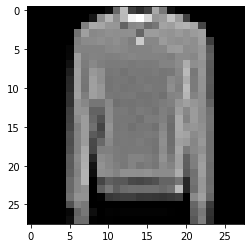

Actual Label: Pullover
Predicted Label: Pullover


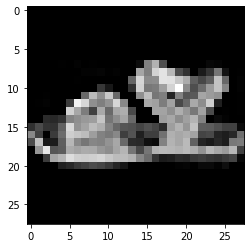

Actual Label: Sandal
Predicted Label: Sandal


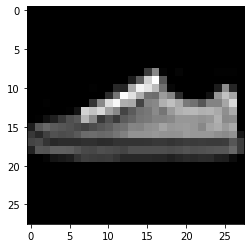

Actual Label: Sneaker
Predicted Label: Sneaker


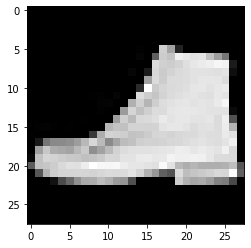

Actual Label: Ankle boot
Predicted Label: Ankle boot


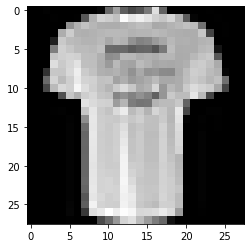

Actual Label: T-shirt/top
Predicted Label: T-shirt/top


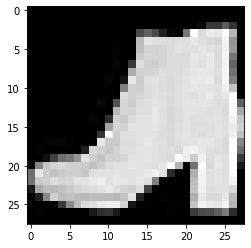

Actual Label: Ankle boot
Predicted Label: Ankle boot


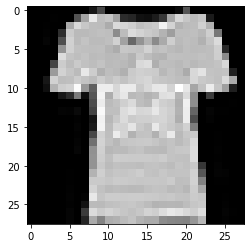

Actual Label: T-shirt/top
Predicted Label: T-shirt/top


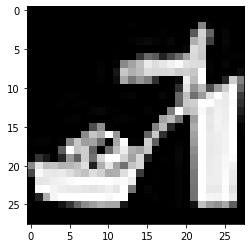

Actual Label: Sandal
Predicted Label: Sandal


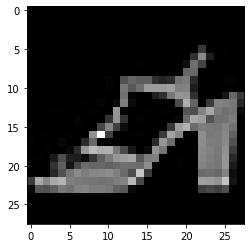

Actual Label: Sandal
Predicted Label: Sandal


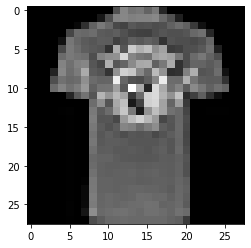

Actual Label: T-shirt/top
Predicted Label: T-shirt/top


In [59]:
for test_sample in fm_test.take(10):  
  image, label = test_sample[0], test_sample[1]

  img = tf.keras.preprocessing.image.img_to_array(image)                    
  img = np.expand_dims(img, axis=0)         
  img /= 255.    
  pred=fminst_load.predict(img)
  plt.figure()
  plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
  plt.show()
  print("Actual Label: %s" % info.features["label"].names[label.numpy()])
  print("Predicted Label: %s" % info.features["label"].names[np.argmax(pred)])


In [60]:
_, accuracy = best_model.evaluate(test_dataset)

    110/Unknown - 0s 384ms/step - loss: 0.1448 - accuracy: 0.968 - 0s 200ms/step - loss: 0.1684 - accuracy: 0.945 - 0s 139ms/step - loss: 0.2013 - accuracy: 0.942 - 0s 108ms/step - loss: 0.2061 - accuracy: 0.937 - 0s 90ms/step - loss: 0.1864 - accuracy: 0.940 - 0s 77ms/step - loss: 0.1841 - accuracy: 0.93 - 0s 69ms/step - loss: 0.1897 - accuracy: 0.93 - 0s 62ms/step - loss: 0.1859 - accuracy: 0.92 - 1s 57ms/step - loss: 0.1835 - accuracy: 0.93 - 1s 52ms/step - loss: 0.1967 - accuracy: 0.92 - 1s 49ms/step - loss: 0.1853 - accuracy: 0.93 - 1s 46ms/step - loss: 0.1980 - accuracy: 0.93 - 1s 43ms/step - loss: 0.1973 - accuracy: 0.92 - 1s 41ms/step - loss: 0.2034 - accuracy: 0.92 - 1s 40ms/step - loss: 0.2011 - accuracy: 0.92 - 1s 38ms/step - loss: 0.1993 - accuracy: 0.92 - 1s 36ms/step - loss: 0.2007 - accuracy: 0.92 - 1s 35ms/step - loss: 0.2080 - accuracy: 0.92 - 1s 34ms/step - loss: 0.2188 - accuracy: 0.92 - 1s 33ms/step - loss: 0.2226 - accuracy: 0.92 - 1s 32ms/step - loss: 0.2180 - acc

In [61]:
accuracy

0.9244286